## 1

Loading Wine-Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = pd.read_csv('WineQT.csv')
labels = data['quality']

### 1.1

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000         

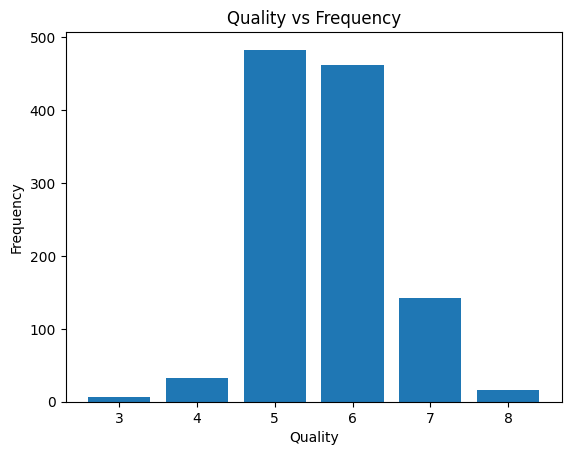

Train set size:  (800, 11)
Validation set size:  (171, 11)
Test set size:  (172, 11)
Train labels size:  (800, 6)
Validation labels size:  (171, 6)
Test labels size:  (172, 6)


In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Describing dataset
print(data.describe())

# Plotting the graph
plt.bar(labels.unique(), labels.value_counts())
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Quality vs Frequency')
plt.show()

data = data.drop(columns=['quality', 'Id'])

data = data.values
labels = labels.values

# Handling missing values
imputer = SimpleImputer(strategy='mean')
data = imputer.fit_transform(data)

# Normalising the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Standardising the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# One hot encoding the labels
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
labels = enc.fit_transform(labels.reshape(-1, 1)).toarray()

# Splitting the dataset into train(70%), validation(15%) and test(15%) sets
x_train, x_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print('Train set size: ', x_train.shape)
print('Validation set size: ', x_valid.shape)
print('Test set size: ', x_test.shape)

print('Train labels size: ', y_train.shape)
print('Validation labels size: ', y_valid.shape)
print('Test labels size: ', y_test.shape)

### 1.2

Multinomial Logistic Regression

In [3]:
from sklearn.metrics import accuracy_score, classification_report
import wandb

class MultinomialLogisticRegression:
    def __init__(self, num_classes, num_features, learning_rate, num_iterations):
        self.num_classes = num_classes
        self.num_features = num_features
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations

        # Initialize weights and biases
        self.weights = np.zeros((num_features, num_classes))
        self.bias = np.zeros(num_classes)

    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        m = y_true.shape[0]  
        #print(y_true.shape, y_pred.shape)
        return -1/m * np.sum(y_true * np.log(y_pred))

    def gradient_descent(self, X, y):
        m = X.shape[0]  

        # Forward pass
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)

        # Compute the gradient
        dz = y_pred - y
        dw = 1/m * np.dot(X.T, dz)
        db = 1/m * np.sum(dz, axis=0, keepdims=True)

        return dw, db, y_pred

    def fit(self, X, y, x_val, y_val):
        for i in range(self.num_iterations):
            dw, db, y_pred = self.gradient_descent(X, y)

            # Update the weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * np.squeeze(db)

            # Compute and print the loss
            loss = self.cross_entropy_loss(y, y_pred)
            y_pred_val = self.predict(x_val)
            val_loss = self.cross_entropy_loss(y_val, y_pred_val)

            # get accuracy on train set
            y_hat = np.argmax(y_pred, axis=1)
            y_true = np.argmax(y, axis=1)
            train_acc = accuracy_score(y_true, y_hat)

            #use classification report for validation
            y_hat = np.argmax(y_pred_val, axis=1)
            y_true = np.argmax(y_val, axis=1)
            report = classification_report(y_true, y_hat, zero_division=0)
            val_acc = accuracy_score(y_true, y_hat)

            if (i + 1) % 100 == 0:
                print(f'Iteration {i + 1}, loss = {loss}, val_loss = {val_loss}, train_acc = {train_acc}')
                if i == self.num_iterations - 1:
                    print(report)
                    return val_acc

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)
        return y_pred

Train

In [17]:
def train():
    config_defaults = {
        'learning_rate': 0.01,
        'epochs': 1000
    }
    wandb.init(project="wine-quality", entity="siyaputtagunta", config=config_defaults)
    config = wandb.config

    num_classes = y_train.shape[1]
    num_features = x_train.shape[1]

    model = MultinomialLogisticRegression(num_classes, num_features, learning_rate=config.learning_rate, num_iterations=config.epochs)
    acc = model.fit(x_train, y_train, x_valid, y_valid)

    wandb.log({'val_acc': acc})

### 1.3

In [20]:
sweep_config = {
    'method': 'grid',
    'name': 'hyperparameter-tuning',
    'metric': {
      'name': 'val_acc',
      'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.01, 0.1]
        },
        'epochs': {
            'values': [1000, 2000, 3000]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project="Task1", entity="siyaputtagunta")
wandb.agent(sweep_id, train)

Create sweep with ID: t5nigsvj
Sweep URL: https://wandb.ai/siyaputtagunta/Task1/sweeps/t5nigsvj


wandb: Agent Starting Run: cn0j3c3e with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Iteration 100, loss = 1.7572817550686741, val_loss = 1.7564628219733471, train_acc = 0.57875
Iteration 200, loss = 1.72401617116161, val_loss = 1.7227952001473343, train_acc = 0.57875
Iteration 300, loss = 1.6922863839322617, val_loss = 1.6907215182272015, train_acc = 0.57875
Iteration 400, loss = 1.662055169156154, val_loss = 1.6602012845181162, train_acc = 0.5775
Iteration 500, loss = 1.6332809201297283, val_loss = 1.6311889401779878, train_acc = 0.58
Iteration 600, loss = 1.6059180890803668, val_loss = 1.603634378439944, train_acc = 0.58
Iteration 700, loss = 1.5799177364692276, val_loss = 1.577483612042379, train_acc = 0.58125
Iteration 800, loss = 1.5552281583504524, val_loss = 1.5526795459193998, train_acc = 0.58125
Iteration 900, loss = 1.5317955582362472, val_loss = 1.5291628070121968, train_acc = 0.5825
Iteration 1000, loss = 1.509564729909413, val_loss = 1.5068725837670984, train_acc = 0.5825
              precision    recall  f1-score   support

           1       0.00      

val_acc,▁
val_acc,0.57895


wandb: Agent Starting Run: ntc9cvru with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Iteration 100, loss = 1.5112832600966866, val_loss = 1.506645491607533, train_acc = 0.5825
Iteration 200, loss = 1.342235395703144, val_loss = 1.33813712954772, train_acc = 0.5825
Iteration 300, loss = 1.2400698800936953, val_loss = 1.2349985231793124, train_acc = 0.57625
Iteration 400, loss = 1.1743126064250755, val_loss = 1.1666118338243192, train_acc = 0.57625
Iteration 500, loss = 1.129166917400279, val_loss = 1.1179065952534752, train_acc = 0.58375
Iteration 600, loss = 1.0965093982036545, val_loss = 1.0813920020265346, train_acc = 0.59125
Iteration 700, loss = 1.071926382079633, val_loss = 1.0530579967995024, train_acc = 0.59125
Iteration 800, loss = 1.0528488495143675, val_loss = 1.0305584916581982, train_acc = 0.59375
Iteration 900, loss = 1.0376822798915317, val_loss = 1.0124022340024486, train_acc = 0.6
Iteration 1000, loss = 1.0253829685627662, val_loss = 0.9975749081578991, train_acc = 0.6
              precision    recall  f1-score   support

           1       0.00      0

val_acc,▁
val_acc,0.60234


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: unavuc08 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Iteration 100, loss = 1.0257022671035716, val_loss = 0.9966969513931432, train_acc = 0.6
Iteration 200, loss = 0.9693043615352674, val_loss = 0.9335272193129815, train_acc = 0.61625
Iteration 300, loss = 0.95037392205364, val_loss = 0.9182517456239591, train_acc = 0.61875
Iteration 400, loss = 0.9406093806148674, val_loss = 0.9129423420129975, train_acc = 0.6175
Iteration 500, loss = 0.9345109583565829, val_loss = 0.9107461457586734, train_acc = 0.62125
Iteration 600, loss = 0.930283056469492, val_loss = 0.9097552788360829, train_acc = 0.61875
Iteration 700, loss = 0.9271536027859949, val_loss = 0.9092748176775013, train_acc = 0.62
Iteration 800, loss = 0.9247296516842729, val_loss = 0.9090140054626697, train_acc = 0.62
Iteration 900, loss = 0.9227876718363005, val_loss = 0.9088432587552182, train_acc = 0.61875
Iteration 1000, loss = 0.9211902260720148, val_loss = 0.9087038362716052, train_acc = 0.61875
              precision    recall  f1-score   support

           1       0.00     

val_acc,▁
val_acc,0.62573


wandb: Agent Starting Run: zo3f3v3s with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Iteration 100, loss = 1.7572817550686741, val_loss = 1.7564628219733471, train_acc = 0.57875
Iteration 200, loss = 1.72401617116161, val_loss = 1.7227952001473343, train_acc = 0.57875
Iteration 300, loss = 1.6922863839322617, val_loss = 1.6907215182272015, train_acc = 0.57875
Iteration 400, loss = 1.662055169156154, val_loss = 1.6602012845181162, train_acc = 0.5775
Iteration 500, loss = 1.6332809201297283, val_loss = 1.6311889401779878, train_acc = 0.58
Iteration 600, loss = 1.6059180890803668, val_loss = 1.603634378439944, train_acc = 0.58
Iteration 700, loss = 1.5799177364692276, val_loss = 1.577483612042379, train_acc = 0.58125
Iteration 800, loss = 1.5552281583504524, val_loss = 1.5526795459193998, train_acc = 0.58125
Iteration 900, loss = 1.5317955582362472, val_loss = 1.5291628070121968, train_acc = 0.5825
Iteration 1000, loss = 1.509564729909413, val_loss = 1.5068725837670984, train_acc = 0.5825
Iteration 1100, loss = 1.4884797208378162, val_loss = 1.4857474335005452, train_acc 

val_acc,▁
val_acc,0.57895


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xwy0un83 with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Iteration 100, loss = 1.5112832600966866, val_loss = 1.506645491607533, train_acc = 0.5825
Iteration 200, loss = 1.342235395703144, val_loss = 1.33813712954772, train_acc = 0.5825
Iteration 300, loss = 1.2400698800936953, val_loss = 1.2349985231793124, train_acc = 0.57625
Iteration 400, loss = 1.1743126064250755, val_loss = 1.1666118338243192, train_acc = 0.57625
Iteration 500, loss = 1.129166917400279, val_loss = 1.1179065952534752, train_acc = 0.58375
Iteration 600, loss = 1.0965093982036545, val_loss = 1.0813920020265346, train_acc = 0.59125
Iteration 700, loss = 1.071926382079633, val_loss = 1.0530579967995024, train_acc = 0.59125
Iteration 800, loss = 1.0528488495143675, val_loss = 1.0305584916581982, train_acc = 0.59375
Iteration 900, loss = 1.0376822798915317, val_loss = 1.0124022340024486, train_acc = 0.6
Iteration 1000, loss = 1.0253829685627662, val_loss = 0.9975749081578991, train_acc = 0.6
Iteration 1100, loss = 1.0152387561970628, val_loss = 0.985350811229903, train_acc = 

val_acc,▁
val_acc,0.63743


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xaqbfio8 with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Iteration 100, loss = 1.0257022671035716, val_loss = 0.9966969513931432, train_acc = 0.6
Iteration 200, loss = 0.9693043615352674, val_loss = 0.9335272193129815, train_acc = 0.61625
Iteration 300, loss = 0.95037392205364, val_loss = 0.9182517456239591, train_acc = 0.61875
Iteration 400, loss = 0.9406093806148674, val_loss = 0.9129423420129975, train_acc = 0.6175
Iteration 500, loss = 0.9345109583565829, val_loss = 0.9107461457586734, train_acc = 0.62125
Iteration 600, loss = 0.930283056469492, val_loss = 0.9097552788360829, train_acc = 0.61875
Iteration 700, loss = 0.9271536027859949, val_loss = 0.9092748176775013, train_acc = 0.62
Iteration 800, loss = 0.9247296516842729, val_loss = 0.9090140054626697, train_acc = 0.62
Iteration 900, loss = 0.9227876718363005, val_loss = 0.9088432587552182, train_acc = 0.61875
Iteration 1000, loss = 0.9211902260720148, val_loss = 0.9087038362716052, train_acc = 0.61875
Iteration 1100, loss = 0.9198478845302845, val_loss = 0.908569759904816, train_acc 

val_acc,▁
val_acc,0.62573


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 01dvmh9v with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Iteration 100, loss = 1.7572817550686741, val_loss = 1.7564628219733471, train_acc = 0.57875
Iteration 200, loss = 1.72401617116161, val_loss = 1.7227952001473343, train_acc = 0.57875
Iteration 300, loss = 1.6922863839322617, val_loss = 1.6907215182272015, train_acc = 0.57875
Iteration 400, loss = 1.662055169156154, val_loss = 1.6602012845181162, train_acc = 0.5775
Iteration 500, loss = 1.6332809201297283, val_loss = 1.6311889401779878, train_acc = 0.58
Iteration 600, loss = 1.6059180890803668, val_loss = 1.603634378439944, train_acc = 0.58
Iteration 700, loss = 1.5799177364692276, val_loss = 1.577483612042379, train_acc = 0.58125
Iteration 800, loss = 1.5552281583504524, val_loss = 1.5526795459193998, train_acc = 0.58125
Iteration 900, loss = 1.5317955582362472, val_loss = 1.5291628070121968, train_acc = 0.5825
Iteration 1000, loss = 1.509564729909413, val_loss = 1.5068725837670984, train_acc = 0.5825
Iteration 1100, loss = 1.4884797208378162, val_loss = 1.4857474335005452, train_acc 

val_acc,▁
val_acc,0.5848


wandb: Agent Starting Run: x8zqyzyo with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Iteration 100, loss = 1.5112832600966866, val_loss = 1.506645491607533, train_acc = 0.5825
Iteration 200, loss = 1.342235395703144, val_loss = 1.33813712954772, train_acc = 0.5825
Iteration 300, loss = 1.2400698800936953, val_loss = 1.2349985231793124, train_acc = 0.57625
Iteration 400, loss = 1.1743126064250755, val_loss = 1.1666118338243192, train_acc = 0.57625
Iteration 500, loss = 1.129166917400279, val_loss = 1.1179065952534752, train_acc = 0.58375
Iteration 600, loss = 1.0965093982036545, val_loss = 1.0813920020265346, train_acc = 0.59125
Iteration 700, loss = 1.071926382079633, val_loss = 1.0530579967995024, train_acc = 0.59125
Iteration 800, loss = 1.0528488495143675, val_loss = 1.0305584916581982, train_acc = 0.59375
Iteration 900, loss = 1.0376822798915317, val_loss = 1.0124022340024486, train_acc = 0.6
Iteration 1000, loss = 1.0253829685627662, val_loss = 0.9975749081578991, train_acc = 0.6
Iteration 1100, loss = 1.0152387561970628, val_loss = 0.985350811229903, train_acc = 

val_acc,▁
val_acc,0.63158


wandb: Agent Starting Run: soqltlqh with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Iteration 100, loss = 1.0257022671035716, val_loss = 0.9966969513931432, train_acc = 0.6
Iteration 200, loss = 0.9693043615352674, val_loss = 0.9335272193129815, train_acc = 0.61625
Iteration 300, loss = 0.95037392205364, val_loss = 0.9182517456239591, train_acc = 0.61875
Iteration 400, loss = 0.9406093806148674, val_loss = 0.9129423420129975, train_acc = 0.6175
Iteration 500, loss = 0.9345109583565829, val_loss = 0.9107461457586734, train_acc = 0.62125
Iteration 600, loss = 0.930283056469492, val_loss = 0.9097552788360829, train_acc = 0.61875
Iteration 700, loss = 0.9271536027859949, val_loss = 0.9092748176775013, train_acc = 0.62
Iteration 800, loss = 0.9247296516842729, val_loss = 0.9090140054626697, train_acc = 0.62
Iteration 900, loss = 0.9227876718363005, val_loss = 0.9088432587552182, train_acc = 0.61875
Iteration 1000, loss = 0.9211902260720148, val_loss = 0.9087038362716052, train_acc = 0.61875
Iteration 1100, loss = 0.9198478845302845, val_loss = 0.908569759904816, train_acc 

val_acc,▁
val_acc,0.62573


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Best Hyperparameters: Learning Rate: 0.01, Epochs: 2000

Testing

In [21]:
num_classes = y_train.shape[1]
num_features = x_train.shape[1]

model = MultinomialLogisticRegression(num_classes, num_features, learning_rate=0.01, num_iterations=2000)
val_acc = model.fit(x_train, y_train, x_valid, y_valid)
y_hat = model.predict(x_test)
y_hat = np.argmax(y_hat, axis=1)

y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_hat, zero_division=0)
print("Test Classification Report")
print(report)

Iteration 100, loss = 1.5112832600966866, val_loss = 1.506645491607533, train_acc = 0.5825
Iteration 200, loss = 1.342235395703144, val_loss = 1.33813712954772, train_acc = 0.5825
Iteration 300, loss = 1.2400698800936953, val_loss = 1.2349985231793124, train_acc = 0.57625
Iteration 400, loss = 1.1743126064250755, val_loss = 1.1666118338243192, train_acc = 0.57625
Iteration 500, loss = 1.129166917400279, val_loss = 1.1179065952534752, train_acc = 0.58375
Iteration 600, loss = 1.0965093982036545, val_loss = 1.0813920020265346, train_acc = 0.59125
Iteration 700, loss = 1.071926382079633, val_loss = 1.0530579967995024, train_acc = 0.59125
Iteration 800, loss = 1.0528488495143675, val_loss = 1.0305584916581982, train_acc = 0.59375
Iteration 900, loss = 1.0376822798915317, val_loss = 1.0124022340024486, train_acc = 0.6
Iteration 1000, loss = 1.0253829685627662, val_loss = 0.9975749081578991, train_acc = 0.6
Iteration 1100, loss = 1.0152387561970628, val_loss = 0.985350811229903, train_acc = 

## 2

### 2.1

Activation functions

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

MLP Classification

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss

class MlpClassifier:
    def __init__(self, input_size, output_size, num_layers, learning_rate, epochs, neurons_per_layer, activation_function, optimizer, mlb, num_samples):
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_hidden_layers = num_layers
        self.epochs = epochs
        self.batch_size = None
        self.neurons_per_layer = neurons_per_layer
        self.activation_function = activation_function
        self.optimizer = optimizer
        self.mlb = mlb
        self.num_samples = num_samples

        self.initialize_parameters()

    def initialize_parameters(self):
        if self.optimizer == 'sgd':
            self.batch_size = 1
        elif self.optimizer == 'mini-batch':
            self.batch_size = 32
        else:
            self.batch_size = self.num_samples

        self.weights = []
        self.biases = []

        # Input layer
        self.weights.append(np.random.randn(self.input_size, self.neurons_per_layer))
        self.biases.append(np.zeros((1, self.neurons_per_layer)))

        # Hidden layers
        for i in range(1, self.num_hidden_layers):
            self.weights.append(np.random.randn(self.neurons_per_layer, self.neurons_per_layer))
            self.biases.append(np.zeros((1, self.neurons_per_layer)))

        # Output layer
        self.weights.append(np.random.randn(self.neurons_per_layer, self.output_size))
        self.biases.append(np.zeros((1, self.output_size)))

    def forward_propagation(self, x):
        self.activations = []
        self.z_values = []

        a = x
        self.activations.append(a)

        for i in range(self.num_hidden_layers):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            self.z_values.append(z)

            if self.activation_function == 'sigmoid':
                a = sigmoid(z)
            elif self.activation_function == 'relu':
                a = relu(z)
            else:
                a = tanh(z)

            self.activations.append(a)

        # Output layer
        z = np.dot(a, self.weights[-1]) + self.biases[-1]

        if self.mlb:
            a = sigmoid(z)
        else:
            a = softmax(z)

        self.z_values.append(z)
        self.activations.append(a)

        return a

    def backward_propagation(self, x, y, output):
        m = x.shape[0]
        delta = output - y

        self.delta_weights = [0] * (self.num_hidden_layers + 1)
        self.delta_biases = [0] * (self.num_hidden_layers + 1)

        self.delta_weights[-1] = 1/m * np.dot(self.activations[-2].T, delta)
        self.delta_biases[-1] = 1/m * np.sum(delta, axis=0, keepdims=True)

        for i in range(self.num_hidden_layers - 1, 0, -1):
            if self.activation_function == 'sigmoid':
                delta = np.dot(delta, self.weights[i + 1].T) * sigmoid_derivative(self.z_values[i])
            elif self.activation_function == 'relu':
                delta = np.dot(delta, self.weights[i + 1].T) * relu_derivative(self.z_values[i])
            else:
                delta = np.dot(delta, self.weights[i + 1].T) * tanh_derivative(self.z_values[i])
        
            self.delta_weights[i] = 1/m * np.dot(self.activations[i].T, delta)
            self.delta_biases[i] = 1/m * np.sum(delta, axis=0, keepdims=True)

        if self.activation_function == 'sigmoid':
            delta = np.dot(delta, self.weights[1].T) * sigmoid_derivative(self.z_values[0])
        elif self.activation_function == 'relu':
            delta = np.dot(delta, self.weights[1].T) * relu_derivative(self.z_values[0])
        else:
            delta = np.dot(delta, self.weights[1].T) * tanh_derivative(self.z_values[0])
        
        self.delta_weights[0] = 1/m * np.dot(x.T, delta)
        self.delta_biases[0] = 1/m * np.sum(delta, axis=0, keepdims=True)

    def gradient_descent(self):
        for i in range(self.num_hidden_layers + 1):
            self.weights[i] -= self.learning_rate * self.delta_weights[i]
            self.biases[i] -= self.learning_rate * np.squeeze(self.delta_biases[i])

    def loss(self, y_true, y_pred):
        if self.mlb:
            epsilon = 1e-15 
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
            loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
            return np.mean(loss)
        else:
            return -1/y_true.shape[0] * np.sum(y_true * np.log(y_pred))

    def train(self, X, y, x_valid, y_valid):
        for epoch in range(self.epochs):

            for i in range(0, self.num_samples, self.batch_size):
                x_batch = X[i:i + self.batch_size]
                y_batch = y[i:i + self.batch_size]
                    
                output = self.forward_propagation(x_batch)

                self.backward_propagation(x_batch, y_batch, output)
                self.gradient_descent()

            train_loss = self.loss(y, self.forward_propagation(X))
            val_loss, y_true, y_pred = self.predict(x_valid, y_valid)

            if self.mlb:
                val_acc = 1 - hamming_loss(y_true, y_pred)
            else:
                val_acc = accuracy_score(y_true, y_pred)

            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch + 1}, train_loss = {train_loss}, val_loss = {val_loss}, val_acc = {val_acc}')

            if epoch == self.epochs - 1:
                precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
                recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
                f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

                #print precision, recall, f1
                print("Accuracy: ", val_acc, "Precision: ", precision, "Recall: ", recall, "F1 Score: ", f1)

                return train_loss, val_loss, val_acc, precision, recall, f1

    def predict(self, x, y):
        y_pred = self.forward_propagation(x)
        loss = self.loss(y, y_pred)

        if self.mlb:
            y_pred = np.where(y_pred > 0.5, 1, 0)
            y_true = y

        else:
            y_pred = np.argmax(y_pred, axis=1)
            y_true = np.argmax(y, axis=1)

        return loss, y_true, y_pred

    def test(self, x, y):
        y_pred = self.forward_propagation(x)
        if self.mlb:
            y_pred = np.where(y_pred > 0.5, 1, 0)
            y_true = y
            accuracy = 1 - hamming_loss(y_true, y_pred)

        else:
            y_pred = np.argmax(y_pred, axis=1)
            y_true = np.argmax(y, axis=1)
        
            accuracy = accuracy_score(y_true, y_pred)

        print("Accuracy: ", accuracy)
        print()
        print("Test Classification Report")
        report = classification_report(y_true, y_pred, zero_division=0)
        print(report)

### 2.2

Train 

In [8]:
scores1 = {}

def train():
    config_defaults = {
        'learning_rate': 0.01,
        'epochs': 1000,
        'optimizer': 'mbgd',    
        'neurons_per_layer': 32,
        'number_of_layers': 1,
        'activation_function': 'sigmoid',
    }

    wandb.init(project="Task 2", entity="siyaputtagunta", config=config_defaults)
    config = wandb.config

    model = MlpClassifier(x_train.shape[1], y_train.shape[1], num_layers=config.number_of_layers, learning_rate=config.learning_rate, epochs=config.epochs, neurons_per_layer=config.neurons_per_layer, activation_function=config.activation_function, optimizer=config.optimizer, mlb=0, num_samples=x_train.shape[0])
    train_loss, val_loss, val_acc, val_prec, val_rec, val_f1 = model.train(x_train, y_train, x_valid, y_valid)
    scores1[(config.activation_function, config.optimizer)] = (val_acc, val_prec, val_rec, val_f1)

    wandb.log({'train_loss': train_loss, 'val_loss': val_loss, 'val_acc': val_acc})

Hyperparameter tuning

In [9]:
sweep_config = {
    'method': 'grid',
    'name': 'hyperparameter-tuning',
    'metric': {
      'name': 'val_acc',
      'goal': 'maximize'
    },
    'parameters': {
        'optimizer': {
            'values': ['sgd', 'bgd', 'mbgd']
        },
        'activation_function': {
            'values': ['sigmoid', 'relu', 'tanh']
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="Task2", entity="siyaputtagunta")
wandb.agent(sweep_id, train)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: mxl9xwx4
Sweep URL: https://wandb.ai/siyaputtagunta/Task2/sweeps/mxl9xwx4


wandb: Agent Starting Run: h8s9pxhx with config:
wandb: 	activation_function: sigmoid
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: siyaputtagunta. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.7089749454989424, val_loss = 0.9960674143045922, val_acc = 0.6140350877192983
Epoch 200, train_loss = 0.5796874830339904, val_loss = 1.1506249746925452, val_acc = 0.6374269005847953
Epoch 300, train_loss = 0.4547251540880037, val_loss = 1.2554088184324361, val_acc = 0.5906432748538012
Epoch 400, train_loss = 0.35973803663742693, val_loss = 1.4210573909899595, val_acc = 0.5964912280701754
Epoch 500, train_loss = 0.29783156222908863, val_loss = 1.5963019916246344, val_acc = 0.5847953216374269
Epoch 600, train_loss = 0.24887460041929388, val_loss = 1.7979709567084161, val_acc = 0.5964912280701754
Epoch 700, train_loss = 0.20993925003611874, val_loss = 2.014044062396004, val_acc = 0.5906432748538012
Epoch 800, train_loss = 0.17880795091943286, val_loss = 2.199788846206345, val_acc = 0.6023391812865497
Epoch 900, train_loss = 0.15316924929781564, val_loss = 2.354008537756049, val_acc = 0.6081871345029239
Epoch 1000, train_loss = 0.13252999666271445, val_loss = 2.51

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.13253
val_acc,0.59649
val_loss,2.51089


wandb: Agent Starting Run: qdl3mpek with config:
wandb: 	activation_function: sigmoid
wandb: 	optimizer: bgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.4827697442545245, val_loss = 2.24724925659076, val_acc = 0.28654970760233917
Epoch 200, train_loss = 1.9061869525432265, val_loss = 1.7088139291192603, val_acc = 0.40350877192982454
Epoch 300, train_loss = 1.6723000827885008, val_loss = 1.4737183224229398, val_acc = 0.43859649122807015
Epoch 400, train_loss = 1.5368186585953918, val_loss = 1.3294687396044664, val_acc = 0.49122807017543857
Epoch 500, train_loss = 1.4430597860158014, val_loss = 1.2261116012099207, val_acc = 0.5263157894736842
Epoch 600, train_loss = 1.3733217257728267, val_loss = 1.1489688929576563, val_acc = 0.543859649122807
Epoch 700, train_loss = 1.3197520093432769, val_loss = 1.0912082927658175, val_acc = 0.5789473684210527
Epoch 800, train_loss = 1.2776574015399806, val_loss = 1.0480302656046934, val_acc = 0.5847953216374269
Epoch 900, train_loss = 1.2438286898483575, val_loss = 1.0156476120644597, val_acc = 0.6081871345029239
Epoch 1000, train_loss = 1.2160169091400348, val_loss = 0.99111

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.21602
val_acc,0.61988
val_loss,0.99111


wandb: Agent Starting Run: eobqf44t with config:
wandb: 	activation_function: sigmoid
wandb: 	optimizer: mbgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.123884337569656, val_loss = 1.9630882753350565, val_acc = 0.38011695906432746
Epoch 200, train_loss = 1.7525885469862348, val_loss = 1.5937058707771528, val_acc = 0.4444444444444444
Epoch 300, train_loss = 1.5479860366551839, val_loss = 1.3922565555005926, val_acc = 0.5146198830409356
Epoch 400, train_loss = 1.4186711542830963, val_loss = 1.2652555292508456, val_acc = 0.543859649122807
Epoch 500, train_loss = 1.3310809176859884, val_loss = 1.178797438902951, val_acc = 0.5789473684210527
Epoch 600, train_loss = 1.2683259045736663, val_loss = 1.1162450681367913, val_acc = 0.5730994152046783
Epoch 700, train_loss = 1.2213903896054281, val_loss = 1.0690102326717557, val_acc = 0.5730994152046783
Epoch 800, train_loss = 1.1851665517104732, val_loss = 1.032356575652781, val_acc = 0.5672514619883041
Epoch 900, train_loss = 1.156531691541464, val_loss = 1.003415009382406, val_acc = 0.5672514619883041
Epoch 1000, train_loss = 1.1334394650324529, val_loss = 0.98028092323

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.13344
val_acc,0.5614
val_loss,0.98028


wandb: Agent Starting Run: 329cb92y with config:
wandb: 	activation_function: relu
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.7630897528096183, val_loss = 1.498452068119008, val_acc = 0.6023391812865497
Epoch 200, train_loss = 0.8541357948529057, val_loss = 1.9377143775484056, val_acc = 0.5614035087719298
Epoch 300, train_loss = 0.7434290105985757, val_loss = 2.1167918093462497, val_acc = 0.5964912280701754
Epoch 400, train_loss = 0.6321766769158054, val_loss = 2.351884975789032, val_acc = 0.6140350877192983
Epoch 500, train_loss = 0.5425766353580753, val_loss = 2.7100289651523672, val_acc = 0.6198830409356725
Epoch 600, train_loss = 0.6863969025629935, val_loss = 3.2217013966467642, val_acc = 0.5964912280701754
Epoch 700, train_loss = 0.597753606212068, val_loss = 3.1436679942425134, val_acc = 0.5906432748538012
Epoch 800, train_loss = 0.4877195671336267, val_loss = 3.0979623344801808, val_acc = 0.6081871345029239
Epoch 900, train_loss = 0.6286925777024167, val_loss = 3.915432805605437, val_acc = 0.5964912280701754
Epoch 1000, train_loss = 1.5579334415559232, val_loss = 4.8610512348

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.55793
val_acc,0.60234
val_loss,4.86105


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zue0xr6e with config:
wandb: 	activation_function: relu
wandb: 	optimizer: bgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 4.3170260927600355, val_loss = 4.826440953126894, val_acc = 0.42105263157894735
Epoch 200, train_loss = 2.966593697560312, val_loss = 3.3130211997500405, val_acc = 0.4619883040935672
Epoch 300, train_loss = 2.5044362397204787, val_loss = 2.8899418130394037, val_acc = 0.47953216374269003
Epoch 400, train_loss = 2.240836597583095, val_loss = 2.665192475160506, val_acc = 0.5087719298245614
Epoch 500, train_loss = 2.0476300822351114, val_loss = 2.510400663507129, val_acc = 0.5263157894736842
Epoch 600, train_loss = 1.895934598649471, val_loss = 2.3884221228804003, val_acc = 0.5380116959064327
Epoch 700, train_loss = 1.772656227854591, val_loss = 2.290177883337682, val_acc = 0.5263157894736842
Epoch 800, train_loss = 1.6702161379629181, val_loss = 2.2003078785231494, val_acc = 0.5263157894736842
Epoch 900, train_loss = 1.5828215364607179, val_loss = 2.122538065555151, val_acc = 0.5380116959064327
Epoch 1000, train_loss = 1.508562527193979, val_loss = 2.05631319454326

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.50856
val_acc,0.55556
val_loss,2.05631


wandb: Agent Starting Run: g6gs0r1u with config:
wandb: 	activation_function: relu
wandb: 	optimizer: mbgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 3.5980972059363983, val_loss = 3.8872338256140244, val_acc = 0.36257309941520466
Epoch 200, train_loss = 2.532320217389428, val_loss = 2.6707411314825276, val_acc = 0.4619883040935672
Epoch 300, train_loss = 2.1052092155496203, val_loss = 2.2019137968503153, val_acc = 0.4853801169590643
Epoch 400, train_loss = 1.8553878500187302, val_loss = 1.9317297903572959, val_acc = 0.52046783625731
Epoch 500, train_loss = 1.6878013855288054, val_loss = 1.7572486448329945, val_acc = 0.5380116959064327
Epoch 600, train_loss = 1.5687454936912455, val_loss = 1.6413562358928016, val_acc = 0.5555555555555556
Epoch 700, train_loss = 1.4782829525896517, val_loss = 1.560597704403827, val_acc = 0.5555555555555556
Epoch 800, train_loss = 1.405389577943598, val_loss = 1.4996845792082323, val_acc = 0.5555555555555556
Epoch 900, train_loss = 1.3448167708749474, val_loss = 1.4505962984823684, val_acc = 0.543859649122807
Epoch 1000, train_loss = 1.2939313018434584, val_loss = 1.40924821770

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.29393
val_acc,0.53216
val_loss,1.40925


wandb: Agent Starting Run: wo7ia5x1 with config:
wandb: 	activation_function: tanh
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.39875961267620275, val_loss = 1.6192440844359288, val_acc = 0.5380116959064327
Epoch 200, train_loss = 0.2463762558134776, val_loss = 2.31905855712855, val_acc = 0.5146198830409356
Epoch 300, train_loss = 0.16792196633034465, val_loss = 3.0688914604261317, val_acc = 0.5321637426900585
Epoch 400, train_loss = 0.11674667916391751, val_loss = 3.6416661940130597, val_acc = 0.5321637426900585
Epoch 500, train_loss = 0.08730598823203739, val_loss = 4.169550693829109, val_acc = 0.52046783625731
Epoch 600, train_loss = 0.06641369544187314, val_loss = 4.661964269518481, val_acc = 0.5087719298245614
Epoch 700, train_loss = 0.05057102402137629, val_loss = 5.0792660769730125, val_acc = 0.5146198830409356
Epoch 800, train_loss = 0.039157919614370824, val_loss = 5.386212550139659, val_acc = 0.5263157894736842
Epoch 900, train_loss = 0.03143941095427348, val_loss = 5.657526308724925, val_acc = 0.5146198830409356
Epoch 1000, train_loss = 0.025829599134507473, val_loss = 5.887

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.02583
val_acc,0.51462
val_loss,5.88731


wandb: Agent Starting Run: gtozrdcx with config:
wandb: 	activation_function: tanh
wandb: 	optimizer: bgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 3.6229978278606074, val_loss = 4.086399725492314, val_acc = 0.3216374269005848
Epoch 200, train_loss = 2.5052051668817823, val_loss = 2.8083066830302394, val_acc = 0.42105263157894735
Epoch 300, train_loss = 2.022467926246809, val_loss = 2.234606538642562, val_acc = 0.45614035087719296
Epoch 400, train_loss = 1.7566175667316475, val_loss = 1.9253420979211375, val_acc = 0.4853801169590643
Epoch 500, train_loss = 1.5866425109227111, val_loss = 1.7445649780277068, val_acc = 0.5380116959064327
Epoch 600, train_loss = 1.4651904607773154, val_loss = 1.6273923474897556, val_acc = 0.5380116959064327
Epoch 700, train_loss = 1.3735617222011711, val_loss = 1.5453761470448226, val_acc = 0.543859649122807
Epoch 800, train_loss = 1.3040305423612006, val_loss = 1.4866306914741458, val_acc = 0.5321637426900585
Epoch 900, train_loss = 1.2517216886772091, val_loss = 1.4435835512758541, val_acc = 0.5672514619883041
Epoch 1000, train_loss = 1.211170661188374, val_loss = 1.410260139

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.21117
val_acc,0.5614
val_loss,1.41026


wandb: Agent Starting Run: 5y9og2bp with config:
wandb: 	activation_function: tanh
wandb: 	optimizer: mbgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 3.2524627172239584, val_loss = 3.451109471337742, val_acc = 0.26900584795321636
Epoch 200, train_loss = 2.3787977680187113, val_loss = 2.4504735417475407, val_acc = 0.40350877192982454
Epoch 300, train_loss = 2.023537478389018, val_loss = 1.9821510174087396, val_acc = 0.47368421052631576
Epoch 400, train_loss = 1.8195849151854333, val_loss = 1.708674119075187, val_acc = 0.52046783625731
Epoch 500, train_loss = 1.676616931093343, val_loss = 1.5215719762866398, val_acc = 0.5497076023391813
Epoch 600, train_loss = 1.568122659251338, val_loss = 1.3850425912854367, val_acc = 0.5497076023391813
Epoch 700, train_loss = 1.4821737717045391, val_loss = 1.2824687217579964, val_acc = 0.5730994152046783
Epoch 800, train_loss = 1.4125933343505241, val_loss = 1.204798044404719, val_acc = 0.5789473684210527
Epoch 900, train_loss = 1.3555262503230479, val_loss = 1.1456823867514914, val_acc = 0.5964912280701754
Epoch 1000, train_loss = 1.3080562700712492, val_loss = 1.10005940569

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.30806
val_acc,0.59649
val_loss,1.10006


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [10]:
from collections import OrderedDict

print('Scores for MLPClassifier for each combination of activation function and optimizer')
print('-------------------------------------------------------------------------------------------------------------')
print('Activation\t\tOptimizer\t\tAccuracy\t\tPrecision\t\tRecall\t\tF1 Score')
print('-------------------------------------------------------------------------------------------------------------')

scores1 = OrderedDict(sorted(scores1.items(), key=lambda x: x[1][0], reverse=True))

for key, value in scores1.items():
    print("%s\t\t\t%s\t\t\t%.4f\t\t\t%.4f\t\t\t%.4f\t\t%.4f" % (key[0], key[1], value[0], value[1], value[2], value[3]))

print('-------------------------------------------------------------------------------------------------------------')

Scores for MLPClassifier for each combination of activation function and optimizer
-------------------------------------------------------------------------------------------------------------
Activation		Optimizer		Accuracy		Precision		Recall		F1 Score
-------------------------------------------------------------------------------------------------------------
sigmoid			bgd			0.6199			0.4738			0.3901		0.4066
relu			sgd			0.6023			0.4604			0.3588		0.3731
sigmoid			sgd			0.5965			0.3063			0.3097		0.3069
tanh			mbgd			0.5965			0.3007			0.2833		0.2909
sigmoid			mbgd			0.5614			0.2950			0.2989		0.2945
tanh			bgd			0.5614			0.2912			0.2820		0.2851
relu			bgd			0.5556			0.2639			0.2549		0.2578
relu			mbgd			0.5322			0.2654			0.2553		0.2551
tanh			sgd			0.5146			0.3448			0.4190		0.3678
-------------------------------------------------------------------------------------------------------------


In [34]:
def train():
    config_defaults = {
        'learning_rate': 0.01,
        'epochs': 1000,
        'optimizer': 'bgd',    
        'neurons_per_layer': 32,
        'number_of_layers': 1,
        'activation_function': 'sigmoid',
    }

    wandb.init(project="Task 2", entity="siyaputtagunta", config=config_defaults)
    config = wandb.config

    model = MlpClassifier(x_train.shape[1], y_train.shape[1], num_layers=config.number_of_layers, learning_rate=config.learning_rate, epochs=config.epochs, neurons_per_layer=config.neurons_per_layer, activation_function=config.activation_function, optimizer=config.optimizer, mlb=0, num_samples=x_train.shape[0])
    train_loss, val_loss, val_acc, val_prec, val_rec, val_f1 = model.train(x_train, y_train, x_valid, y_valid)
    
    wandb.log({'train_loss': train_loss, 'val_loss': val_loss, 'val_acc': val_acc})

Hyperparameter Tuning

In [12]:
sweep_config = {
    'method': 'grid',
    'name': 'hyperparameter-tuning',
    'metric': {
      'name': 'val_acc',
      'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.01, 0.1]
        },
        'epochs': {
            'values': [1000, 2000, 3000]
        },
        'neurons_per_layer': {
            'values': [10, 32, 64]
        },
        'number_of_layers': {
            'values': [1, 2, 3]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project="Task2", entity="siyaputtagunta")
wandb.agent(sweep_id, train)

Create sweep with ID: d9qunu49
Sweep URL: https://wandb.ai/siyaputtagunta/Task2/sweeps/d9qunu49


wandb: Agent Starting Run: bpltp7cm with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 3.0042190152971853, val_loss = 2.8171901222043667, val_acc = 0.08771929824561403
Epoch 200, train_loss = 2.8547386467328546, val_loss = 2.6739012709182473, val_acc = 0.08771929824561403
Epoch 300, train_loss = 2.718559672507755, val_loss = 2.5437005811855538, val_acc = 0.08771929824561403
Epoch 400, train_loss = 2.594983975340485, val_loss = 2.4259518237467024, val_acc = 0.11695906432748537
Epoch 500, train_loss = 2.483202549103215, val_loss = 2.3198934385413503, val_acc = 0.14035087719298245
Epoch 600, train_loss = 2.3823281071350415, val_loss = 2.2246686118915613, val_acc = 0.15204678362573099
Epoch 700, train_loss = 2.2914343947624376, val_loss = 2.139364240710593, val_acc = 0.15204678362573099
Epoch 800, train_loss = 2.2095941111590665, val_loss = 2.0630505333952245, val_acc = 0.16374269005847952
Epoch 900, train_loss = 2.135909982971361, val_loss = 1.9948152295554047, val_acc = 0.21052631578947367
Epoch 1000, train_loss = 2.069536649920007, val_loss = 1.933

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,2.06954
val_acc,0.21637
val_loss,1.93379


wandb: Agent Starting Run: dartcj7t with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.385265403454348, val_loss = 2.57787000486228, val_acc = 0.26900584795321636
Epoch 200, train_loss = 2.2956836555325872, val_loss = 2.4773818859670937, val_acc = 0.27485380116959063
Epoch 300, train_loss = 2.2125143478989537, val_loss = 2.3831716204297524, val_acc = 0.29239766081871343
Epoch 400, train_loss = 2.1345842127964785, val_loss = 2.2941526773869434, val_acc = 0.2982456140350877
Epoch 500, train_loss = 2.0611309729500618, val_loss = 2.2096377665063005, val_acc = 0.29239766081871343
Epoch 600, train_loss = 1.9916790825146709, val_loss = 2.12921780097626, val_acc = 0.30409356725146197
Epoch 700, train_loss = 1.9259507761093049, val_loss = 2.052675012163338, val_acc = 0.30409356725146197
Epoch 800, train_loss = 1.8638019645448602, val_loss = 1.979920062726125, val_acc = 0.3157894736842105
Epoch 900, train_loss = 1.8051750976843257, val_loss = 1.910945489921531, val_acc = 0.32748538011695905
Epoch 1000, train_loss = 1.7500635403700444, val_loss = 1.8457901

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.75006
val_acc,0.32749
val_loss,1.84579


wandb: Agent Starting Run: 832oyfhi with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 4.349526762100857, val_loss = 4.503065268021479, val_acc = 0.017543859649122806
Epoch 200, train_loss = 3.9194913564840936, val_loss = 4.063157730351524, val_acc = 0.05847953216374269
Epoch 300, train_loss = 3.5378138868326987, val_loss = 3.6706171818408664, val_acc = 0.10526315789473684
Epoch 400, train_loss = 3.1966506659644787, val_loss = 3.317649654416058, val_acc = 0.11695906432748537
Epoch 500, train_loss = 2.892444212729714, val_loss = 3.0007642739683393, val_acc = 0.1111111111111111
Epoch 600, train_loss = 2.6234097192674173, val_loss = 2.718281420407999, val_acc = 0.11695906432748537
Epoch 700, train_loss = 2.388111126901183, val_loss = 2.468947181432261, val_acc = 0.12280701754385964
Epoch 800, train_loss = 2.184850658554489, val_loss = 2.251338590928177, val_acc = 0.12280701754385964
Epoch 900, train_loss = 2.011557453570628, val_loss = 2.0637334401961973, val_acc = 0.2046783625730994
Epoch 1000, train_loss = 1.8658625070257524, val_loss = 1.904139699

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.86586
val_acc,0.33918
val_loss,1.90414


wandb: Agent Starting Run: 4yazjhva with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 4.199611322829064, val_loss = 4.2314898365009395, val_acc = 0.14619883040935672
Epoch 200, train_loss = 3.7434749194257586, val_loss = 3.7620830478482348, val_acc = 0.19883040935672514
Epoch 300, train_loss = 3.362948827716148, val_loss = 3.367498198625421, val_acc = 0.21637426900584794
Epoch 400, train_loss = 3.0530861152120172, val_loss = 3.0440047827059935, val_acc = 0.26900584795321636
Epoch 500, train_loss = 2.8042865396625896, val_loss = 2.782817580864253, val_acc = 0.3157894736842105
Epoch 600, train_loss = 2.605308479734159, val_loss = 2.573009272881578, val_acc = 0.32748538011695905
Epoch 700, train_loss = 2.445448984936923, val_loss = 2.4038117535933816, val_acc = 0.3684210526315789
Epoch 800, train_loss = 2.3156067706716876, val_loss = 2.265884515028442, val_acc = 0.39766081871345027
Epoch 900, train_loss = 2.2085501011804385, val_loss = 2.1517345059383675, val_acc = 0.39766081871345027
Epoch 1000, train_loss = 2.118770379855089, val_loss = 2.05563571

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,2.11877
val_acc,0.43275
val_loss,2.05564


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 94gu57q8 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 7.540655230598507, val_loss = 8.367842645568643, val_acc = 0.005847953216374269
Epoch 200, train_loss = 6.445825369131192, val_loss = 7.2323506453542565, val_acc = 0.011695906432748537
Epoch 300, train_loss = 5.542374859763556, val_loss = 6.268105430762832, val_acc = 0.017543859649122806
Epoch 400, train_loss = 4.840516392037821, val_loss = 5.492436544810498, val_acc = 0.07017543859649122
Epoch 500, train_loss = 4.294206599578863, val_loss = 4.869528031631335, val_acc = 0.1111111111111111
Epoch 600, train_loss = 3.847967259556631, val_loss = 4.349187745533709, val_acc = 0.14035087719298245
Epoch 700, train_loss = 3.465348620541079, val_loss = 3.8962111052432356, val_acc = 0.15204678362573099
Epoch 800, train_loss = 3.130514432815538, val_loss = 3.494720830637922, val_acc = 0.16374269005847952
Epoch 900, train_loss = 2.84121935640709, val_loss = 3.142590292121578, val_acc = 0.23391812865497075
Epoch 1000, train_loss = 2.600530452233786, val_loss = 2.8436402747064

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,2.60053
val_acc,0.26316
val_loss,2.84364


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4nv83qx8 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.392918255325571, val_loss = 2.5311416283825845, val_acc = 0.3508771929824561
Epoch 200, train_loss = 2.0796581988023135, val_loss = 2.1586818152378195, val_acc = 0.34502923976608185
Epoch 300, train_loss = 1.8163700187672291, val_loss = 1.8392378724499525, val_acc = 0.3508771929824561
Epoch 400, train_loss = 1.6196699645875805, val_loss = 1.5935943440904616, val_acc = 0.36257309941520466
Epoch 500, train_loss = 1.4922601436858185, val_loss = 1.4274311581161747, val_acc = 0.3508771929824561
Epoch 600, train_loss = 1.4185205684857614, val_loss = 1.325714878865787, val_acc = 0.3684210526315789
Epoch 700, train_loss = 1.3773590069359742, val_loss = 1.2656945300602525, val_acc = 0.3684210526315789
Epoch 800, train_loss = 1.3532944230310897, val_loss = 1.2293638148566057, val_acc = 0.4152046783625731
Epoch 900, train_loss = 1.3377776571200886, val_loss = 1.2058984757553803, val_acc = 0.4269005847953216
Epoch 1000, train_loss = 1.326634043592299, val_loss = 1.1894772

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.32663
val_acc,0.43275
val_loss,1.18948


wandb: Agent Starting Run: ywuiz8jy with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 3.748859789173602, val_loss = 3.7290086606452353, val_acc = 0.17543859649122806
Epoch 200, train_loss = 3.2046887759257845, val_loss = 3.18924658705983, val_acc = 0.2046783625730994
Epoch 300, train_loss = 2.8190795053987143, val_loss = 2.799321268802333, val_acc = 0.22807017543859648
Epoch 400, train_loss = 2.5428570588367125, val_loss = 2.5132228033268453, val_acc = 0.24561403508771928
Epoch 500, train_loss = 2.3438605481223536, val_loss = 2.302769304439451, val_acc = 0.26900584795321636
Epoch 600, train_loss = 2.1981580374666017, val_loss = 2.146653748802554, val_acc = 0.26900584795321636
Epoch 700, train_loss = 2.0882697720006367, val_loss = 2.0281887957383526, val_acc = 0.30409356725146197
Epoch 800, train_loss = 2.002336047513939, val_loss = 1.935286001227946, val_acc = 0.3391812865497076
Epoch 900, train_loss = 1.9327635329699513, val_loss = 1.8598598589807915, val_acc = 0.36257309941520466
Epoch 1000, train_loss = 1.8747837217745893, val_loss = 1.7967252

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.87478
val_acc,0.36842
val_loss,1.79673


wandb: Agent Starting Run: vvhep9i3 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 6.566692002657117, val_loss = 5.594198394795372, val_acc = 0.3333333333333333
Epoch 200, train_loss = 5.724178291385463, val_loss = 4.880292158200957, val_acc = 0.3391812865497076
Epoch 300, train_loss = 4.902187426556008, val_loss = 4.185848631518106, val_acc = 0.3391812865497076
Epoch 400, train_loss = 4.109095335488523, val_loss = 3.5181917719799474, val_acc = 0.3391812865497076
Epoch 500, train_loss = 3.3847993531562386, val_loss = 2.9131237376746553, val_acc = 0.3508771929824561
Epoch 600, train_loss = 2.8181971438896425, val_loss = 2.4530010156238986, val_acc = 0.3508771929824561
Epoch 700, train_loss = 2.4560516031289445, val_loss = 2.176608970873119, val_acc = 0.38596491228070173
Epoch 800, train_loss = 2.2459093248372852, val_loss = 2.023667340556571, val_acc = 0.40350877192982454
Epoch 900, train_loss = 2.1189761568877197, val_loss = 1.9290078676011098, val_acc = 0.39766081871345027
Epoch 1000, train_loss = 2.0330601439319933, val_loss = 1.859411230666

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,2.03306
val_acc,0.4152
val_loss,1.85941


wandb: Agent Starting Run: d673mds7 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 5.210005799792919, val_loss = 4.89398055421599, val_acc = 0.15789473684210525
Epoch 200, train_loss = 3.8793332455762606, val_loss = 3.66767692750942, val_acc = 0.25146198830409355
Epoch 300, train_loss = 3.130920459224721, val_loss = 2.983932460173222, val_acc = 0.30409356725146197
Epoch 400, train_loss = 2.7957196254358165, val_loss = 2.6675104888633263, val_acc = 0.39766081871345027
Epoch 500, train_loss = 2.6128657972814646, val_loss = 2.483296771055138, val_acc = 0.4327485380116959
Epoch 600, train_loss = 2.4746182313065233, val_loss = 2.3383266734383152, val_acc = 0.4502923976608187
Epoch 700, train_loss = 2.3534967605869843, val_loss = 2.209796322503858, val_acc = 0.47368421052631576
Epoch 800, train_loss = 2.2426040262658105, val_loss = 2.0921292261196043, val_acc = 0.4678362573099415
Epoch 900, train_loss = 2.1406433566771925, val_loss = 1.984342814259011, val_acc = 0.47953216374269003
Epoch 1000, train_loss = 2.0480375839286, val_loss = 1.8869951710823

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,2.04804
val_acc,0.48538
val_loss,1.887


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vb5yocs0 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.8122143089142684, val_loss = 3.0090480138969515, val_acc = 0.19883040935672514
Epoch 200, train_loss = 2.0357617708780493, val_loss = 2.112890931717476, val_acc = 0.2807017543859649
Epoch 300, train_loss = 1.5899268739990786, val_loss = 1.5752076273614743, val_acc = 0.39766081871345027
Epoch 400, train_loss = 1.3918388161269053, val_loss = 1.3258539519050714, val_acc = 0.49707602339181284
Epoch 500, train_loss = 1.3025645233051593, val_loss = 1.2118320679413643, val_acc = 0.5321637426900585
Epoch 600, train_loss = 1.2526427571896803, val_loss = 1.1491652627196245, val_acc = 0.5497076023391813
Epoch 700, train_loss = 1.2194074592252448, val_loss = 1.1081476754570225, val_acc = 0.5497076023391813
Epoch 800, train_loss = 1.194962978587175, val_loss = 1.0781862842647878, val_acc = 0.5614035087719298
Epoch 900, train_loss = 1.175878331789313, val_loss = 1.0548749768722403, val_acc = 0.5672514619883041
Epoch 1000, train_loss = 1.1603710150105389, val_loss = 1.036053

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.16037
val_acc,0.57895
val_loss,1.03605


wandb: Agent Starting Run: 4rf6a8xk with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.5691578198257186, val_loss = 2.374716867243746, val_acc = 0.32748538011695905
Epoch 200, train_loss = 1.6424561400326971, val_loss = 1.5488907798303648, val_acc = 0.4269005847953216
Epoch 300, train_loss = 1.3479636874163914, val_loss = 1.3018476688986467, val_acc = 0.47953216374269003
Epoch 400, train_loss = 1.27075542024301, val_loss = 1.2253067686807027, val_acc = 0.4327485380116959
Epoch 500, train_loss = 1.2331871075759673, val_loss = 1.1785371031613658, val_acc = 0.4327485380116959
Epoch 600, train_loss = 1.208681041048743, val_loss = 1.1449689256057671, val_acc = 0.4444444444444444
Epoch 700, train_loss = 1.1908084366027845, val_loss = 1.1194488839917067, val_acc = 0.45614035087719296
Epoch 800, train_loss = 1.176958298938788, val_loss = 1.0992347337815656, val_acc = 0.49122807017543857
Epoch 900, train_loss = 1.1657770232289417, val_loss = 1.0827216081940092, val_acc = 0.5029239766081871
Epoch 1000, train_loss = 1.1564718818531237, val_loss = 1.0689100

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.15647
val_acc,0.52632
val_loss,1.06891


wandb: Agent Starting Run: wyj9mtn0 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.574884289840526, val_loss = 1.4529529745359704, val_acc = 0.4619883040935672
Epoch 200, train_loss = 1.3065440015386145, val_loss = 1.236371620733517, val_acc = 0.4269005847953216
Epoch 300, train_loss = 1.2558607986154549, val_loss = 1.194212528275148, val_acc = 0.391812865497076
Epoch 400, train_loss = 1.2359545082319436, val_loss = 1.172995539772734, val_acc = 0.38596491228070173
Epoch 500, train_loss = 1.2239413524829417, val_loss = 1.1585995962501705, val_acc = 0.4152046783625731
Epoch 600, train_loss = 1.2153784115535782, val_loss = 1.1479662393008334, val_acc = 0.4152046783625731
Epoch 700, train_loss = 1.2087442452437396, val_loss = 1.139666068672032, val_acc = 0.4269005847953216
Epoch 800, train_loss = 1.203324039694322, val_loss = 1.1329113678318756, val_acc = 0.43859649122807015
Epoch 900, train_loss = 1.1987185680178332, val_loss = 1.1272300973315055, val_acc = 0.4678362573099415
Epoch 1000, train_loss = 1.194682864964779, val_loss = 1.122320747639

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.19468
val_acc,0.46784
val_loss,1.12232


wandb: Agent Starting Run: md5vr2wa with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.3783060557264917, val_loss = 2.4522430660527, val_acc = 0.27485380116959063
Epoch 200, train_loss = 1.680781558110275, val_loss = 1.546319436870017, val_acc = 0.4269005847953216
Epoch 300, train_loss = 1.4447147275763887, val_loss = 1.2416349908503137, val_acc = 0.47368421052631576
Epoch 400, train_loss = 1.3275997851452912, val_loss = 1.1061547024613276, val_acc = 0.5263157894736842
Epoch 500, train_loss = 1.256938645922871, val_loss = 1.0332915724229017, val_acc = 0.5614035087719298
Epoch 600, train_loss = 1.208902304696817, val_loss = 0.9882723352905484, val_acc = 0.5906432748538012
Epoch 700, train_loss = 1.1737916940693782, val_loss = 0.9579932044167473, val_acc = 0.6198830409356725
Epoch 800, train_loss = 1.1469650113014533, val_loss = 0.9366391107022395, val_acc = 0.6257309941520468
Epoch 900, train_loss = 1.1258208924498863, val_loss = 0.9211402486480552, val_acc = 0.6432748538011696
Epoch 1000, train_loss = 1.108714165583404, val_loss = 0.909648675976

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.10871
val_acc,0.63743
val_loss,0.90965


wandb: Agent Starting Run: t47nq34e with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.8123233743491711, val_loss = 1.7636710047068747, val_acc = 0.3742690058479532
Epoch 200, train_loss = 1.4680777176992978, val_loss = 1.378997470699575, val_acc = 0.5029239766081871
Epoch 300, train_loss = 1.3164366170358932, val_loss = 1.210885080896435, val_acc = 0.47368421052631576
Epoch 400, train_loss = 1.240958746212967, val_loss = 1.1292767423842622, val_acc = 0.5029239766081871
Epoch 500, train_loss = 1.1916497400573767, val_loss = 1.0778618627210643, val_acc = 0.5146198830409356
Epoch 600, train_loss = 1.1560043715469017, val_loss = 1.0422189079921642, val_acc = 0.5087719298245614
Epoch 700, train_loss = 1.1288845196285766, val_loss = 1.0163602314012714, val_acc = 0.5380116959064327
Epoch 800, train_loss = 1.1074713383048727, val_loss = 0.9970044055923843, val_acc = 0.5614035087719298
Epoch 900, train_loss = 1.0900560531860284, val_loss = 0.9821496545688183, val_acc = 0.5730994152046783
Epoch 1000, train_loss = 1.0755439593636726, val_loss = 0.97049996

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.07554
val_acc,0.5731
val_loss,0.9705


wandb: Agent Starting Run: 4hmkk1tq with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.3436188863024132, val_loss = 1.1655269448728471, val_acc = 0.5263157894736842
Epoch 200, train_loss = 1.2332330754837093, val_loss = 1.077058236267237, val_acc = 0.5321637426900585
Epoch 300, train_loss = 1.1709642523279498, val_loss = 1.0328153317939999, val_acc = 0.5380116959064327
Epoch 400, train_loss = 1.1266324631891775, val_loss = 1.0035710386013807, val_acc = 0.5497076023391813
Epoch 500, train_loss = 1.0944910253416937, val_loss = 0.983819112700174, val_acc = 0.5789473684210527
Epoch 600, train_loss = 1.0717125223620234, val_loss = 0.9707654316869221, val_acc = 0.5789473684210527
Epoch 700, train_loss = 1.055600361184575, val_loss = 0.9619231901324402, val_acc = 0.5730994152046783
Epoch 800, train_loss = 1.0436303151744082, val_loss = 0.955299394290838, val_acc = 0.5964912280701754
Epoch 900, train_loss = 1.0340803634465294, val_loss = 0.9498212302525706, val_acc = 0.6140350877192983
Epoch 1000, train_loss = 1.0260206785007844, val_loss = 0.9450817716

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.02602
val_acc,0.60819
val_loss,0.94508


wandb: Agent Starting Run: qnl2o8xq with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.3346378480870364, val_loss = 2.4800133664529813, val_acc = 0.39766081871345027
Epoch 200, train_loss = 1.746730570677699, val_loss = 1.824504214426624, val_acc = 0.49122807017543857
Epoch 300, train_loss = 1.4741899720523535, val_loss = 1.5188794031011534, val_acc = 0.5087719298245614
Epoch 400, train_loss = 1.3275420142128689, val_loss = 1.351966105824046, val_acc = 0.5380116959064327
Epoch 500, train_loss = 1.2458087128905602, val_loss = 1.2581659667449208, val_acc = 0.543859649122807
Epoch 600, train_loss = 1.1963136481330074, val_loss = 1.2018274826468247, val_acc = 0.5789473684210527
Epoch 700, train_loss = 1.163180771351232, val_loss = 1.1652275808999912, val_acc = 0.5847953216374269
Epoch 800, train_loss = 1.1389031266260918, val_loss = 1.1397428027013523, val_acc = 0.5906432748538012
Epoch 900, train_loss = 1.119802517328394, val_loss = 1.1209499666431277, val_acc = 0.5789473684210527
Epoch 1000, train_loss = 1.103959747474182, val_loss = 1.10641245765

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.10396
val_acc,0.5731
val_loss,1.10641


wandb: Agent Starting Run: tm8js3ql with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.799118144539645, val_loss = 1.8364969346893774, val_acc = 0.4327485380116959
Epoch 200, train_loss = 1.525915149373289, val_loss = 1.5037565896169922, val_acc = 0.4444444444444444
Epoch 300, train_loss = 1.4035702625983846, val_loss = 1.3629511893814714, val_acc = 0.49707602339181284
Epoch 400, train_loss = 1.3253208258500448, val_loss = 1.2773183013707474, val_acc = 0.52046783625731
Epoch 500, train_loss = 1.2691943095335945, val_loss = 1.2175791631820372, val_acc = 0.5263157894736842
Epoch 600, train_loss = 1.2259730898111987, val_loss = 1.1725438804679735, val_acc = 0.5614035087719298
Epoch 700, train_loss = 1.1910020276144817, val_loss = 1.1369002042591956, val_acc = 0.5730994152046783
Epoch 800, train_loss = 1.161704022938182, val_loss = 1.1077736329310528, val_acc = 0.5789473684210527
Epoch 900, train_loss = 1.1365518344747185, val_loss = 1.0834503255410783, val_acc = 0.5847953216374269
Epoch 1000, train_loss = 1.114580803923509, val_loss = 1.06282535803

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.11458
val_acc,0.5848
val_loss,1.06283


wandb: Agent Starting Run: ksjkpxwv with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.4900471028521103, val_loss = 1.410079663271502, val_acc = 0.4502923976608187
Epoch 200, train_loss = 1.3226208458639053, val_loss = 1.2363990332512567, val_acc = 0.49707602339181284
Epoch 300, train_loss = 1.2239252068641366, val_loss = 1.1458899940635672, val_acc = 0.5029239766081871
Epoch 400, train_loss = 1.1598498575148022, val_loss = 1.0943516443184151, val_acc = 0.5087719298245614
Epoch 500, train_loss = 1.1168070498905964, val_loss = 1.0631813249924247, val_acc = 0.52046783625731
Epoch 600, train_loss = 1.0855577152138267, val_loss = 1.0420411217842993, val_acc = 0.5321637426900585
Epoch 700, train_loss = 1.0607482685401821, val_loss = 1.0261405534701207, val_acc = 0.52046783625731
Epoch 800, train_loss = 1.0400411615313732, val_loss = 1.0136133186223646, val_acc = 0.5555555555555556
Epoch 900, train_loss = 1.0222976836548423, val_loss = 1.0034582518187598, val_acc = 0.5789473684210527
Epoch 1000, train_loss = 1.0068174845524012, val_loss = 0.9949852227

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.00682
val_acc,0.59064
val_loss,0.99499


wandb: Agent Starting Run: wog8v5gc with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.164734793367421, val_loss = 1.1843664737771997, val_acc = 0.45614035087719296
Epoch 200, train_loss = 1.0768338164499256, val_loss = 1.0577775592369598, val_acc = 0.543859649122807
Epoch 300, train_loss = 1.0354504862240794, val_loss = 1.0004225819709494, val_acc = 0.6023391812865497
Epoch 400, train_loss = 1.0091135984861968, val_loss = 0.9665361148135029, val_acc = 0.6140350877192983
Epoch 500, train_loss = 0.9904205511488905, val_loss = 0.944040882289317, val_acc = 0.6198830409356725
Epoch 600, train_loss = 0.97643401001405, val_loss = 0.9282281518588416, val_acc = 0.6198830409356725
Epoch 700, train_loss = 0.9655921304087596, val_loss = 0.9167126795587158, val_acc = 0.631578947368421
Epoch 800, train_loss = 0.9569373412081242, val_loss = 0.9080737691479681, val_acc = 0.6374269005847953
Epoch 900, train_loss = 0.9498514139780051, val_loss = 0.9014121074752038, val_acc = 0.6374269005847953
Epoch 1000, train_loss = 0.9439227157711971, val_loss = 0.89613533623

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.94392
val_acc,0.63743
val_loss,0.89614


wandb: Agent Starting Run: zxhzzux7 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.1989259319977057, val_loss = 1.11688552234977, val_acc = 0.49707602339181284
Epoch 200, train_loss = 1.1548528145907182, val_loss = 1.0694174669884373, val_acc = 0.543859649122807
Epoch 300, train_loss = 1.122471867378879, val_loss = 1.034420317153888, val_acc = 0.5380116959064327
Epoch 400, train_loss = 1.0947604106203686, val_loss = 1.0037833746320393, val_acc = 0.5789473684210527
Epoch 500, train_loss = 1.071346497023851, val_loss = 0.9784430765022353, val_acc = 0.5789473684210527
Epoch 600, train_loss = 1.051674008995083, val_loss = 0.9590381854258895, val_acc = 0.5847953216374269
Epoch 700, train_loss = 1.0352118294862822, val_loss = 0.9453395443624051, val_acc = 0.5964912280701754
Epoch 800, train_loss = 1.0213875264666568, val_loss = 0.934728208941626, val_acc = 0.6081871345029239
Epoch 900, train_loss = 1.0095196581687815, val_loss = 0.9255924208455077, val_acc = 0.6081871345029239
Epoch 1000, train_loss = 0.9990139276405023, val_loss = 0.9177206002156

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.99901
val_acc,0.60819
val_loss,0.91772


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wfdakthl with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.1783799398882164, val_loss = 1.1214644937651717, val_acc = 0.49122807017543857
Epoch 200, train_loss = 1.1394184209000662, val_loss = 1.0686298762223836, val_acc = 0.49122807017543857
Epoch 300, train_loss = 1.1079370853819714, val_loss = 1.0302327193874017, val_acc = 0.5263157894736842
Epoch 400, train_loss = 1.0759436935882059, val_loss = 0.9941824044080072, val_acc = 0.5555555555555556
Epoch 500, train_loss = 1.0466746462547398, val_loss = 0.9614743613610343, val_acc = 0.5906432748538012
Epoch 600, train_loss = 1.0234379321351177, val_loss = 0.9335027072578379, val_acc = 0.6081871345029239
Epoch 700, train_loss = 1.006435144641951, val_loss = 0.9120114792576618, val_acc = 0.631578947368421
Epoch 800, train_loss = 0.9943412650428851, val_loss = 0.8967387048357901, val_acc = 0.6432748538011696
Epoch 900, train_loss = 0.9855855474645489, val_loss = 0.8859247622775427, val_acc = 0.631578947368421
Epoch 1000, train_loss = 0.9790000880338963, val_loss = 0.8782152

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.979
val_acc,0.61988
val_loss,0.87822


wandb: Agent Starting Run: zy7lgk6m with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.2121072863254485, val_loss = 1.0905420705723516, val_acc = 0.5321637426900585
Epoch 200, train_loss = 1.1020239450653155, val_loss = 0.9980066194594175, val_acc = 0.5789473684210527
Epoch 300, train_loss = 1.0433591352041973, val_loss = 0.9550280328653429, val_acc = 0.5906432748538012
Epoch 400, train_loss = 1.0024812673760404, val_loss = 0.9271437766567084, val_acc = 0.5906432748538012
Epoch 500, train_loss = 0.9716998648766036, val_loss = 0.9079531935447961, val_acc = 0.5847953216374269
Epoch 600, train_loss = 0.9480197743025137, val_loss = 0.8946851784047746, val_acc = 0.5847953216374269
Epoch 700, train_loss = 0.9294558434448756, val_loss = 0.8852969271704113, val_acc = 0.5847953216374269
Epoch 800, train_loss = 0.914448903748513, val_loss = 0.8783090282992366, val_acc = 0.5906432748538012
Epoch 900, train_loss = 0.9019092444422931, val_loss = 0.8728405480732517, val_acc = 0.5964912280701754
Epoch 1000, train_loss = 0.8911375373952093, val_loss = 0.8684027

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.89114
val_acc,0.59649
val_loss,0.8684


wandb: Agent Starting Run: 9gkhbuf9 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.0564681819362156, val_loss = 0.9154259377254336, val_acc = 0.5964912280701754
Epoch 200, train_loss = 1.0016950295164468, val_loss = 0.8729363291008524, val_acc = 0.6140350877192983
Epoch 300, train_loss = 0.9690750920132339, val_loss = 0.8572073546544847, val_acc = 0.6198830409356725
Epoch 400, train_loss = 0.9455093026147339, val_loss = 0.8501511544755221, val_acc = 0.6140350877192983
Epoch 500, train_loss = 0.9269287901101894, val_loss = 0.8471840575054489, val_acc = 0.6081871345029239
Epoch 600, train_loss = 0.9114253108173415, val_loss = 0.8464106492241346, val_acc = 0.6140350877192983
Epoch 700, train_loss = 0.8980048775368014, val_loss = 0.8468574650728006, val_acc = 0.6198830409356725
Epoch 800, train_loss = 0.8860947212652982, val_loss = 0.8479565896191497, val_acc = 0.6140350877192983
Epoch 900, train_loss = 0.8753210250489918, val_loss = 0.8493709459278088, val_acc = 0.6140350877192983
Epoch 1000, train_loss = 0.8654332422375239, val_loss = 0.850909

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.86543
val_acc,0.60819
val_loss,0.85091


wandb: Agent Starting Run: 5o3blgic with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.0931367040078437, val_loss = 0.9599766481838236, val_acc = 0.5146198830409356
Epoch 200, train_loss = 1.0244258203926362, val_loss = 0.9012392553515873, val_acc = 0.6023391812865497
Epoch 300, train_loss = 0.991297542552376, val_loss = 0.8734245147073946, val_acc = 0.6374269005847953
Epoch 400, train_loss = 0.9710747327680644, val_loss = 0.8562595659623233, val_acc = 0.6491228070175439
Epoch 500, train_loss = 0.9566099179306818, val_loss = 0.84431683679864, val_acc = 0.6666666666666666
Epoch 600, train_loss = 0.9451672471303185, val_loss = 0.835618453169831, val_acc = 0.6666666666666666
Epoch 700, train_loss = 0.9354701806466489, val_loss = 0.8291601251198272, val_acc = 0.6666666666666666
Epoch 800, train_loss = 0.9268414695722751, val_loss = 0.8242831227527108, val_acc = 0.6666666666666666
Epoch 900, train_loss = 0.918905981321569, val_loss = 0.8205370412870691, val_acc = 0.6666666666666666
Epoch 1000, train_loss = 0.9114496340625925, val_loss = 0.81761972357

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.91145
val_acc,0.67836
val_loss,0.81762


wandb: Agent Starting Run: 5tka2wmp with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.1280033111420258, val_loss = 1.0415576512785811, val_acc = 0.52046783625731
Epoch 200, train_loss = 1.0362128934657122, val_loss = 0.9999005671050863, val_acc = 0.5555555555555556
Epoch 300, train_loss = 0.9794676094792892, val_loss = 0.9830910633976871, val_acc = 0.5730994152046783
Epoch 400, train_loss = 0.9384344875402818, val_loss = 0.9719224938590536, val_acc = 0.5847953216374269
Epoch 500, train_loss = 0.9069416802733187, val_loss = 0.9637463704658195, val_acc = 0.5847953216374269
Epoch 600, train_loss = 0.881710320412034, val_loss = 0.9577709292338158, val_acc = 0.5847953216374269
Epoch 700, train_loss = 0.8607512442471875, val_loss = 0.9534887951746841, val_acc = 0.5964912280701754
Epoch 800, train_loss = 0.842770667319375, val_loss = 0.9504931913282504, val_acc = 0.5906432748538012
Epoch 900, train_loss = 0.8269051004319701, val_loss = 0.9484673721970585, val_acc = 0.5906432748538012
Epoch 1000, train_loss = 0.812608769578105, val_loss = 0.94718788346

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.81261
val_acc,0.59649
val_loss,0.94719


wandb: Agent Starting Run: zlgpod24 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.074461721829648, val_loss = 1.1250628310583792, val_acc = 0.49707602339181284
Epoch 200, train_loss = 0.9743512543162719, val_loss = 1.0346687551135854, val_acc = 0.5497076023391813
Epoch 300, train_loss = 0.9173813275959618, val_loss = 0.9959706231848658, val_acc = 0.5497076023391813
Epoch 400, train_loss = 0.8755776585262456, val_loss = 0.9744661892067364, val_acc = 0.5555555555555556
Epoch 500, train_loss = 0.8419801450173477, val_loss = 0.9619263422609688, val_acc = 0.543859649122807
Epoch 600, train_loss = 0.8137132330360776, val_loss = 0.9544511299731941, val_acc = 0.5497076023391813
Epoch 700, train_loss = 0.7892878092330102, val_loss = 0.9498171578708735, val_acc = 0.5672514619883041
Epoch 800, train_loss = 0.7677676471095294, val_loss = 0.946823099610602, val_acc = 0.5672514619883041
Epoch 900, train_loss = 0.7484834733290106, val_loss = 0.9449483718857945, val_acc = 0.5672514619883041
Epoch 1000, train_loss = 0.7309371868518244, val_loss = 0.94400362

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.73094
val_acc,0.56725
val_loss,0.944


wandb: Agent Starting Run: yeynplfl with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.0731061642052926, val_loss = 1.0409775516529727, val_acc = 0.5029239766081871
Epoch 200, train_loss = 0.9323081195763664, val_loss = 0.9796434845213473, val_acc = 0.5730994152046783
Epoch 300, train_loss = 0.8550874482155643, val_loss = 0.9542248054328372, val_acc = 0.5730994152046783
Epoch 400, train_loss = 0.8095018735292608, val_loss = 0.9413987493806432, val_acc = 0.6081871345029239
Epoch 500, train_loss = 0.7754937095582481, val_loss = 0.9337621117225104, val_acc = 0.6023391812865497
Epoch 600, train_loss = 0.7476625830415943, val_loss = 0.9286791870138419, val_acc = 0.6023391812865497
Epoch 700, train_loss = 0.7237681470060622, val_loss = 0.9250882577533919, val_acc = 0.6081871345029239
Epoch 800, train_loss = 0.7024990280805222, val_loss = 0.9228532747836148, val_acc = 0.6198830409356725
Epoch 900, train_loss = 0.6829919863420857, val_loss = 0.9218061639206677, val_acc = 0.6257309941520468
Epoch 1000, train_loss = 0.6647196883337319, val_loss = 0.921741

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.66472
val_acc,0.63158
val_loss,0.92174


wandb: Agent Starting Run: t0xt5mns with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 3.741091724399986, val_loss = 4.063389627284869, val_acc = 0.1111111111111111
Epoch 200, train_loss = 3.575142712674938, val_loss = 3.8946327721443263, val_acc = 0.11695906432748537
Epoch 300, train_loss = 3.4203253029023486, val_loss = 3.7366062531712787, val_acc = 0.11695906432748537
Epoch 400, train_loss = 3.276220780043539, val_loss = 3.5888484779931735, val_acc = 0.13450292397660818
Epoch 500, train_loss = 3.1422414878637692, val_loss = 3.450732710315777, val_acc = 0.14619883040935672
Epoch 600, train_loss = 3.0176808304437635, val_loss = 3.321521772235715, val_acc = 0.16374269005847952
Epoch 700, train_loss = 2.9017668236864074, val_loss = 3.200424334886534, val_acc = 0.16374269005847952
Epoch 800, train_loss = 2.793711347961099, val_loss = 3.0866451055996778, val_acc = 0.18128654970760233
Epoch 900, train_loss = 2.6927502957404625, val_loss = 2.9794245587670583, val_acc = 0.1871345029239766
Epoch 1000, train_loss = 2.5981727492977225, val_loss = 2.8780668

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.90124
val_acc,0.2807
val_loss,2.09241


wandb: Agent Starting Run: oc7wkos9 with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.53589729433576, val_loss = 1.5733415086487794, val_acc = 0.23391812865497075
Epoch 200, train_loss = 1.4567951882657002, val_loss = 1.4830303784923506, val_acc = 0.30994152046783624
Epoch 300, train_loss = 1.39514433154433, val_loss = 1.410978161162809, val_acc = 0.3216374269005848
Epoch 400, train_loss = 1.3466137325976595, val_loss = 1.3529387658048975, val_acc = 0.3391812865497076
Epoch 500, train_loss = 1.3081367361312861, val_loss = 1.3058743361687264, val_acc = 0.3508771929824561
Epoch 600, train_loss = 1.2774460029266257, val_loss = 1.2675034577339168, val_acc = 0.3684210526315789
Epoch 700, train_loss = 1.2528153348231053, val_loss = 1.2360556071488562, val_acc = 0.3742690058479532
Epoch 800, train_loss = 1.232910262863129, val_loss = 1.2101327482775206, val_acc = 0.3742690058479532
Epoch 900, train_loss = 1.216693720543842, val_loss = 1.1886238989846678, val_acc = 0.3742690058479532
Epoch 1000, train_loss = 1.2033600907586228, val_loss = 1.17064587645

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.1417
val_acc,0.46784
val_loss,1.08412


wandb: Agent Starting Run: zhpfsd1q with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 3.534182010360619, val_loss = 3.4504228424374936, val_acc = 0.005847953216374269
Epoch 200, train_loss = 3.1249352167326925, val_loss = 3.0405347419255504, val_acc = 0.011695906432748537
Epoch 300, train_loss = 2.796557162017582, val_loss = 2.7134229105632293, val_acc = 0.03508771929824561
Epoch 400, train_loss = 2.52923381243864, val_loss = 2.448610850545447, val_acc = 0.04093567251461988
Epoch 500, train_loss = 2.309427349924592, val_loss = 2.2320774944227937, val_acc = 0.05847953216374269
Epoch 600, train_loss = 2.128062921090531, val_loss = 2.054374559041805, val_acc = 0.07017543859649122
Epoch 700, train_loss = 1.978640281313116, val_loss = 1.9086984057367007, val_acc = 0.08187134502923976
Epoch 800, train_loss = 1.8560361907927165, val_loss = 1.7896834156705779, val_acc = 0.09941520467836257
Epoch 900, train_loss = 1.7559018628170173, val_loss = 1.6928020498195928, val_acc = 0.14035087719298245
Epoch 1000, train_loss = 1.674418008283118, val_loss = 1.61412

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.35365
val_acc,0.39766
val_loss,1.2987


wandb: Agent Starting Run: 0lde92ty with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.1241792494371547, val_loss = 2.303757704707152, val_acc = 0.26900584795321636
Epoch 200, train_loss = 2.055283836908269, val_loss = 2.2171556766002842, val_acc = 0.2982456140350877
Epoch 300, train_loss = 1.9957514693128964, val_loss = 2.1413660372054544, val_acc = 0.3216374269005848
Epoch 400, train_loss = 1.9433773792525642, val_loss = 2.0741708466443685, val_acc = 0.34502923976608185
Epoch 500, train_loss = 1.8966049512095924, val_loss = 2.0139498098337247, val_acc = 0.3508771929824561
Epoch 600, train_loss = 1.8543134093155633, val_loss = 1.9594908476284747, val_acc = 0.3684210526315789
Epoch 700, train_loss = 1.8156826668852926, val_loss = 1.9098695050789645, val_acc = 0.38011695906432746
Epoch 800, train_loss = 1.7801047153460372, val_loss = 1.86436946374111, val_acc = 0.39766081871345027
Epoch 900, train_loss = 1.7471237179017374, val_loss = 1.8224282312360405, val_acc = 0.40350877192982454
Epoch 1000, train_loss = 1.7163943350835706, val_loss = 1.78359

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.49449
val_acc,0.4386
val_loss,1.5109


wandb: Agent Starting Run: 9wlfs5m4 with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.968462102544479, val_loss = 2.7169078689544697, val_acc = 0.47368421052631576
Epoch 200, train_loss = 2.713312143357291, val_loss = 2.5038003731690814, val_acc = 0.4678362573099415
Epoch 300, train_loss = 2.553790824498288, val_loss = 2.372618898992634, val_acc = 0.43859649122807015
Epoch 400, train_loss = 2.445839848003729, val_loss = 2.283466683410415, val_acc = 0.43859649122807015
Epoch 500, train_loss = 2.363488658902842, val_loss = 2.2135538668851087, val_acc = 0.4444444444444444
Epoch 600, train_loss = 2.2938074399930732, val_loss = 2.1521319317946523, val_acc = 0.4327485380116959
Epoch 700, train_loss = 2.230860138314335, val_loss = 2.0946904401702113, val_acc = 0.4269005847953216
Epoch 800, train_loss = 2.17200785104494, val_loss = 2.0395073073395262, val_acc = 0.42105263157894735
Epoch 900, train_loss = 2.116073292765407, val_loss = 1.9859939643560767, val_acc = 0.42105263157894735
Epoch 1000, train_loss = 2.0625072432617095, val_loss = 1.933980729626

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.6237
val_acc,0.48538
val_loss,1.49152


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9cuea82r with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.3894775573236235, val_loss = 2.638411847952042, val_acc = 0.391812865497076
Epoch 200, train_loss = 2.1066869985056123, val_loss = 2.270529671872435, val_acc = 0.39766081871345027
Epoch 300, train_loss = 1.9385302840742065, val_loss = 2.0381921705309787, val_acc = 0.40350877192982454
Epoch 400, train_loss = 1.8345608831561078, val_loss = 1.8896441100337005, val_acc = 0.4269005847953216
Epoch 500, train_loss = 1.7637183237931744, val_loss = 1.788943932409716, val_acc = 0.4269005847953216
Epoch 600, train_loss = 1.7105695833447516, val_loss = 1.7158701628410928, val_acc = 0.43859649122807015
Epoch 700, train_loss = 1.667860807409873, val_loss = 1.6596556409190748, val_acc = 0.4444444444444444
Epoch 800, train_loss = 1.6320058685452161, val_loss = 1.6143996316503317, val_acc = 0.4444444444444444
Epoch 900, train_loss = 1.6010215607863487, val_loss = 1.5766588917286868, val_acc = 0.4502923976608187
Epoch 1000, train_loss = 1.573676015958115, val_loss = 1.544294435

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.3958
val_acc,0.46199
val_loss,1.34832


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eok66c2x with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 5.010676660714553, val_loss = 5.749265208211461, val_acc = 0.12280701754385964
Epoch 200, train_loss = 4.348976759922046, val_loss = 5.009882377751416, val_acc = 0.17543859649122806
Epoch 300, train_loss = 3.8311645077872023, val_loss = 4.415201844916577, val_acc = 0.1871345029239766
Epoch 400, train_loss = 3.4251682578648417, val_loss = 3.936373977143724, val_acc = 0.22807017543859648
Epoch 500, train_loss = 3.112159686014195, val_loss = 3.5561981671039535, val_acc = 0.28654970760233917
Epoch 600, train_loss = 2.8714135584467306, val_loss = 3.2543235488261515, val_acc = 0.30994152046783624
Epoch 700, train_loss = 2.683414726056136, val_loss = 3.0114307090401957, val_acc = 0.3333333333333333
Epoch 800, train_loss = 2.5329446494053824, val_loss = 2.8125264482535997, val_acc = 0.3333333333333333
Epoch 900, train_loss = 2.409160541113516, val_loss = 2.6466956735885203, val_acc = 0.36257309941520466
Epoch 1000, train_loss = 2.3046307706757214, val_loss = 2.506082696

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.71841
val_acc,0.44444
val_loss,1.7538


wandb: Agent Starting Run: ngur01ub with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 3.458522826292352, val_loss = 3.218002963142472, val_acc = 0.26900584795321636
Epoch 200, train_loss = 2.9950039973983995, val_loss = 2.7681138120740134, val_acc = 0.32748538011695905
Epoch 300, train_loss = 2.6983492234233575, val_loss = 2.4854627787502483, val_acc = 0.38011695906432746
Epoch 400, train_loss = 2.496292358042751, val_loss = 2.2936039318729926, val_acc = 0.4093567251461988
Epoch 500, train_loss = 2.343455757620773, val_loss = 2.146983153776651, val_acc = 0.4269005847953216
Epoch 600, train_loss = 2.217087865750861, val_loss = 2.024002520150181, val_acc = 0.4502923976608187
Epoch 700, train_loss = 2.106732983128146, val_loss = 1.9153243270127287, val_acc = 0.47368421052631576
Epoch 800, train_loss = 2.007577148154266, val_loss = 1.8168841220219307, val_acc = 0.47953216374269003
Epoch 900, train_loss = 1.9174200650544282, val_loss = 1.7269215455391567, val_acc = 0.49122807017543857
Epoch 1000, train_loss = 1.8353906180445878, val_loss = 1.644809687

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.41737
val_acc,0.51462
val_loss,1.22327


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zp22v9t3 with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 4.548184868954483, val_loss = 4.865039951449797, val_acc = 0.21052631578947367
Epoch 200, train_loss = 3.3355567309329173, val_loss = 3.515981407476394, val_acc = 0.25146198830409355
Epoch 300, train_loss = 2.467389384890657, val_loss = 2.5211235869227133, val_acc = 0.28654970760233917
Epoch 400, train_loss = 1.963577550802251, val_loss = 1.9307471294263767, val_acc = 0.3567251461988304
Epoch 500, train_loss = 1.7563966869610972, val_loss = 1.6773803050138731, val_acc = 0.39766081871345027
Epoch 600, train_loss = 1.6713111069775597, val_loss = 1.5708873763371574, val_acc = 0.4502923976608187
Epoch 700, train_loss = 1.62233770514323, val_loss = 1.5124542953557318, val_acc = 0.4444444444444444
Epoch 800, train_loss = 1.5856563447999301, val_loss = 1.4715223540366604, val_acc = 0.45614035087719296
Epoch 900, train_loss = 1.5551274414462353, val_loss = 1.4389659160205703, val_acc = 0.4678362573099415
Epoch 1000, train_loss = 1.5286694161452032, val_loss = 1.41146618

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.37003
val_acc,0.51462
val_loss,1.2517


wandb: Agent Starting Run: 1wkxhyus with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.7926531117246907, val_loss = 1.7679154376463697, val_acc = 0.3157894736842105
Epoch 200, train_loss = 1.544904405902535, val_loss = 1.4712643431281338, val_acc = 0.36257309941520466
Epoch 300, train_loss = 1.4127440037056374, val_loss = 1.314901101774299, val_acc = 0.43859649122807015
Epoch 400, train_loss = 1.3279543863854775, val_loss = 1.2179409705948194, val_acc = 0.47368421052631576
Epoch 500, train_loss = 1.2685416411525896, val_loss = 1.151465753967533, val_acc = 0.4853801169590643
Epoch 600, train_loss = 1.225220509185242, val_loss = 1.103374612004353, val_acc = 0.52046783625731
Epoch 700, train_loss = 1.1926599920186238, val_loss = 1.0673360249656592, val_acc = 0.5672514619883041
Epoch 800, train_loss = 1.1674516529885335, val_loss = 1.0395547361938828, val_acc = 0.6023391812865497
Epoch 900, train_loss = 1.1473780462813006, val_loss = 1.0176001434357111, val_acc = 0.6081871345029239
Epoch 1000, train_loss = 1.1309825146298382, val_loss = 0.9998615402

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.0499
val_acc,0.63158
val_loss,0.91803


wandb: Agent Starting Run: iyc9svh2 with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.5745476422980142, val_loss = 1.4597772917135947, val_acc = 0.3391812865497076
Epoch 200, train_loss = 1.3024714334555827, val_loss = 1.2031444648210825, val_acc = 0.5321637426900585
Epoch 300, train_loss = 1.2259727776012956, val_loss = 1.1273437935059927, val_acc = 0.5497076023391813
Epoch 400, train_loss = 1.1944227969682306, val_loss = 1.0916100466655243, val_acc = 0.5497076023391813
Epoch 500, train_loss = 1.1762417600921813, val_loss = 1.0687634299983535, val_acc = 0.5497076023391813
Epoch 600, train_loss = 1.163415761037839, val_loss = 1.0518370891448279, val_acc = 0.5672514619883041
Epoch 700, train_loss = 1.15328365900129, val_loss = 1.0382682278662079, val_acc = 0.5730994152046783
Epoch 800, train_loss = 1.1447417875605108, val_loss = 1.0268590495009735, val_acc = 0.5672514619883041
Epoch 900, train_loss = 1.1372477884319792, val_loss = 1.016958203819742, val_acc = 0.5789473684210527
Epoch 1000, train_loss = 1.1305010439498688, val_loss = 1.0081739258

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.08297
val_acc,0.59649
val_loss,0.95051


wandb: Agent Starting Run: xn713dhn with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.5800129555981415, val_loss = 1.6092102102996673, val_acc = 0.3391812865497076
Epoch 200, train_loss = 1.3181326009151557, val_loss = 1.3108481781090386, val_acc = 0.3216374269005848
Epoch 300, train_loss = 1.261482556674098, val_loss = 1.240701496597794, val_acc = 0.3333333333333333
Epoch 400, train_loss = 1.2390359244340399, val_loss = 1.2101802304007951, val_acc = 0.3391812865497076
Epoch 500, train_loss = 1.2269813447597167, val_loss = 1.1922912578031897, val_acc = 0.3391812865497076
Epoch 600, train_loss = 1.2193993071146496, val_loss = 1.1802679242994336, val_acc = 0.3508771929824561
Epoch 700, train_loss = 1.214133020508407, val_loss = 1.171546979829436, val_acc = 0.3567251461988304
Epoch 800, train_loss = 1.2101905395002042, val_loss = 1.1648792457599846, val_acc = 0.3684210526315789
Epoch 900, train_loss = 1.2070524226877786, val_loss = 1.1595678183489737, val_acc = 0.3742690058479532
Epoch 1000, train_loss = 1.2044248778300637, val_loss = 1.1551924114

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.18632
val_acc,0.4269
val_loss,1.13069


wandb: Agent Starting Run: yf2nnooo with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.3741284256173634, val_loss = 2.3640184973680247, val_acc = 0.25146198830409355
Epoch 200, train_loss = 1.6983616201220286, val_loss = 1.6540455756441843, val_acc = 0.391812865497076
Epoch 300, train_loss = 1.465696244361697, val_loss = 1.4025420080329747, val_acc = 0.4619883040935672
Epoch 400, train_loss = 1.340188413511565, val_loss = 1.2659576579758216, val_acc = 0.49707602339181284
Epoch 500, train_loss = 1.2641025995212603, val_loss = 1.182645570820377, val_acc = 0.5146198830409356
Epoch 600, train_loss = 1.2128468720318724, val_loss = 1.1263849249818152, val_acc = 0.5380116959064327
Epoch 700, train_loss = 1.175066339777432, val_loss = 1.085233005366372, val_acc = 0.5497076023391813
Epoch 800, train_loss = 1.1454348089437452, val_loss = 1.053498438166134, val_acc = 0.5555555555555556
Epoch 900, train_loss = 1.1212834326429288, val_loss = 1.0282046361254593, val_acc = 0.5672514619883041
Epoch 1000, train_loss = 1.1011351053590022, val_loss = 1.00761528095

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.00238
val_acc,0.61404
val_loss,0.91774


wandb: Agent Starting Run: 8yuchqda with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.7825001950254666, val_loss = 1.7835421399274132, val_acc = 0.4619883040935672
Epoch 200, train_loss = 1.400841307439191, val_loss = 1.3500025788349954, val_acc = 0.5029239766081871
Epoch 300, train_loss = 1.2086054130292714, val_loss = 1.1172499516681038, val_acc = 0.5321637426900585
Epoch 400, train_loss = 1.1464191545831306, val_loss = 1.0322896652679145, val_acc = 0.5321637426900585
Epoch 500, train_loss = 1.1167729507438056, val_loss = 0.9907367668730727, val_acc = 0.543859649122807
Epoch 600, train_loss = 1.0969135126139538, val_loss = 0.9641912711220146, val_acc = 0.5497076023391813
Epoch 700, train_loss = 1.0817349710094255, val_loss = 0.9451560652867356, val_acc = 0.5672514619883041
Epoch 800, train_loss = 1.0693204619751129, val_loss = 0.9306289212444531, val_acc = 0.5672514619883041
Epoch 900, train_loss = 1.0587411096548414, val_loss = 0.9191038782061594, val_acc = 0.5672514619883041
Epoch 1000, train_loss = 1.0494765901674188, val_loss = 0.90971749

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.98961
val_acc,0.60234
val_loss,0.86667


wandb: Agent Starting Run: 2ea9v5am with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.48603127516059, val_loss = 1.5673726615905528, val_acc = 0.3391812865497076
Epoch 200, train_loss = 1.285995841164799, val_loss = 1.299678685962631, val_acc = 0.4093567251461988
Epoch 300, train_loss = 1.2181020439661359, val_loss = 1.211489051663386, val_acc = 0.43859649122807015
Epoch 400, train_loss = 1.17564761568713, val_loss = 1.1570739357673312, val_acc = 0.45614035087719296
Epoch 500, train_loss = 1.1453207656616737, val_loss = 1.1185875910114649, val_acc = 0.49122807017543857
Epoch 600, train_loss = 1.122225621695902, val_loss = 1.089378112247325, val_acc = 0.5087719298245614
Epoch 700, train_loss = 1.1038818976124853, val_loss = 1.0661642908305793, val_acc = 0.5146198830409356
Epoch 800, train_loss = 1.0888386643035737, val_loss = 1.0470903457166842, val_acc = 0.5263157894736842
Epoch 900, train_loss = 1.0761821980714787, val_loss = 1.0310174887872239, val_acc = 0.5555555555555556
Epoch 1000, train_loss = 1.0653091196470093, val_loss = 1.017205523466

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.00147
val_acc,0.5848
val_loss,0.93834


wandb: Agent Starting Run: wikyi84w with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.7248274934517145, val_loss = 2.6645583319679162, val_acc = 0.29239766081871343
Epoch 200, train_loss = 1.9509065528278091, val_loss = 1.8949699944582028, val_acc = 0.4152046783625731
Epoch 300, train_loss = 1.649604158253835, val_loss = 1.5659550476197557, val_acc = 0.47368421052631576
Epoch 400, train_loss = 1.4846140826320688, val_loss = 1.3708499432305243, val_acc = 0.49122807017543857
Epoch 500, train_loss = 1.3827567276847685, val_loss = 1.2487802669685626, val_acc = 0.5263157894736842
Epoch 600, train_loss = 1.3147588919913562, val_loss = 1.1695780462840033, val_acc = 0.5321637426900585
Epoch 700, train_loss = 1.2657869509493427, val_loss = 1.115315780719046, val_acc = 0.5497076023391813
Epoch 800, train_loss = 1.2283702320373207, val_loss = 1.0762046492794568, val_acc = 0.5614035087719298
Epoch 900, train_loss = 1.1985597828903776, val_loss = 1.0468832762281608, val_acc = 0.5730994152046783
Epoch 1000, train_loss = 1.1740632763142167, val_loss = 1.02424

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.04569
val_acc,0.5731
val_loss,0.93651


wandb: Agent Starting Run: f22dlw8l with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.6041691278720709, val_loss = 1.5157507851815688, val_acc = 0.47953216374269003
Epoch 200, train_loss = 1.4235316169888808, val_loss = 1.3086884123793874, val_acc = 0.5380116959064327
Epoch 300, train_loss = 1.3316194394529197, val_loss = 1.2034102014803747, val_acc = 0.5614035087719298
Epoch 400, train_loss = 1.2763160341779525, val_loss = 1.1431353298547038, val_acc = 0.5789473684210527
Epoch 500, train_loss = 1.2373681682795503, val_loss = 1.1047703663752078, val_acc = 0.5789473684210527
Epoch 600, train_loss = 1.2067467105385246, val_loss = 1.0782062576483917, val_acc = 0.5789473684210527
Epoch 700, train_loss = 1.181047448030131, val_loss = 1.0586874438877538, val_acc = 0.5906432748538012
Epoch 800, train_loss = 1.1586645078937936, val_loss = 1.0437489191171743, val_acc = 0.5906432748538012
Epoch 900, train_loss = 1.1387404667814232, val_loss = 1.031976334461457, val_acc = 0.5906432748538012
Epoch 1000, train_loss = 1.1207568786994824, val_loss = 1.0224820

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.99974
val_acc,0.59064
val_loss,0.97662


wandb: Agent Starting Run: 01em6wjx with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.4175430592695952, val_loss = 1.293974757857688, val_acc = 0.4678362573099415
Epoch 200, train_loss = 1.286457654391935, val_loss = 1.1791266774131215, val_acc = 0.49707602339181284
Epoch 300, train_loss = 1.2207335957662242, val_loss = 1.1278664368739744, val_acc = 0.52046783625731
Epoch 400, train_loss = 1.1773400713976974, val_loss = 1.096904474763399, val_acc = 0.52046783625731
Epoch 500, train_loss = 1.144590528697283, val_loss = 1.075581384428173, val_acc = 0.5263157894736842
Epoch 600, train_loss = 1.1180942504673645, val_loss = 1.0599045969789178, val_acc = 0.543859649122807
Epoch 700, train_loss = 1.0957184873689616, val_loss = 1.0478997819318923, val_acc = 0.5555555555555556
Epoch 800, train_loss = 1.0762714197618317, val_loss = 1.0384229386047323, val_acc = 0.5614035087719298
Epoch 900, train_loss = 1.0590329382993027, val_loss = 1.0307538149855957, val_acc = 0.5672514619883041
Epoch 1000, train_loss = 1.0435436748416769, val_loss = 1.024416561366834

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.94214
val_acc,0.59064
val_loss,0.99067


wandb: Agent Starting Run: b4ohy250 with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.2167858441051433, val_loss = 1.1531274949970156, val_acc = 0.45614035087719296
Epoch 200, train_loss = 1.0995319950727918, val_loss = 1.0210370807154716, val_acc = 0.5497076023391813
Epoch 300, train_loss = 1.0457567416127553, val_loss = 0.9653168194972859, val_acc = 0.5906432748538012
Epoch 400, train_loss = 1.0149136540981345, val_loss = 0.9370499293965587, val_acc = 0.6140350877192983
Epoch 500, train_loss = 0.9953087852751533, val_loss = 0.9209826342254291, val_acc = 0.6198830409356725
Epoch 600, train_loss = 0.9818445462373231, val_loss = 0.9105904282009241, val_acc = 0.6198830409356725
Epoch 700, train_loss = 0.9717304837206817, val_loss = 0.9034477191195278, val_acc = 0.6081871345029239
Epoch 800, train_loss = 0.9636623211126724, val_loss = 0.8983102468028525, val_acc = 0.6081871345029239
Epoch 900, train_loss = 0.9569481256266833, val_loss = 0.8943653472744513, val_acc = 0.6081871345029239
Epoch 1000, train_loss = 0.9511545314844275, val_loss = 0.89109

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.90846
val_acc,0.64912
val_loss,0.86746


wandb: Agent Starting Run: ovp7qdjl with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.1101074704826475, val_loss = 1.0453976503908486, val_acc = 0.5555555555555556
Epoch 200, train_loss = 1.0557911832808995, val_loss = 0.9735800220672399, val_acc = 0.5730994152046783
Epoch 300, train_loss = 1.0227525807905655, val_loss = 0.9318492972621086, val_acc = 0.5964912280701754
Epoch 400, train_loss = 1.001882229195666, val_loss = 0.9078385638454667, val_acc = 0.6081871345029239
Epoch 500, train_loss = 0.9884093945880694, val_loss = 0.8942781994372174, val_acc = 0.6257309941520468
Epoch 600, train_loss = 0.9789247250240064, val_loss = 0.8862238576188937, val_acc = 0.6432748538011696
Epoch 700, train_loss = 0.9715482273012427, val_loss = 0.8810827444016162, val_acc = 0.6374269005847953
Epoch 800, train_loss = 0.9653829121697004, val_loss = 0.8775601914268418, val_acc = 0.6374269005847953
Epoch 900, train_loss = 0.9600009578160029, val_loss = 0.8749907194103066, val_acc = 0.6432748538011696
Epoch 1000, train_loss = 0.9551789648158431, val_loss = 0.8730079

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.92224
val_acc,0.66082
val_loss,0.86493


wandb: Agent Starting Run: klnynfbl with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.1437935903842325, val_loss = 1.0626517858155533, val_acc = 0.5497076023391813
Epoch 200, train_loss = 1.0989655682957653, val_loss = 1.0062246752609636, val_acc = 0.5730994152046783
Epoch 300, train_loss = 1.0681416804933737, val_loss = 0.9658452987681231, val_acc = 0.5730994152046783
Epoch 400, train_loss = 1.047419294849832, val_loss = 0.938058251308868, val_acc = 0.5906432748538012
Epoch 500, train_loss = 1.0315628355555047, val_loss = 0.9175645139535004, val_acc = 0.5847953216374269
Epoch 600, train_loss = 1.0187216978329545, val_loss = 0.901893171467861, val_acc = 0.5847953216374269
Epoch 700, train_loss = 1.008143281457261, val_loss = 0.8896828328343866, val_acc = 0.6023391812865497
Epoch 800, train_loss = 0.9993306612341392, val_loss = 0.8799480025005388, val_acc = 0.5964912280701754
Epoch 900, train_loss = 0.9918891437603065, val_loss = 0.8719994032406382, val_acc = 0.5964912280701754
Epoch 1000, train_loss = 0.9854974866236108, val_loss = 0.8653930613

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.94673
val_acc,0.66082
val_loss,0.83833


wandb: Agent Starting Run: 22nb6f1r with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.1045250258856547, val_loss = 0.9475626486407001, val_acc = 0.6023391812865497
Epoch 200, train_loss = 1.0338266948085475, val_loss = 0.906843102893298, val_acc = 0.5847953216374269
Epoch 300, train_loss = 1.003719961137502, val_loss = 0.8999707796960376, val_acc = 0.5614035087719298
Epoch 400, train_loss = 0.9832507370538583, val_loss = 0.8973705523661262, val_acc = 0.5555555555555556
Epoch 500, train_loss = 0.9674480159676514, val_loss = 0.8960730845987281, val_acc = 0.5672514619883041
Epoch 600, train_loss = 0.9544094015938166, val_loss = 0.895248461710098, val_acc = 0.5789473684210527
Epoch 700, train_loss = 0.9432087942245382, val_loss = 0.8945847595812586, val_acc = 0.5730994152046783
Epoch 800, train_loss = 0.9333326962080437, val_loss = 0.89399231529388, val_acc = 0.5730994152046783
Epoch 900, train_loss = 0.9244588337743028, val_loss = 0.8934668530418295, val_acc = 0.5847953216374269
Epoch 1000, train_loss = 0.9163615947020529, val_loss = 0.89301440259

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.85436
val_acc,0.60234
val_loss,0.88706


wandb: Agent Starting Run: d8bxho9v with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.0738235056461565, val_loss = 0.9933585669194135, val_acc = 0.5497076023391813
Epoch 200, train_loss = 0.9981471117279034, val_loss = 0.9170358501824735, val_acc = 0.5964912280701754
Epoch 300, train_loss = 0.9631522088110093, val_loss = 0.8872101459643281, val_acc = 0.6081871345029239
Epoch 400, train_loss = 0.9407417964141136, val_loss = 0.8718559915838777, val_acc = 0.6140350877192983
Epoch 500, train_loss = 0.9234943680214639, val_loss = 0.8625152378670967, val_acc = 0.6140350877192983
Epoch 600, train_loss = 0.9087765668744142, val_loss = 0.8562395452109053, val_acc = 0.6257309941520468
Epoch 700, train_loss = 0.8955783345682983, val_loss = 0.8518174015426627, val_acc = 0.631578947368421
Epoch 800, train_loss = 0.8835148534768775, val_loss = 0.8486361223250329, val_acc = 0.6432748538011696
Epoch 900, train_loss = 0.8724229017948463, val_loss = 0.8463172660956827, val_acc = 0.6549707602339181
Epoch 1000, train_loss = 0.8621888790714226, val_loss = 0.8446278

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.78663
val_acc,0.65497
val_loss,0.85155


wandb: Agent Starting Run: 4zsugp45 with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.1017224257969418, val_loss = 1.012411329936727, val_acc = 0.5087719298245614
Epoch 200, train_loss = 1.033439978766343, val_loss = 0.9417266152307412, val_acc = 0.5672514619883041
Epoch 300, train_loss = 1.0026276018792704, val_loss = 0.9159460457351429, val_acc = 0.5847953216374269
Epoch 400, train_loss = 0.9817797372073941, val_loss = 0.9026902913278917, val_acc = 0.6023391812865497
Epoch 500, train_loss = 0.9647225251687976, val_loss = 0.8942821229803672, val_acc = 0.5964912280701754
Epoch 600, train_loss = 0.9496135065263696, val_loss = 0.8883030027556122, val_acc = 0.5964912280701754
Epoch 700, train_loss = 0.9357218643725469, val_loss = 0.8837442783842582, val_acc = 0.5964912280701754
Epoch 800, train_loss = 0.9229187350598873, val_loss = 0.8800746953503937, val_acc = 0.5906432748538012
Epoch 900, train_loss = 0.9112058625787814, val_loss = 0.8770084080774884, val_acc = 0.5906432748538012
Epoch 1000, train_loss = 0.9004698567721253, val_loss = 0.87439672

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.82004
val_acc,0.59064
val_loss,0.8576


wandb: Agent Starting Run: qhl624eu with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.2315840460597962, val_loss = 1.1684522400252895, val_acc = 0.5555555555555556
Epoch 200, train_loss = 1.1114472639732262, val_loss = 1.045494489942119, val_acc = 0.5906432748538012
Epoch 300, train_loss = 1.0441459576169887, val_loss = 1.0002879761935664, val_acc = 0.5906432748538012
Epoch 400, train_loss = 0.9962559627965959, val_loss = 0.9737951482125756, val_acc = 0.5906432748538012
Epoch 500, train_loss = 0.9598030976378393, val_loss = 0.9561959128411787, val_acc = 0.5906432748538012
Epoch 600, train_loss = 0.9309377910170415, val_loss = 0.9434871096101402, val_acc = 0.5906432748538012
Epoch 700, train_loss = 0.907186313455411, val_loss = 0.9336533794747971, val_acc = 0.5964912280701754
Epoch 800, train_loss = 0.8873764020010126, val_loss = 0.9255966396669248, val_acc = 0.6023391812865497
Epoch 900, train_loss = 0.8703868330586542, val_loss = 0.9188260210806549, val_acc = 0.6023391812865497
Epoch 1000, train_loss = 0.8554559948781312, val_loss = 0.91304404

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.75873
val_acc,0.61988
val_loss,0.8804


wandb: Agent Starting Run: mdi1wng4 with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.1576105330280737, val_loss = 1.0553456882052394, val_acc = 0.5321637426900585
Epoch 200, train_loss = 1.0146962690696524, val_loss = 0.9808374585572592, val_acc = 0.5614035087719298
Epoch 300, train_loss = 0.9253583813697626, val_loss = 0.9470536876281629, val_acc = 0.5672514619883041
Epoch 400, train_loss = 0.8685105815524203, val_loss = 0.9312240599607947, val_acc = 0.5672514619883041
Epoch 500, train_loss = 0.8309420571670567, val_loss = 0.9220385828352974, val_acc = 0.6198830409356725
Epoch 600, train_loss = 0.8009098691859282, val_loss = 0.9163237831963252, val_acc = 0.6374269005847953
Epoch 700, train_loss = 0.7756349869625727, val_loss = 0.9128659517663417, val_acc = 0.6374269005847953
Epoch 800, train_loss = 0.7537501899759683, val_loss = 0.9108872890078611, val_acc = 0.6374269005847953
Epoch 900, train_loss = 0.7343913817922222, val_loss = 0.9099536348668669, val_acc = 0.6374269005847953
Epoch 1000, train_loss = 0.7169531434342683, val_loss = 0.909800

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.58915
val_acc,0.60819
val_loss,0.93032


wandb: Agent Starting Run: 0da7rc3r with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.0533833863216369, val_loss = 1.0132688639975336, val_acc = 0.543859649122807
Epoch 200, train_loss = 0.9479005252099465, val_loss = 0.9484731329960315, val_acc = 0.5906432748538012
Epoch 300, train_loss = 0.8839189494976049, val_loss = 0.9267753852380235, val_acc = 0.6023391812865497
Epoch 400, train_loss = 0.8351852716633075, val_loss = 0.9217846459795405, val_acc = 0.6023391812865497
Epoch 500, train_loss = 0.7952109197464262, val_loss = 0.9252426149613957, val_acc = 0.5847953216374269
Epoch 600, train_loss = 0.7611237444666259, val_loss = 0.9318206938786049, val_acc = 0.5847953216374269
Epoch 700, train_loss = 0.7316233777222495, val_loss = 0.9384531337803639, val_acc = 0.5730994152046783
Epoch 800, train_loss = 0.7056647082274953, val_loss = 0.9445583925343434, val_acc = 0.5672514619883041
Epoch 900, train_loss = 0.682374711774937, val_loss = 0.9506247101102252, val_acc = 0.5614035087719298
Epoch 1000, train_loss = 0.6611005834736173, val_loss = 0.95715462

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.4985
val_acc,0.5731
val_loss,1.03578


wandb: Agent Starting Run: mfox0o6n with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.9427504994576463, val_loss = 1.9163185938156593, val_acc = 0.26900584795321636
Epoch 200, train_loss = 1.908361195230002, val_loss = 1.8784019599112467, val_acc = 0.2807017543859649
Epoch 300, train_loss = 1.8765973266215306, val_loss = 1.8433731691997017, val_acc = 0.2807017543859649
Epoch 400, train_loss = 1.8471890700554354, val_loss = 1.8109417508559345, val_acc = 0.28654970760233917
Epoch 500, train_loss = 1.819891320506312, val_loss = 1.780842601808529, val_acc = 0.29239766081871343
Epoch 600, train_loss = 1.7944829142152956, val_loss = 1.7528355091157906, val_acc = 0.2982456140350877
Epoch 700, train_loss = 1.770765511146097, val_loss = 1.726704214699467, val_acc = 0.30994152046783624
Epoch 800, train_loss = 1.7485622129179217, val_loss = 1.7022551271792876, val_acc = 0.3157894736842105
Epoch 900, train_loss = 1.7277159982359838, val_loss = 1.6793157875647493, val_acc = 0.3157894736842105
Epoch 1000, train_loss = 1.7080880543342547, val_loss = 1.6577331

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.45714
val_acc,0.4152
val_loss,1.38331


wandb: Agent Starting Run: qi4df5me with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 4.760607020171594, val_loss = 4.897670016934704, val_acc = 0.017543859649122806
Epoch 200, train_loss = 4.363128139031688, val_loss = 4.498888138170758, val_acc = 0.017543859649122806
Epoch 300, train_loss = 3.985946161941148, val_loss = 4.119863250406881, val_acc = 0.017543859649122806
Epoch 400, train_loss = 3.6318956188796148, val_loss = 3.7632321183027257, val_acc = 0.017543859649122806
Epoch 500, train_loss = 3.304544290350049, val_loss = 3.432309735586775, val_acc = 0.017543859649122806
Epoch 600, train_loss = 3.0073792017019367, val_loss = 3.1303107558049246, val_acc = 0.017543859649122806
Epoch 700, train_loss = 2.7427768834904906, val_loss = 2.8593902990365305, val_acc = 0.03508771929824561
Epoch 800, train_loss = 2.5112074747632036, val_loss = 2.6199288294018777, val_acc = 0.08187134502923976
Epoch 900, train_loss = 2.311147372045466, val_loss = 2.4104930594179415, val_acc = 0.11695906432748537
Epoch 1000, train_loss = 2.1397248483844313, val_loss = 2.

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.30443
val_acc,0.47953
val_loss,1.26104


wandb: Agent Starting Run: 3kfj71b2 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.3238796900365324, val_loss = 1.1677715298016036, val_acc = 0.47368421052631576
Epoch 200, train_loss = 1.2970695890636352, val_loss = 1.1537895712011117, val_acc = 0.4853801169590643
Epoch 300, train_loss = 1.2810463195282369, val_loss = 1.1469838747133334, val_acc = 0.49707602339181284
Epoch 400, train_loss = 1.2708534206438395, val_loss = 1.1434245690105622, val_acc = 0.47368421052631576
Epoch 500, train_loss = 1.263880428822389, val_loss = 1.1412539792259337, val_acc = 0.4619883040935672
Epoch 600, train_loss = 1.258764636644672, val_loss = 1.1396463949825264, val_acc = 0.4502923976608187
Epoch 700, train_loss = 1.254784202882808, val_loss = 1.138258742780177, val_acc = 0.42105263157894735
Epoch 800, train_loss = 1.251543736945298, val_loss = 1.1369618672166009, val_acc = 0.391812865497076
Epoch 900, train_loss = 1.2488156118007654, val_loss = 1.1357153207162174, val_acc = 0.4093567251461988
Epoch 1000, train_loss = 1.246460453256671, val_loss = 1.134511585

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.22189
val_acc,0.43275
val_loss,1.11755


wandb: Agent Starting Run: d6cjvkia with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.835988315120112, val_loss = 2.56651636754595, val_acc = 0.28654970760233917
Epoch 200, train_loss = 2.687626929261376, val_loss = 2.434384417315132, val_acc = 0.2982456140350877
Epoch 300, train_loss = 2.560059315065039, val_loss = 2.3221185484810904, val_acc = 0.30409356725146197
Epoch 400, train_loss = 2.450769025048549, val_loss = 2.227182447059346, val_acc = 0.2982456140350877
Epoch 500, train_loss = 2.3572408130458444, val_loss = 2.146949254013124, val_acc = 0.29239766081871343
Epoch 600, train_loss = 2.2770700014511043, val_loss = 2.078878241395608, val_acc = 0.29239766081871343
Epoch 700, train_loss = 2.208050578939039, val_loss = 2.020657946334132, val_acc = 0.3216374269005848
Epoch 800, train_loss = 2.1482357555522613, val_loss = 1.9702954676203872, val_acc = 0.34502923976608185
Epoch 900, train_loss = 2.0959663878493506, val_loss = 1.9261489124656528, val_acc = 0.3684210526315789
Epoch 1000, train_loss = 2.0498691942795904, val_loss = 1.8869142613382

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.61817
val_acc,0.50877
val_loss,1.47412


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v2leajo9 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.6261702755809107, val_loss = 2.3545420326045923, val_acc = 0.11695906432748537
Epoch 200, train_loss = 2.1300032841641583, val_loss = 1.8638334884488452, val_acc = 0.24561403508771928
Epoch 300, train_loss = 1.8620991192369167, val_loss = 1.6037514617402877, val_acc = 0.2982456140350877
Epoch 400, train_loss = 1.710877415500961, val_loss = 1.4591117912443585, val_acc = 0.3508771929824561
Epoch 500, train_loss = 1.6198785467233523, val_loss = 1.3732616774440125, val_acc = 0.36257309941520466
Epoch 600, train_loss = 1.5611908380743924, val_loss = 1.3186279236844263, val_acc = 0.39766081871345027
Epoch 700, train_loss = 1.5207101499988491, val_loss = 1.2813931088334123, val_acc = 0.42105263157894735
Epoch 800, train_loss = 1.4910331063663136, val_loss = 1.2543530014622994, val_acc = 0.4327485380116959
Epoch 900, train_loss = 1.4681010835564001, val_loss = 1.2335918713085494, val_acc = 0.43859649122807015
Epoch 1000, train_loss = 1.4495889070371146, val_loss = 1.2

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.29932
val_acc,0.48538
val_loss,1.08494


wandb: Agent Starting Run: xf4aeehq with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.500927787282874, val_loss = 2.4181255315655554, val_acc = 0.30409356725146197
Epoch 200, train_loss = 2.220284310395346, val_loss = 2.150235667276131, val_acc = 0.3508771929824561
Epoch 300, train_loss = 2.070449521831963, val_loss = 2.0061386041350273, val_acc = 0.39766081871345027
Epoch 400, train_loss = 1.9699673605031296, val_loss = 1.9077114729906184, val_acc = 0.4327485380116959
Epoch 500, train_loss = 1.8917489702344168, val_loss = 1.8297383230612856, val_acc = 0.4502923976608187
Epoch 600, train_loss = 1.8253514902073875, val_loss = 1.762692424612912, val_acc = 0.4444444444444444
Epoch 700, train_loss = 1.7662982874684472, val_loss = 1.702538466914992, val_acc = 0.43859649122807015
Epoch 800, train_loss = 1.7125633020751372, val_loss = 1.6474615608415764, val_acc = 0.4444444444444444
Epoch 900, train_loss = 1.663245650969477, val_loss = 1.5966614345906651, val_acc = 0.4502923976608187
Epoch 1000, train_loss = 1.6180005701191584, val_loss = 1.5498421223

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.29821
val_acc,0.51462
val_loss,1.20864


wandb: Agent Starting Run: vkb2gc1k with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 3.733225695783424, val_loss = 3.43727263902167, val_acc = 0.30994152046783624
Epoch 200, train_loss = 3.3990508239655686, val_loss = 3.131408325069254, val_acc = 0.3567251461988304
Epoch 300, train_loss = 3.147469276331143, val_loss = 2.900871114048558, val_acc = 0.39766081871345027
Epoch 400, train_loss = 2.953152672671098, val_loss = 2.7216074796438066, val_acc = 0.4152046783625731
Epoch 500, train_loss = 2.7991238450815787, val_loss = 2.5777205203911797, val_acc = 0.4327485380116959
Epoch 600, train_loss = 2.67393329577641, val_loss = 2.4587968965535096, val_acc = 0.45614035087719296
Epoch 700, train_loss = 2.569746977006748, val_loss = 2.3579437664577636, val_acc = 0.4678362573099415
Epoch 800, train_loss = 2.48116894824562, val_loss = 2.270554442059903, val_acc = 0.47368421052631576
Epoch 900, train_loss = 2.404458467461002, val_loss = 2.1935152747343407, val_acc = 0.47368421052631576
Epoch 1000, train_loss = 2.3369915827726615, val_loss = 2.124683478402662

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.72101
val_acc,0.52047
val_loss,1.47196


wandb: Agent Starting Run: a04soni1 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 4.984276730468662, val_loss = 4.208720707581544, val_acc = 0.29239766081871343
Epoch 200, train_loss = 4.2254550619995985, val_loss = 3.5704349988887376, val_acc = 0.2807017543859649
Epoch 300, train_loss = 3.5370485676159356, val_loss = 3.004557238089775, val_acc = 0.2807017543859649
Epoch 400, train_loss = 2.9880098179485897, val_loss = 2.574151850738779, val_acc = 0.25146198830409355
Epoch 500, train_loss = 2.6020595118845797, val_loss = 2.2940587783823334, val_acc = 0.3333333333333333
Epoch 600, train_loss = 2.3444888065192444, val_loss = 2.122050157476394, val_acc = 0.38011695906432746
Epoch 700, train_loss = 2.1710781655553366, val_loss = 2.011097663623531, val_acc = 0.391812865497076
Epoch 800, train_loss = 2.0493731911417634, val_loss = 1.9317272215548458, val_acc = 0.391812865497076
Epoch 900, train_loss = 1.958925496031562, val_loss = 1.8685967846587388, val_acc = 0.40350877192982454
Epoch 1000, train_loss = 1.8877460203824905, val_loss = 1.81431811445

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.38623
val_acc,0.50292
val_loss,1.31093


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rck2c09b with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 5.740533055185745, val_loss = 6.023092351259564, val_acc = 0.12280701754385964
Epoch 200, train_loss = 3.983852642413522, val_loss = 4.240910123075976, val_acc = 0.11695906432748537
Epoch 300, train_loss = 2.798135807194774, val_loss = 3.012276726523717, val_acc = 0.16374269005847952
Epoch 400, train_loss = 2.180553921487861, val_loss = 2.3523825656551667, val_acc = 0.2631578947368421
Epoch 500, train_loss = 1.8817424081310627, val_loss = 2.0224286683218367, val_acc = 0.3157894736842105
Epoch 600, train_loss = 1.7278878225105287, val_loss = 1.8478072902121443, val_acc = 0.3391812865497076
Epoch 700, train_loss = 1.6389756985252575, val_loss = 1.7449310386012353, val_acc = 0.3391812865497076
Epoch 800, train_loss = 1.5807734681497598, val_loss = 1.6765999030069796, val_acc = 0.3508771929824561
Epoch 900, train_loss = 1.5382607147921963, val_loss = 1.6261507735434702, val_acc = 0.3508771929824561
Epoch 1000, train_loss = 1.5045422689742347, val_loss = 1.5858780215

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.23447
val_acc,0.43275
val_loss,1.26724


wandb: Agent Starting Run: g744j883 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.241932886023641, val_loss = 2.164901442401835, val_acc = 0.16374269005847952
Epoch 200, train_loss = 1.6927396294830663, val_loss = 1.5605459551782503, val_acc = 0.3508771929824561
Epoch 300, train_loss = 1.4941753348711206, val_loss = 1.3254084115313838, val_acc = 0.42105263157894735
Epoch 400, train_loss = 1.3986997837209179, val_loss = 1.2115328083307102, val_acc = 0.42105263157894735
Epoch 500, train_loss = 1.3390916204816534, val_loss = 1.1434521213771558, val_acc = 0.4619883040935672
Epoch 600, train_loss = 1.2957650636095843, val_loss = 1.0966599293398696, val_acc = 0.4853801169590643
Epoch 700, train_loss = 1.2616732312715426, val_loss = 1.0617040969691252, val_acc = 0.5146198830409356
Epoch 800, train_loss = 1.2336856178354658, val_loss = 1.034241825639753, val_acc = 0.5555555555555556
Epoch 900, train_loss = 1.2101282406394231, val_loss = 1.0119498770906161, val_acc = 0.5672514619883041
Epoch 1000, train_loss = 1.1899628115708818, val_loss = 0.993430

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.03189
val_acc,0.63158
val_loss,0.87025


wandb: Agent Starting Run: 98wyk53e with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.5292054417252856, val_loss = 1.432844266616738, val_acc = 0.47953216374269003
Epoch 200, train_loss = 1.3623339808967108, val_loss = 1.2635579545393365, val_acc = 0.5029239766081871
Epoch 300, train_loss = 1.3001293634412472, val_loss = 1.196909450684451, val_acc = 0.5029239766081871
Epoch 400, train_loss = 1.2625056167962643, val_loss = 1.1558772653212512, val_acc = 0.5087719298245614
Epoch 500, train_loss = 1.2355483599908779, val_loss = 1.1266009473873448, val_acc = 0.5146198830409356
Epoch 600, train_loss = 1.214435259799243, val_loss = 1.1039339668449522, val_acc = 0.5087719298245614
Epoch 700, train_loss = 1.1969876472088232, val_loss = 1.0854389948523275, val_acc = 0.5380116959064327
Epoch 800, train_loss = 1.182081468504615, val_loss = 1.0698172816531282, val_acc = 0.543859649122807
Epoch 900, train_loss = 1.1690710353087597, val_loss = 1.056306886943803, val_acc = 0.5497076023391813
Epoch 1000, train_loss = 1.1575467884941195, val_loss = 1.04442008438

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.04295
val_acc,0.5614
val_loss,0.92654


wandb: Agent Starting Run: th9b2q9t with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.020209870215286, val_loss = 1.8600255860400952, val_acc = 0.45614035087719296
Epoch 200, train_loss = 1.4754485458375115, val_loss = 1.3923123856455681, val_acc = 0.47368421052631576
Epoch 300, train_loss = 1.3022341061846416, val_loss = 1.2535846536446111, val_acc = 0.47368421052631576
Epoch 400, train_loss = 1.2497100133829606, val_loss = 1.2103972259091336, val_acc = 0.42105263157894735
Epoch 500, train_loss = 1.2283408871510912, val_loss = 1.1891118288951597, val_acc = 0.38596491228070173
Epoch 600, train_loss = 1.2170198488105017, val_loss = 1.1753966922790358, val_acc = 0.391812865497076
Epoch 700, train_loss = 1.2099987576334708, val_loss = 1.165691253402924, val_acc = 0.39766081871345027
Epoch 800, train_loss = 1.2051717241914555, val_loss = 1.1584601363020313, val_acc = 0.4093567251461988
Epoch 900, train_loss = 1.20159362217736, val_loss = 1.1528484007497604, val_acc = 0.4152046783625731
Epoch 1000, train_loss = 1.1987823325119051, val_loss = 1.14834

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.16899
val_acc,0.46784
val_loss,1.11267


wandb: Agent Starting Run: v89p6rs4 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.884217676895599, val_loss = 1.6720573210223935, val_acc = 0.39766081871345027
Epoch 200, train_loss = 1.502922687532118, val_loss = 1.3238018444956283, val_acc = 0.4853801169590643
Epoch 300, train_loss = 1.3799088755897875, val_loss = 1.1949754118979168, val_acc = 0.5555555555555556
Epoch 400, train_loss = 1.3048483476514572, val_loss = 1.1138683516754477, val_acc = 0.5672514619883041
Epoch 500, train_loss = 1.252225282179882, val_loss = 1.057027882510995, val_acc = 0.5847953216374269
Epoch 600, train_loss = 1.2130171126701481, val_loss = 1.01512669115374, val_acc = 0.5964912280701754
Epoch 700, train_loss = 1.1825793914273373, val_loss = 0.9833110785526659, val_acc = 0.6023391812865497
Epoch 800, train_loss = 1.1581828647141723, val_loss = 0.9586533994617784, val_acc = 0.6023391812865497
Epoch 900, train_loss = 1.1381118999323854, val_loss = 0.9392278183209963, val_acc = 0.6140350877192983
Epoch 1000, train_loss = 1.1212403802893858, val_loss = 0.92370716018

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.98922
val_acc,0.63743
val_loss,0.84483


wandb: Agent Starting Run: lwdul59r with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.110661019280394, val_loss = 2.0051943506990524, val_acc = 0.4327485380116959
Epoch 200, train_loss = 1.6041005180484025, val_loss = 1.4757111090292017, val_acc = 0.47368421052631576
Epoch 300, train_loss = 1.3762020622672286, val_loss = 1.2324722791794505, val_acc = 0.5087719298245614
Epoch 400, train_loss = 1.29272771887131, val_loss = 1.1463708791083767, val_acc = 0.543859649122807
Epoch 500, train_loss = 1.2414265187664328, val_loss = 1.0988487104152898, val_acc = 0.5672514619883041
Epoch 600, train_loss = 1.2046189887649223, val_loss = 1.0668919806517594, val_acc = 0.5789473684210527
Epoch 700, train_loss = 1.1766649994123481, val_loss = 1.0432947261337433, val_acc = 0.5789473684210527
Epoch 800, train_loss = 1.1542717728483463, val_loss = 1.024560927006662, val_acc = 0.5789473684210527
Epoch 900, train_loss = 1.1355503841768333, val_loss = 1.009009125044055, val_acc = 0.5964912280701754
Epoch 1000, train_loss = 1.1194417964232983, val_loss = 0.99580989885

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.97996
val_acc,0.62573
val_loss,0.9026


wandb: Agent Starting Run: gpzkc5nb with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.4158563834573803, val_loss = 1.3069570744691228, val_acc = 0.4327485380116959
Epoch 200, train_loss = 1.315327559184389, val_loss = 1.196380185807075, val_acc = 0.543859649122807
Epoch 300, train_loss = 1.26375213369121, val_loss = 1.1394381516450454, val_acc = 0.5614035087719298
Epoch 400, train_loss = 1.2284172186357605, val_loss = 1.1010078264969536, val_acc = 0.5614035087719298
Epoch 500, train_loss = 1.2011515690997885, val_loss = 1.072033167045683, val_acc = 0.5672514619883041
Epoch 600, train_loss = 1.1788442213353556, val_loss = 1.048995962097946, val_acc = 0.5730994152046783
Epoch 700, train_loss = 1.1599973360943323, val_loss = 1.0301343192888817, val_acc = 0.5672514619883041
Epoch 800, train_loss = 1.1437624062070038, val_loss = 1.0144081856493896, val_acc = 0.5730994152046783
Epoch 900, train_loss = 1.1296000039222276, val_loss = 1.0011323962289225, val_acc = 0.5730994152046783
Epoch 1000, train_loss = 1.1171351179767894, val_loss = 0.9898195101585

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,1.00751
val_acc,0.5848
val_loss,0.90754


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3mgl6klx with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.9594298910751435, val_loss = 3.0446972005460116, val_acc = 0.28654970760233917
Epoch 200, train_loss = 1.933604428423902, val_loss = 1.830855091227475, val_acc = 0.4502923976608187
Epoch 300, train_loss = 1.6034287732323247, val_loss = 1.469103176410451, val_acc = 0.47953216374269003
Epoch 400, train_loss = 1.4307556576533815, val_loss = 1.2994752986320457, val_acc = 0.5263157894736842
Epoch 500, train_loss = 1.3261177212570578, val_loss = 1.2002880693754983, val_acc = 0.5555555555555556
Epoch 600, train_loss = 1.2540287517917599, val_loss = 1.133181984580152, val_acc = 0.5614035087719298
Epoch 700, train_loss = 1.2004886332467555, val_loss = 1.0842216940427782, val_acc = 0.5789473684210527
Epoch 800, train_loss = 1.1595681397440343, val_loss = 1.0476894390708547, val_acc = 0.5906432748538012
Epoch 900, train_loss = 1.1279658858883006, val_loss = 1.0203997839954662, val_acc = 0.6140350877192983
Epoch 1000, train_loss = 1.1033348549127175, val_loss = 1.00001163

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.95163
val_acc,0.64327
val_loss,0.90957


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5md3l59p with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.7950933120949664, val_loss = 1.9356097326670696, val_acc = 0.3567251461988304
Epoch 200, train_loss = 1.436875187511544, val_loss = 1.470063858701218, val_acc = 0.4444444444444444
Epoch 300, train_loss = 1.2814605041268416, val_loss = 1.2719394131544617, val_acc = 0.49122807017543857
Epoch 400, train_loss = 1.2006353458985912, val_loss = 1.1662759768463946, val_acc = 0.5146198830409356
Epoch 500, train_loss = 1.1537182130792087, val_loss = 1.104548285994505, val_acc = 0.5555555555555556
Epoch 600, train_loss = 1.1227032146255835, val_loss = 1.0650180444848705, val_acc = 0.543859649122807
Epoch 700, train_loss = 1.0999397249488185, val_loss = 1.0377619083768228, val_acc = 0.5321637426900585
Epoch 800, train_loss = 1.0819168768429674, val_loss = 1.0178664339406676, val_acc = 0.543859649122807
Epoch 900, train_loss = 1.066858628881177, val_loss = 1.0026821697789263, val_acc = 0.543859649122807
Epoch 1000, train_loss = 1.0537880577203402, val_loss = 0.990675488989

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.9129
val_acc,0.61988
val_loss,0.91757


wandb: Agent Starting Run: 4je6o3yl with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.801616156208519, val_loss = 1.9631953769848702, val_acc = 0.49122807017543857
Epoch 200, train_loss = 1.3519640722662858, val_loss = 1.4327779419137845, val_acc = 0.52046783625731
Epoch 300, train_loss = 1.2728312837121087, val_loss = 1.3301930883859077, val_acc = 0.5263157894736842
Epoch 400, train_loss = 1.2218604281957317, val_loss = 1.2710153327058407, val_acc = 0.543859649122807
Epoch 500, train_loss = 1.1824167589267074, val_loss = 1.2282014145315923, val_acc = 0.543859649122807
Epoch 600, train_loss = 1.1501289663047365, val_loss = 1.1944744536712066, val_acc = 0.5380116959064327
Epoch 700, train_loss = 1.1229680374336013, val_loss = 1.1668317073619447, val_acc = 0.5380116959064327
Epoch 800, train_loss = 1.099725168596903, val_loss = 1.1436974007158187, val_acc = 0.5380116959064327
Epoch 900, train_loss = 1.0795744708746375, val_loss = 1.124082012003278, val_acc = 0.543859649122807
Epoch 1000, train_loss = 1.061910527240939, val_loss = 1.10728190629345

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.89789
val_acc,0.57895
val_loss,0.97947


wandb: Agent Starting Run: bj7bld57 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.138326632655639, val_loss = 1.0782453057264159, val_acc = 0.5964912280701754
Epoch 200, train_loss = 1.050728799976586, val_loss = 0.9729677723228314, val_acc = 0.5789473684210527
Epoch 300, train_loss = 1.010862092899309, val_loss = 0.9290726627362842, val_acc = 0.5906432748538012
Epoch 400, train_loss = 0.9874313985649167, val_loss = 0.9070118470045784, val_acc = 0.6198830409356725
Epoch 500, train_loss = 0.9714780754141434, val_loss = 0.8945301562903903, val_acc = 0.6140350877192983
Epoch 600, train_loss = 0.9596467580615051, val_loss = 0.8869301173414155, val_acc = 0.6081871345029239
Epoch 700, train_loss = 0.9503640354055096, val_loss = 0.8821305076275198, val_acc = 0.631578947368421
Epoch 800, train_loss = 0.9427682568589699, val_loss = 0.8791116995004131, val_acc = 0.6140350877192983
Epoch 900, train_loss = 0.9363416794925383, val_loss = 0.877349883113682, val_acc = 0.6257309941520468
Epoch 1000, train_loss = 0.930757362265083, val_loss = 0.876581299836

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.87552
val_acc,0.62573
val_loss,0.89648


wandb: Agent Starting Run: 93r3v4ky with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.1997554797633343, val_loss = 1.12534338155592, val_acc = 0.38596491228070173
Epoch 200, train_loss = 1.151194733080209, val_loss = 1.0701364042249435, val_acc = 0.3742690058479532
Epoch 300, train_loss = 1.1168400976267567, val_loss = 1.0328200567104147, val_acc = 0.47368421052631576
Epoch 400, train_loss = 1.0851450371699185, val_loss = 0.9978271667654661, val_acc = 0.5380116959064327
Epoch 500, train_loss = 1.0584238249656934, val_loss = 0.9674430843561366, val_acc = 0.5672514619883041
Epoch 600, train_loss = 1.0382550264676464, val_loss = 0.9441998323917958, val_acc = 0.5847953216374269
Epoch 700, train_loss = 1.023531946817053, val_loss = 0.9275592167714439, val_acc = 0.5964912280701754
Epoch 800, train_loss = 1.0124513797556436, val_loss = 0.9157037322136111, val_acc = 0.6140350877192983
Epoch 900, train_loss = 1.0036427964449428, val_loss = 0.9069864903456497, val_acc = 0.6198830409356725
Epoch 1000, train_loss = 0.9962631276932506, val_loss = 0.90025952

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.91995
val_acc,0.64912
val_loss,0.83645


wandb: Agent Starting Run: o04920ze with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.1360677010127818, val_loss = 1.0952756353756934, val_acc = 0.4502923976608187
Epoch 200, train_loss = 1.0904344699007733, val_loss = 1.0267426838322757, val_acc = 0.5263157894736842
Epoch 300, train_loss = 1.0601858177846655, val_loss = 0.9791156214828297, val_acc = 0.5672514619883041
Epoch 400, train_loss = 1.0391150789201746, val_loss = 0.9459142427696364, val_acc = 0.5789473684210527
Epoch 500, train_loss = 1.0239707641011744, val_loss = 0.9231446341974487, val_acc = 0.5847953216374269
Epoch 600, train_loss = 1.0125271889985248, val_loss = 0.9071647228851359, val_acc = 0.5964912280701754
Epoch 700, train_loss = 1.0033840406245562, val_loss = 0.8954604393511973, val_acc = 0.5964912280701754
Epoch 800, train_loss = 0.9956976159573911, val_loss = 0.8864660050950293, val_acc = 0.5964912280701754
Epoch 900, train_loss = 0.9889642013991755, val_loss = 0.8792179287095805, val_acc = 0.6081871345029239
Epoch 1000, train_loss = 0.9828849106957792, val_loss = 0.873120

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.92243
val_acc,0.62573
val_loss,0.84939


wandb: Agent Starting Run: wvcszfg0 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.211517496698386, val_loss = 1.026385649777344, val_acc = 0.5555555555555556
Epoch 200, train_loss = 1.090988001788786, val_loss = 0.922236860289762, val_acc = 0.6140350877192983
Epoch 300, train_loss = 1.0316147642063516, val_loss = 0.8832557129244045, val_acc = 0.631578947368421
Epoch 400, train_loss = 0.9946251812602404, val_loss = 0.8643138031121488, val_acc = 0.6549707602339181
Epoch 500, train_loss = 0.9687655027471082, val_loss = 0.8537630025339971, val_acc = 0.6491228070175439
Epoch 600, train_loss = 0.9488642968072419, val_loss = 0.8470173462859384, val_acc = 0.6257309941520468
Epoch 700, train_loss = 0.9325506759251178, val_loss = 0.842180395627368, val_acc = 0.631578947368421
Epoch 800, train_loss = 0.9186896350829511, val_loss = 0.8384613010819562, val_acc = 0.6257309941520468
Epoch 900, train_loss = 0.9066568687922373, val_loss = 0.8355240419535119, val_acc = 0.6374269005847953
Epoch 1000, train_loss = 0.8960581025730409, val_loss = 0.8332007794047

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.78493
val_acc,0.60819
val_loss,0.8362


wandb: Agent Starting Run: bwq865lh with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.0848500997529305, val_loss = 0.9866919933967141, val_acc = 0.5263157894736842
Epoch 200, train_loss = 1.0279108680615503, val_loss = 0.9263043768662166, val_acc = 0.5614035087719298
Epoch 300, train_loss = 0.9978729662563879, val_loss = 0.9003900385194759, val_acc = 0.6140350877192983
Epoch 400, train_loss = 0.9771657545679855, val_loss = 0.8855004240158713, val_acc = 0.6374269005847953
Epoch 500, train_loss = 0.9613093945900665, val_loss = 0.8757080654492521, val_acc = 0.6549707602339181
Epoch 600, train_loss = 0.9484020339363721, val_loss = 0.8687583374565935, val_acc = 0.6491228070175439
Epoch 700, train_loss = 0.9374231322300566, val_loss = 0.863615994540283, val_acc = 0.6491228070175439
Epoch 800, train_loss = 0.9277582460655163, val_loss = 0.8597303791255866, val_acc = 0.6608187134502924
Epoch 900, train_loss = 0.9190021211894301, val_loss = 0.8567573292127264, val_acc = 0.6549707602339181
Epoch 1000, train_loss = 0.910867090141167, val_loss = 0.85444685

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.7836
val_acc,0.63743
val_loss,0.83916


wandb: Agent Starting Run: o68oo6dc with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.1029737683902814, val_loss = 1.0019939277087166, val_acc = 0.5497076023391813
Epoch 200, train_loss = 1.0325947310640171, val_loss = 0.9439155209578174, val_acc = 0.5730994152046783
Epoch 300, train_loss = 0.9908782330011141, val_loss = 0.9103657457778679, val_acc = 0.5847953216374269
Epoch 400, train_loss = 0.9633543508836039, val_loss = 0.8885778130621024, val_acc = 0.5906432748538012
Epoch 500, train_loss = 0.9433145998597336, val_loss = 0.8744540358936554, val_acc = 0.6257309941520468
Epoch 600, train_loss = 0.9270828242425572, val_loss = 0.8650266591543435, val_acc = 0.6432748538011696
Epoch 700, train_loss = 0.9128861832990052, val_loss = 0.8584851933889017, val_acc = 0.6432748538011696
Epoch 800, train_loss = 0.899778384010793, val_loss = 0.8539271577792742, val_acc = 0.6374269005847953
Epoch 900, train_loss = 0.8873270033899248, val_loss = 0.8509457481500547, val_acc = 0.6257309941520468
Epoch 1000, train_loss = 0.875495019544977, val_loss = 0.84932122

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.70673
val_acc,0.62573
val_loss,0.9142


wandb: Agent Starting Run: 5sv5r9i6 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.216559181218465, val_loss = 1.0751796192433833, val_acc = 0.5497076023391813
Epoch 200, train_loss = 1.0619342225410446, val_loss = 1.0028454424354507, val_acc = 0.6081871345029239
Epoch 300, train_loss = 0.988172098459525, val_loss = 0.984064049714209, val_acc = 0.6198830409356725
Epoch 400, train_loss = 0.9405491672853538, val_loss = 0.9716797349245705, val_acc = 0.6140350877192983
Epoch 500, train_loss = 0.9065721768682943, val_loss = 0.9608077520497131, val_acc = 0.6140350877192983
Epoch 600, train_loss = 0.880617540299751, val_loss = 0.9514376319543302, val_acc = 0.6023391812865497
Epoch 700, train_loss = 0.8596027999920685, val_loss = 0.9436392188061886, val_acc = 0.6023391812865497
Epoch 800, train_loss = 0.8418316880811543, val_loss = 0.9371712752125505, val_acc = 0.6023391812865497
Epoch 900, train_loss = 0.8263776207849294, val_loss = 0.931750417091056, val_acc = 0.6081871345029239
Epoch 1000, train_loss = 0.812702212098713, val_loss = 0.927174125682

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.66771
val_acc,0.67836
val_loss,0.91899


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hx5bwqzv with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.092738825503063, val_loss = 1.0718525578700677, val_acc = 0.5497076023391813
Epoch 200, train_loss = 0.9625107545864632, val_loss = 0.9993655511719729, val_acc = 0.5672514619883041
Epoch 300, train_loss = 0.910194729957159, val_loss = 0.9732117745965582, val_acc = 0.5730994152046783
Epoch 400, train_loss = 0.8743993901792111, val_loss = 0.9569826137524814, val_acc = 0.5730994152046783
Epoch 500, train_loss = 0.8463077496591127, val_loss = 0.9443348128107859, val_acc = 0.5789473684210527
Epoch 600, train_loss = 0.8225717158098167, val_loss = 0.9340991640290174, val_acc = 0.5906432748538012
Epoch 700, train_loss = 0.8015913665835299, val_loss = 0.9259527047322008, val_acc = 0.5964912280701754
Epoch 800, train_loss = 0.7825425824460696, val_loss = 0.9195699897241684, val_acc = 0.5789473684210527
Epoch 900, train_loss = 0.7649731628357179, val_loss = 0.9144338019357814, val_acc = 0.5906432748538012
Epoch 1000, train_loss = 0.748599127441857, val_loss = 0.909940188

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.5356
val_acc,0.66082
val_loss,0.86678


wandb: Agent Starting Run: vwhwsezb with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.0038595940684707, val_loss = 1.0648817099727366, val_acc = 0.5555555555555556
Epoch 200, train_loss = 0.8887511150671671, val_loss = 0.9930396678925973, val_acc = 0.5906432748538012
Epoch 300, train_loss = 0.8238502435978876, val_loss = 0.9639722428080466, val_acc = 0.6257309941520468
Epoch 400, train_loss = 0.7750408385304735, val_loss = 0.9539323109682603, val_acc = 0.6491228070175439
Epoch 500, train_loss = 0.7346577001257727, val_loss = 0.9521379755008994, val_acc = 0.6198830409356725
Epoch 600, train_loss = 0.700530987066447, val_loss = 0.9537495128589377, val_acc = 0.6023391812865497
Epoch 700, train_loss = 0.6713459234803262, val_loss = 0.9575105811219984, val_acc = 0.6081871345029239
Epoch 800, train_loss = 0.6458815825356168, val_loss = 0.9632193152065734, val_acc = 0.6081871345029239
Epoch 900, train_loss = 0.6231383827517969, val_loss = 0.9705951976545245, val_acc = 0.5847953216374269
Epoch 1000, train_loss = 0.6023932440159949, val_loss = 0.9793429

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.33259
val_acc,0.52632
val_loss,1.20866


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Best Hyperparameters: 
- Activation function: Sigmoid
- Optimizer: BGD
- Learning rate: 0.1
- Epochs: 3000
- Neurons per layer: 64
- Number of layers: 1

### 2.3

Testing

In [14]:
model = MlpClassifier(x_train.shape[1], y_train.shape[1], num_layers=1, learning_rate=0.1, epochs=3000, neurons_per_layer=64, activation_function='sigmoid', optimizer='bgd', mlb=0, num_samples=x_train.shape[0])
model.train(x_train, y_train, x_valid, y_valid)
model.test(x_test, y_test)

Epoch 100, train_loss = 1.1950811933458634, val_loss = 1.045469823074653, val_acc = 0.5906432748538012
Epoch 200, train_loss = 1.0405169975744781, val_loss = 0.9504473993398868, val_acc = 0.6081871345029239
Epoch 300, train_loss = 0.9700915040658612, val_loss = 0.9185195260786367, val_acc = 0.631578947368421
Epoch 400, train_loss = 0.9272670616667219, val_loss = 0.8992183164634583, val_acc = 0.6374269005847953
Epoch 500, train_loss = 0.8971530460022453, val_loss = 0.8861267867637899, val_acc = 0.6257309941520468
Epoch 600, train_loss = 0.8739682210534084, val_loss = 0.8768640191815112, val_acc = 0.6491228070175439
Epoch 700, train_loss = 0.8549867508158727, val_loss = 0.8701256662838721, val_acc = 0.6491228070175439
Epoch 800, train_loss = 0.8387636438787394, val_loss = 0.8651522776419301, val_acc = 0.6432748538011696
Epoch 900, train_loss = 0.8244876862677833, val_loss = 0.8614902627728082, val_acc = 0.6432748538011696
Epoch 1000, train_loss = 0.8116902991967766, val_loss = 0.85886046

Accuracy on test-data = 0.6

### 2.4

Loading Data

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer
ad_data = pd.read_csv('advertisement.csv')
labels_ad = ad_data['labels'].str.split()
ad_data = ad_data.drop(columns=['labels'])

ad_data = pd.get_dummies(ad_data, columns=['gender', 'education', 'married', 'city', 'occupation', 'most bought item'])
ad_data = ad_data.values

scaler = MinMaxScaler()
ad_data = scaler.fit_transform(ad_data)

mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(labels_ad)

Splitting Data

In [7]:
x_train_ad, x_te_ad, y_train_ad, y_te_ad = train_test_split(ad_data, encoded_labels, test_size=0.3, random_state=42)
x_val_ad, x_test_ad, y_val_ad, y_test_ad = train_test_split(x_te_ad, y_te_ad, test_size=0.5, random_state=42)

print('Train set size: ', x_train_ad.shape)
print('Validation set size: ', x_val_ad.shape)
print('Test set size: ', x_test_ad.shape)

print('Train labels size: ', y_train_ad.shape)
print('Validation labels size: ', y_val_ad.shape)
print('Test labels size: ', y_test_ad.shape)

Train set size:  (700, 1016)
Validation set size:  (150, 1016)
Test set size:  (150, 1016)
Train labels size:  (700, 8)
Validation labels size:  (150, 8)
Test labels size:  (150, 8)


In [8]:
scores2_4_1 = {}

def train():
    config_defaults = {
        'learning_rate': 0.01,
        'epochs': 1000,
        'optimizer': 'mbgd',    
        'neurons_per_layer': 32,
        'number_of_layers': 1,
        'activation_function': 'sigmoid',
    }

    wandb.init(project="Task 2_4", entity="siyaputtagunta", config=config_defaults)
    config = wandb.config

    model = MlpClassifier(x_train_ad.shape[1], y_train_ad.shape[1], num_layers=config.number_of_layers, learning_rate=config.learning_rate, epochs=config.epochs, neurons_per_layer=config.neurons_per_layer, activation_function=config.activation_function, optimizer=config.optimizer, mlb=1, num_samples=x_train_ad.shape[0])
    train_loss, val_loss, val_acc, val_prec, val_rec, val_f1 = model.train(x_train_ad, y_train_ad, x_val_ad, y_val_ad)
    scores2_4_1[(config.activation_function, config.optimizer)] = (val_acc, val_prec, val_rec, val_f1)

    wandb.log({'train_loss': train_loss, 'val_loss': val_loss, 'val_acc': val_acc})

In [9]:
sweep_config = {
    'method': 'grid',
    'name': 'hyperparameter-tuning',
    'metric': {
      'name': 'val_acc',
      'goal': 'maximize'
    },
    'parameters': {
        'optimizer': {
            'values': ['sgd', 'bgd', 'mbgd']
        },
        'activation_function': {
            'values': ['sigmoid', 'relu', 'tanh']
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="Task2_4", entity="siyaputtagunta")
wandb.agent(sweep_id, train)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: g71tl7rw
Sweep URL: https://wandb.ai/siyaputtagunta/Task2_4/sweeps/g71tl7rw


wandb: Agent Starting Run: p65zwsjl with config:
wandb: 	activation_function: sigmoid
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: siyaputtagunta. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.3455573050388501, val_loss = 0.6577066094744478, val_acc = 0.7033333333333334
Epoch 200, train_loss = 0.12741709286294903, val_loss = 0.8958606462089665, val_acc = 0.6841666666666666
Epoch 300, train_loss = 0.04084112336847084, val_loss = 1.1073872590671188, val_acc = 0.6858333333333333
Epoch 400, train_loss = 0.019231913649015452, val_loss = 1.2339730294127933, val_acc = 0.6866666666666666
Epoch 500, train_loss = 0.011676602297200555, val_loss = 1.315493584389033, val_acc = 0.69
Epoch 600, train_loss = 0.00812061247109177, val_loss = 1.3741277153925582, val_acc = 0.6925
Epoch 700, train_loss = 0.006118043440980992, val_loss = 1.4194408677306978, val_acc = 0.6941666666666666
Epoch 800, train_loss = 0.004855457712618097, val_loss = 1.4561725718913763, val_acc = 0.6933333333333334
Epoch 900, train_loss = 0.003995980480477543, val_loss = 1.4869655256032126, val_acc = 0.6975
Epoch 1000, train_loss = 0.003377670910015815, val_loss = 1.5134236071256, val_acc = 0.697

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.00338
val_acc,0.6975
val_loss,1.51342


wandb: Agent Starting Run: 5b5eo23z with config:
wandb: 	activation_function: sigmoid
wandb: 	optimizer: bgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.9032326405297557, val_loss = 0.8849769042317439, val_acc = 0.5541666666666667
Epoch 200, train_loss = 0.8672786856548219, val_loss = 0.8487481401587487, val_acc = 0.5608333333333333
Epoch 300, train_loss = 0.8484815212062506, val_loss = 0.8315183575850772, val_acc = 0.5683333333333334
Epoch 400, train_loss = 0.8318056515708044, val_loss = 0.8166384762718589, val_acc = 0.5675
Epoch 500, train_loss = 0.8167763164073348, val_loss = 0.8033514931252623, val_acc = 0.5766666666666667
Epoch 600, train_loss = 0.8031846903819106, val_loss = 0.7914117478771321, val_acc = 0.5766666666666667
Epoch 700, train_loss = 0.7908533410758755, val_loss = 0.7806434951879416, val_acc = 0.5825
Epoch 800, train_loss = 0.7796291249183933, val_loss = 0.7708995584993757, val_acc = 0.585
Epoch 900, train_loss = 0.769379686493096, val_loss = 0.7620530445170165, val_acc = 0.5841666666666667
Epoch 1000, train_loss = 0.7599904554141069, val_loss = 0.7539940645078057, val_acc = 0.58416666666666

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.75999
val_acc,0.58417
val_loss,0.75399


wandb: Agent Starting Run: qnpal2y6 with config:
wandb: 	activation_function: sigmoid
wandb: 	optimizer: mbgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.9412171972640849, val_loss = 0.8860141030546398, val_acc = 0.5616666666666666
Epoch 200, train_loss = 0.8869565751488147, val_loss = 0.8278607599483644, val_acc = 0.5675
Epoch 300, train_loss = 0.8675794129676592, val_loss = 0.812768503095566, val_acc = 0.5733333333333333
Epoch 400, train_loss = 0.850595256865169, val_loss = 0.8006776754616463, val_acc = 0.5758333333333333
Epoch 500, train_loss = 0.8350888457547391, val_loss = 0.7897770852842564, val_acc = 0.5783333333333334
Epoch 600, train_loss = 0.8208910130900358, val_loss = 0.7798055236286695, val_acc = 0.5808333333333333
Epoch 700, train_loss = 0.8078645324441246, val_loss = 0.7706459296136795, val_acc = 0.5858333333333333
Epoch 800, train_loss = 0.795887719772248, val_loss = 0.7622104111019855, val_acc = 0.5866666666666667
Epoch 900, train_loss = 0.7848525196518747, val_loss = 0.7544236961107712, val_acc = 0.5866666666666667
Epoch 1000, train_loss = 0.7746630219324416, val_loss = 0.74721966386644, val_a

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.77466
val_acc,0.59417
val_loss,0.74722


wandb: Agent Starting Run: mj02xcbc with config:
wandb: 	activation_function: relu
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.31490353860332787, val_loss = 0.9296919469437326, val_acc = 0.6716666666666666
Epoch 200, train_loss = 0.1917431805999856, val_loss = 1.4875884618515491, val_acc = 0.6583333333333333
Epoch 300, train_loss = 0.14386352229434157, val_loss = 1.9989674514267002, val_acc = 0.655
Epoch 400, train_loss = 0.11548179801648595, val_loss = 2.407538520295979, val_acc = 0.6491666666666667
Epoch 500, train_loss = 0.08793299186900982, val_loss = 2.7539632331377004, val_acc = 0.655
Epoch 600, train_loss = 0.06863169527394904, val_loss = 3.1199330831855874, val_acc = 0.6575
Epoch 700, train_loss = 0.056442988840155306, val_loss = 3.4088989427109766, val_acc = 0.6591666666666667
Epoch 800, train_loss = 0.04417821808575064, val_loss = 3.653338559178892, val_acc = 0.6633333333333333
Epoch 900, train_loss = 0.0363804748112445, val_loss = 3.8528632090923733, val_acc = 0.6683333333333333
Epoch 1000, train_loss = 0.03030875659465505, val_loss = 4.0075096972518285, val_acc = 0.6699999

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.03031
val_acc,0.67
val_loss,4.00751


wandb: Agent Starting Run: 7tarqext with config:
wandb: 	activation_function: relu
wandb: 	optimizer: bgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 2.0891537192011276, val_loss = 2.1456908553890583, val_acc = 0.5583333333333333
Epoch 200, train_loss = 1.5946809161020798, val_loss = 1.657716163874144, val_acc = 0.565
Epoch 300, train_loss = 1.315078422718935, val_loss = 1.371317918542872, val_acc = 0.5675
Epoch 400, train_loss = 1.1344235837206784, val_loss = 1.1862863752093333, val_acc = 0.5758333333333333
Epoch 500, train_loss = 1.0124432093313547, val_loss = 1.0600592758689542, val_acc = 0.5841666666666667
Epoch 600, train_loss = 0.9245237805855631, val_loss = 0.9677457589766956, val_acc = 0.5891666666666666
Epoch 700, train_loss = 0.8584083034172786, val_loss = 0.8988869195541438, val_acc = 0.5925
Epoch 800, train_loss = 0.8080058324607273, val_loss = 0.8468988381731486, val_acc = 0.6033333333333333
Epoch 900, train_loss = 0.7698211513399259, val_loss = 0.8074516311800506, val_acc = 0.6108333333333333
Epoch 1000, train_loss = 0.7403114331471472, val_loss = 0.7772812715299581, val_acc = 0.62
Accuracy:  0.

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.74031
val_acc,0.62
val_loss,0.77728


wandb: Agent Starting Run: ev5hke23 with config:
wandb: 	activation_function: relu
wandb: 	optimizer: mbgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.7851296483748902, val_loss = 1.6632367336854352, val_acc = 0.5725
Epoch 200, train_loss = 1.407038264636887, val_loss = 1.3249674480076752, val_acc = 0.585
Epoch 300, train_loss = 1.178747477276927, val_loss = 1.1268993733714845, val_acc = 0.6074999999999999
Epoch 400, train_loss = 1.0304957274784492, val_loss = 1.000406379579687, val_acc = 0.61
Epoch 500, train_loss = 0.9318258109039073, val_loss = 0.9179830023022494, val_acc = 0.6233333333333333
Epoch 600, train_loss = 0.8631235775545857, val_loss = 0.859480719739492, val_acc = 0.6258333333333334
Epoch 700, train_loss = 0.8129699602439168, val_loss = 0.816051252179763, val_acc = 0.6341666666666667
Epoch 800, train_loss = 0.7758112183237174, val_loss = 0.7818207839939212, val_acc = 0.6391666666666667
Epoch 900, train_loss = 0.7481442859189948, val_loss = 0.7561352463846388, val_acc = 0.6416666666666666
Epoch 1000, train_loss = 0.7267918886515836, val_loss = 0.7367809844433136, val_acc = 0.6441666666666667
Acc

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.72679
val_acc,0.64417
val_loss,0.73678


wandb: Agent Starting Run: l50nvc1e with config:
wandb: 	activation_function: tanh
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.20667374998904783, val_loss = 1.10839200151063, val_acc = 0.6441666666666667
Epoch 200, train_loss = 0.04010536101133844, val_loss = 1.8105537974761157, val_acc = 0.6525000000000001
Epoch 300, train_loss = 0.013732892950002637, val_loss = 2.147230654743575, val_acc = 0.6583333333333333
Epoch 400, train_loss = 0.006815246650597227, val_loss = 2.341683324667025, val_acc = 0.6533333333333333
Epoch 500, train_loss = 0.004334684597884217, val_loss = 2.46679494051456, val_acc = 0.6533333333333333
Epoch 600, train_loss = 0.003162970695742377, val_loss = 2.555606869153744, val_acc = 0.6566666666666667
Epoch 700, train_loss = 0.002470686322361924, val_loss = 2.6241481184168607, val_acc = 0.6566666666666667
Epoch 800, train_loss = 0.0020153916370246596, val_loss = 2.6799033324088763, val_acc = 0.6541666666666667
Epoch 900, train_loss = 0.0016946044356739643, val_loss = 2.726900088593852, val_acc = 0.6558333333333333
Epoch 1000, train_loss = 0.001456963676599948, val_los

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.00146
val_acc,0.65667
val_loss,2.76749


wandb: Agent Starting Run: dalyvy66 with config:
wandb: 	activation_function: tanh
wandb: 	optimizer: bgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.4858173609537126, val_loss = 1.4277214554853699, val_acc = 0.575
Epoch 200, train_loss = 1.3122839485975208, val_loss = 1.283766241974478, val_acc = 0.5783333333333334
Epoch 300, train_loss = 1.18306297271788, val_loss = 1.1792139307842338, val_acc = 0.565
Epoch 400, train_loss = 1.087387549720842, val_loss = 1.1001095238363114, val_acc = 0.5625
Epoch 500, train_loss = 1.014815165865023, val_loss = 1.0383343518650043, val_acc = 0.5683333333333334
Epoch 600, train_loss = 0.9575902311201355, val_loss = 0.9883169048411433, val_acc = 0.5725
Epoch 700, train_loss = 0.9110340801636592, val_loss = 0.9468213416533534, val_acc = 0.5683333333333334
Epoch 800, train_loss = 0.8723695586145693, val_loss = 0.9119486247048294, val_acc = 0.5708333333333333
Epoch 900, train_loss = 0.8398625073220036, val_loss = 0.8824155594529252, val_acc = 0.5766666666666667
Epoch 1000, train_loss = 0.8122619381876445, val_loss = 0.8571891049624708, val_acc = 0.5841666666666667
Accuracy:  0.5

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.81226
val_acc,0.58417
val_loss,0.85719


wandb: Agent Starting Run: lr7zlbld with config:
wandb: 	activation_function: tanh
wandb: 	optimizer: mbgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 1.5088571958938317, val_loss = 1.57384362992353, val_acc = 0.5558333333333334
Epoch 200, train_loss = 1.3434629523338204, val_loss = 1.4028081362921694, val_acc = 0.5633333333333334
Epoch 300, train_loss = 1.2242652267199357, val_loss = 1.2849463259129308, val_acc = 0.5733333333333333
Epoch 400, train_loss = 1.1331695916544406, val_loss = 1.1937665296626527, val_acc = 0.5641666666666667
Epoch 500, train_loss = 1.0619806382772579, val_loss = 1.12097766332636, val_acc = 0.56
Epoch 600, train_loss = 1.004675775155108, val_loss = 1.0616807513538096, val_acc = 0.5658333333333334
Epoch 700, train_loss = 0.9572736969771354, val_loss = 1.0125980982012281, val_acc = 0.5608333333333333
Epoch 800, train_loss = 0.9173146661256614, val_loss = 0.9714719564327576, val_acc = 0.5616666666666666
Epoch 900, train_loss = 0.8833239316959299, val_loss = 0.9366516910276641, val_acc = 0.5658333333333334
Epoch 1000, train_loss = 0.8542621837941557, val_loss = 0.9068284523586272, val_acc

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.85426
val_acc,0.57333
val_loss,0.90683


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [10]:
from collections import OrderedDict

print('Scores for MLPClassifier for each combination of activation function and optimizer')
print('-------------------------------------------------------------------------------------------------------------')
print('Activation\t\tOptimizer\t\tAccuracy\t\tPrecision\t\tRecall\t\tF1 Score')
print('-------------------------------------------------------------------------------------------------------------')

scores2_4_1 = OrderedDict(sorted(scores2_4_1.items(), key=lambda x: x[1][0], reverse=True))

for key, value in scores2_4_1.items():
    print("%s\t\t\t%s\t\t\t%.4f\t\t\t%.4f\t\t\t%.4f\t\t%.4f" % (key[0], key[1], value[0], value[1], value[2], value[3]))

print('-------------------------------------------------------------------------------------------------------------')

Scores for MLPClassifier for each combination of activation function and optimizer
-------------------------------------------------------------------------------------------------------------
Activation		Optimizer		Accuracy		Precision		Recall		F1 Score
-------------------------------------------------------------------------------------------------------------
sigmoid			sgd			0.6975			0.5271			0.4971		0.5107
relu			sgd			0.6700			0.4918			0.5449		0.5115
tanh			sgd			0.6567			0.4695			0.4971		0.4793
relu			mbgd			0.6442			0.4354			0.3689		0.3964
relu			bgd			0.6200			0.3966			0.3329		0.3587
sigmoid			mbgd			0.5942			0.3417			0.2713		0.2981
sigmoid			bgd			0.5842			0.3167			0.2552		0.2772
tanh			bgd			0.5842			0.3283			0.3097		0.3171
tanh			mbgd			0.5733			0.3168			0.2807		0.2939
-------------------------------------------------------------------------------------------------------------


In [14]:
def train():
    config_defaults = {
        'learning_rate': 0.01,
        'epochs': 1000,
        'optimizer': 'sgd',    
        'neurons_per_layer': 32,
        'number_of_layers': 1,
        'activation_function': 'sigmoid',
    }

    wandb.init(project="Task 2_4", entity="siyaputtagunta", config=config_defaults)
    config = wandb.config

    model = MlpClassifier(x_train_ad.shape[1], y_train_ad.shape[1], num_layers=config.number_of_layers, learning_rate=config.learning_rate, epochs=config.epochs, neurons_per_layer=config.neurons_per_layer, activation_function=config.activation_function, optimizer=config.optimizer, mlb=1, num_samples=x_train_ad.shape[0])
    train_loss, val_loss, val_acc, val_prec, val_rec, val_f1 = model.train(x_train_ad, y_train_ad, x_val_ad, y_val_ad)

    wandb.log({'train_loss': train_loss, 'val_loss': val_loss, 'val_acc': val_acc})

In [15]:
sweep_config = {
    'method': 'grid',
    'name': 'hyperparameter-tuning',
    'metric': {
      'name': 'val_acc',
      'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.01, 0.1]
        },
        'epochs': {
            'values': [1000, 2000]
        },
        'neurons_per_layer': {
            'values': [10, 32, 64]
        },
        'number_of_layers': {
            'values': [1, 2, 3]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project="Task2_4", entity="siyaputtagunta")
wandb.agent(sweep_id, train)

Create sweep with ID: sqs27z1u
Sweep URL: https://wandb.ai/siyaputtagunta/Task2_4/sweeps/sqs27z1u


wandb: Agent Starting Run: m7862tdp with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.6236703938126567, val_loss = 0.6255770379491152, val_acc = 0.6675
Epoch 200, train_loss = 0.5999931658791859, val_loss = 0.6204529318686408, val_acc = 0.685
Epoch 300, train_loss = 0.5800175845565455, val_loss = 0.6136503105007493, val_acc = 0.7008333333333333
Epoch 400, train_loss = 0.5621126366385829, val_loss = 0.605387804084942, val_acc = 0.7125
Epoch 500, train_loss = 0.5462788772329614, val_loss = 0.5980251846062452, val_acc = 0.7175
Epoch 600, train_loss = 0.5320052729735786, val_loss = 0.5923118717374155, val_acc = 0.7241666666666666
Epoch 700, train_loss = 0.5185727485148751, val_loss = 0.5882493749145803, val_acc = 0.725
Epoch 800, train_loss = 0.5057049193374344, val_loss = 0.5858125586287022, val_acc = 0.725
Epoch 900, train_loss = 0.49344839766071036, val_loss = 0.5850798443717777, val_acc = 0.725
Epoch 1000, train_loss = 0.48176851722322167, val_loss = 0.5856708537518479, val_acc = 0.7233333333333334
Accuracy:  0.7233333333333334 Precision:  0.59

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.48177
val_acc,0.72333
val_loss,0.58567


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u1z78r2r with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.6409272733065795, val_loss = 0.6326905649589531, val_acc = 0.6783333333333333
Epoch 200, train_loss = 0.6308282562197491, val_loss = 0.6319821203998406, val_acc = 0.6825
Epoch 300, train_loss = 0.6176364826558081, val_loss = 0.6306830374494378, val_acc = 0.6741666666666667
Epoch 400, train_loss = 0.6020769226441198, val_loss = 0.6275572825606152, val_acc = 0.6825
Epoch 500, train_loss = 0.586188010847498, val_loss = 0.6251574400184358, val_acc = 0.6833333333333333
Epoch 600, train_loss = 0.5700435812613962, val_loss = 0.6238593059332306, val_acc = 0.6891666666666667
Epoch 700, train_loss = 0.553422892677424, val_loss = 0.6232510847906954, val_acc = 0.6841666666666666
Epoch 800, train_loss = 0.5361440663849942, val_loss = 0.622381268117158, val_acc = 0.69
Epoch 900, train_loss = 0.5183046169167183, val_loss = 0.6205549399052442, val_acc = 0.6983333333333333
Epoch 1000, train_loss = 0.5008999200208718, val_loss = 0.6178039801087193, val_acc = 0.7058333333333333


train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.5009
val_acc,0.70583
val_loss,0.6178


wandb: Agent Starting Run: omvupqhr with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.6435719557188602, val_loss = 0.632700296362591, val_acc = 0.6783333333333333
Epoch 200, train_loss = 0.6348133606028665, val_loss = 0.630281263945542, val_acc = 0.6775
Epoch 300, train_loss = 0.6225321634250628, val_loss = 0.6272080713885553, val_acc = 0.6775
Epoch 400, train_loss = 0.608505128784191, val_loss = 0.6241149914933207, val_acc = 0.6716666666666666
Epoch 500, train_loss = 0.5945938917439547, val_loss = 0.6204657420133391, val_acc = 0.6725
Epoch 600, train_loss = 0.5814174089616914, val_loss = 0.6166462288382465, val_acc = 0.6775
Epoch 700, train_loss = 0.5692508180271234, val_loss = 0.6135190657943036, val_acc = 0.69
Epoch 800, train_loss = 0.5573975534740178, val_loss = 0.6116105006997291, val_acc = 0.6933333333333334
Epoch 900, train_loss = 0.5453595876792176, val_loss = 0.6107664058436433, val_acc = 0.6908333333333334
Epoch 1000, train_loss = 0.5330747946859458, val_loss = 0.6111136729751261, val_acc = 0.6941666666666666
Accuracy:  0.69416666666

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.53307
val_acc,0.69417
val_loss,0.61111


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1xh2prtv with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.5860128588513631, val_loss = 0.6253398779755319, val_acc = 0.675
Epoch 200, train_loss = 0.5354883291581888, val_loss = 0.6032365096294416, val_acc = 0.6941666666666666
Epoch 300, train_loss = 0.49972324342525415, val_loss = 0.594915575189268, val_acc = 0.7208333333333333
Epoch 400, train_loss = 0.4703998738792564, val_loss = 0.5935246179973045, val_acc = 0.7208333333333333
Epoch 500, train_loss = 0.4448408721639097, val_loss = 0.5964267170281903, val_acc = 0.7191666666666667
Epoch 600, train_loss = 0.4210862888849158, val_loss = 0.6023939167354316, val_acc = 0.7175
Epoch 700, train_loss = 0.3979045627647012, val_loss = 0.6107620438884886, val_acc = 0.7125
Epoch 800, train_loss = 0.3747375989756624, val_loss = 0.6214712739092768, val_acc = 0.7116666666666667
Epoch 900, train_loss = 0.351372655701371, val_loss = 0.6346824351678584, val_acc = 0.7150000000000001
Epoch 1000, train_loss = 0.3276524159602393, val_loss = 0.6500908829280053, val_acc = 0.71333333333333

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.32765
val_acc,0.71333
val_loss,0.65009


wandb: Agent Starting Run: r9slst9c with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.6244829369766625, val_loss = 0.6496157342176732, val_acc = 0.6591666666666667
Epoch 200, train_loss = 0.5839909235191754, val_loss = 0.6464750948288056, val_acc = 0.6599999999999999
Epoch 300, train_loss = 0.5407524811978967, val_loss = 0.634825279369488, val_acc = 0.6916666666666667
Epoch 400, train_loss = 0.501127558256154, val_loss = 0.6259494500589817, val_acc = 0.71
Epoch 500, train_loss = 0.46762065905406774, val_loss = 0.6228208360604167, val_acc = 0.7233333333333334
Epoch 600, train_loss = 0.43745763426018797, val_loss = 0.6256905115972313, val_acc = 0.7183333333333333
Epoch 700, train_loss = 0.40765932882774936, val_loss = 0.6346002813505423, val_acc = 0.7224999999999999
Epoch 800, train_loss = 0.3774504724434887, val_loss = 0.6499602004600971, val_acc = 0.7183333333333333
Epoch 900, train_loss = 0.3469912391764057, val_loss = 0.6716879670118008, val_acc = 0.7116666666666667
Epoch 1000, train_loss = 0.3165317925776432, val_loss = 0.6988250524145314, v

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.31653
val_acc,0.7
val_loss,0.69883


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4h5ij3b7 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.6193964077196633, val_loss = 0.6281565253450606, val_acc = 0.6716666666666666
Epoch 200, train_loss = 0.5791534837292373, val_loss = 0.6169563625694585, val_acc = 0.6858333333333333
Epoch 300, train_loss = 0.5333808546463057, val_loss = 0.6128365510096387, val_acc = 0.69
Epoch 400, train_loss = 0.4882263544706676, val_loss = 0.6162057085568067, val_acc = 0.7008333333333333
Epoch 500, train_loss = 0.44593373012946264, val_loss = 0.6263496500724863, val_acc = 0.7016666666666667
Epoch 600, train_loss = 0.4042120994655278, val_loss = 0.6443368275231387, val_acc = 0.7
Epoch 700, train_loss = 0.3624741985012235, val_loss = 0.6711305982154325, val_acc = 0.7008333333333333
Epoch 800, train_loss = 0.32139867892008317, val_loss = 0.707695446419374, val_acc = 0.6958333333333333
Epoch 900, train_loss = 0.28086721055169594, val_loss = 0.7554371875310932, val_acc = 0.6925
Epoch 1000, train_loss = 0.24124560710841544, val_loss = 0.8154724134631113, val_acc = 0.68916666666666

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.24125
val_acc,0.68917
val_loss,0.81547


wandb: Agent Starting Run: eyfbbi8t with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.5474909591108083, val_loss = 0.6798761963910995, val_acc = 0.6633333333333333
Epoch 200, train_loss = 0.4806906375821358, val_loss = 0.6459942353596777, val_acc = 0.6841666666666666
Epoch 300, train_loss = 0.43736195308849446, val_loss = 0.6397503201279839, val_acc = 0.6883333333333334
Epoch 400, train_loss = 0.4004213494373065, val_loss = 0.6448599888904974, val_acc = 0.6816666666666666
Epoch 500, train_loss = 0.36576750443043426, val_loss = 0.6574076291291782, val_acc = 0.6758333333333333
Epoch 600, train_loss = 0.33200133577578755, val_loss = 0.6755192349309252, val_acc = 0.6799999999999999
Epoch 700, train_loss = 0.29875886083378256, val_loss = 0.6979191379240217, val_acc = 0.6799999999999999
Epoch 800, train_loss = 0.26622253247060956, val_loss = 0.7236014109802088, val_acc = 0.6791666666666667
Epoch 900, train_loss = 0.23486541029886326, val_loss = 0.7516821606331955, val_acc = 0.6799999999999999
Epoch 1000, train_loss = 0.20525360382767258, val_loss = 0

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.20525
val_acc,0.67667
val_loss,0.78132


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j8ouwjlo with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.5733443643836206, val_loss = 0.6374446310265057, val_acc = 0.6591666666666667
Epoch 200, train_loss = 0.5033713906789233, val_loss = 0.6265440620063372, val_acc = 0.6833333333333333
Epoch 300, train_loss = 0.4473982314342285, val_loss = 0.6319273986754799, val_acc = 0.6958333333333333
Epoch 400, train_loss = 0.39767809731805326, val_loss = 0.6485566521301415, val_acc = 0.6891666666666667
Epoch 500, train_loss = 0.35217159068938736, val_loss = 0.6733030818408436, val_acc = 0.6833333333333333
Epoch 600, train_loss = 0.30972147137535744, val_loss = 0.7030028278124614, val_acc = 0.6733333333333333
Epoch 700, train_loss = 0.2696286764932766, val_loss = 0.7361436132639635, val_acc = 0.6699999999999999
Epoch 800, train_loss = 0.23197221481914904, val_loss = 0.7724579385624772, val_acc = 0.6683333333333333
Epoch 900, train_loss = 0.1970067061512808, val_loss = 0.8126223043992237, val_acc = 0.6733333333333333
Epoch 1000, train_loss = 0.1651950324493734, val_loss = 0.85

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.1652
val_acc,0.66833
val_loss,0.85585


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uoynxrks with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.6065250719670517, val_loss = 0.643545375005871, val_acc = 0.6308333333333334
Epoch 200, train_loss = 0.5507087839386011, val_loss = 0.6437665659499453, val_acc = 0.6558333333333333
Epoch 300, train_loss = 0.48871669107167204, val_loss = 0.6498055794575767, val_acc = 0.6658333333333333
Epoch 400, train_loss = 0.4229178127806406, val_loss = 0.6626312622454331, val_acc = 0.675
Epoch 500, train_loss = 0.358421696796737, val_loss = 0.69242476082335, val_acc = 0.6858333333333333
Epoch 600, train_loss = 0.29600495754977124, val_loss = 0.7382989191862058, val_acc = 0.6866666666666666
Epoch 700, train_loss = 0.236495160927141, val_loss = 0.7959263922027568, val_acc = 0.6841666666666666
Epoch 800, train_loss = 0.18350651825349, val_loss = 0.8661877603345333, val_acc = 0.675
Epoch 900, train_loss = 0.14066662646922287, val_loss = 0.944311945634745, val_acc = 0.6699999999999999
Epoch 1000, train_loss = 0.10772038195439113, val_loss = 1.0257358282999332, val_acc = 0.669999

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.10772
val_acc,0.67
val_loss,1.02574


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tgmbnvex with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.49092489243887905, val_loss = 0.6093136270992898, val_acc = 0.7175
Epoch 200, train_loss = 0.3635072450546195, val_loss = 0.6871217398250364, val_acc = 0.69
Epoch 300, train_loss = 0.2227700614662336, val_loss = 0.8770064211793703, val_acc = 0.6625
Epoch 400, train_loss = 0.11486078745371488, val_loss = 1.0933469180720268, val_acc = 0.6525000000000001
Epoch 500, train_loss = 0.057366499061793905, val_loss = 1.2607276444142737, val_acc = 0.6525000000000001
Epoch 600, train_loss = 0.03161090353559455, val_loss = 1.3918455988618579, val_acc = 0.6541666666666667
Epoch 700, train_loss = 0.020468484210328288, val_loss = 1.487161534926298, val_acc = 0.655
Epoch 800, train_loss = 0.014638441229521279, val_loss = 1.561397378092233, val_acc = 0.6558333333333333
Epoch 900, train_loss = 0.011244728249850343, val_loss = 1.6201118095641462, val_acc = 0.6583333333333333
Epoch 1000, train_loss = 0.00910776580257092, val_loss = 1.6680578031215871, val_acc = 0.6591666666666667


train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.00911
val_acc,0.65917
val_loss,1.66806


wandb: Agent Starting Run: evpxow58 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.49194303273749646, val_loss = 0.6019070059872299, val_acc = 0.6991666666666667
Epoch 200, train_loss = 0.3414743027998063, val_loss = 0.7312429169802988, val_acc = 0.6908333333333334
Epoch 300, train_loss = 0.19682483435240378, val_loss = 1.0198851291229285, val_acc = 0.6775
Epoch 400, train_loss = 0.11099100180938458, val_loss = 1.3286031064838666, val_acc = 0.6733333333333333
Epoch 500, train_loss = 0.06389352581234035, val_loss = 1.6034192989729548, val_acc = 0.6675
Epoch 600, train_loss = 0.039566044811796416, val_loss = 1.804442032625433, val_acc = 0.6758333333333333
Epoch 700, train_loss = 0.026236570059378007, val_loss = 1.9622427147682489, val_acc = 0.6741666666666667
Epoch 800, train_loss = 0.019644916553060682, val_loss = 2.083996749214607, val_acc = 0.6733333333333333
Epoch 900, train_loss = 0.015469486526069177, val_loss = 2.1927993400776455, val_acc = 0.6691666666666667
Epoch 1000, train_loss = 0.01244787068017881, val_loss = 2.2937138255859897, v

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.01245
val_acc,0.66333
val_loss,2.29371


wandb: Agent Starting Run: b4v9xrwq with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.5218944472499742, val_loss = 0.6056236789629376, val_acc = 0.72
Epoch 200, train_loss = 0.39539468127477684, val_loss = 0.6919210969110858, val_acc = 0.7058333333333333
Epoch 300, train_loss = 0.2879955094808702, val_loss = 0.914277159562601, val_acc = 0.6641666666666667
Epoch 400, train_loss = 0.22671064112636183, val_loss = 1.156618373783956, val_acc = 0.665
Epoch 500, train_loss = 0.2131682728229777, val_loss = 1.3853786776710266, val_acc = 0.635
Epoch 600, train_loss = 0.17201514840645926, val_loss = 1.470489814803529, val_acc = 0.6341666666666667
Epoch 700, train_loss = 0.1327619042468616, val_loss = 1.5341271041335705, val_acc = 0.6466666666666667
Epoch 800, train_loss = 0.1402568765230139, val_loss = 1.6277804727528238, val_acc = 0.65
Epoch 900, train_loss = 0.09885654327301127, val_loss = 1.7016916407952778, val_acc = 0.6558333333333333
Epoch 1000, train_loss = 0.0984319959268268, val_loss = 1.7971167173417348, val_acc = 0.6516666666666666
Accuracy:  0

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.09843
val_acc,0.65167
val_loss,1.79712


wandb: Agent Starting Run: h7ht80cm with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.3666514439261425, val_loss = 0.6048261904077644, val_acc = 0.7283333333333333
Epoch 200, train_loss = 0.15626295523252748, val_loss = 0.7971579672640418, val_acc = 0.7066666666666667
Epoch 300, train_loss = 0.052423777886805016, val_loss = 0.9976844350413768, val_acc = 0.7016666666666667
Epoch 400, train_loss = 0.0238535331422825, val_loss = 1.126176450703488, val_acc = 0.7025
Epoch 500, train_loss = 0.01401201075104459, val_loss = 1.212148482365806, val_acc = 0.7033333333333334
Epoch 600, train_loss = 0.009524728271743716, val_loss = 1.2740075382260654, val_acc = 0.7058333333333333
Epoch 700, train_loss = 0.007074049050814656, val_loss = 1.321128359590721, val_acc = 0.7058333333333333
Epoch 800, train_loss = 0.005563758081477808, val_loss = 1.3588284211113946, val_acc = 0.7066666666666667
Epoch 900, train_loss = 0.004551359561218352, val_loss = 1.3901237063101173, val_acc = 0.7075
Epoch 1000, train_loss = 0.0038308193342898606, val_loss = 1.4168138930289205, 

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.00383
val_acc,0.7075
val_loss,1.41681


wandb: Agent Starting Run: a346g44l with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.32616511558106254, val_loss = 0.6855295815183412, val_acc = 0.6916666666666667
Epoch 200, train_loss = 0.09614155442855032, val_loss = 1.0767683271210584, val_acc = 0.6825
Epoch 300, train_loss = 0.028533856893212826, val_loss = 1.4172417820824308, val_acc = 0.6808333333333334
Epoch 400, train_loss = 0.0125558621558206, val_loss = 1.615651960940337, val_acc = 0.6908333333333334
Epoch 500, train_loss = 0.007466215187456299, val_loss = 1.7403724110229741, val_acc = 0.6891666666666667
Epoch 600, train_loss = 0.0051924421068569645, val_loss = 1.8305847071365344, val_acc = 0.685
Epoch 700, train_loss = 0.003921489190924887, val_loss = 1.901135533580655, val_acc = 0.6891666666666667
Epoch 800, train_loss = 0.0031172518698471506, val_loss = 1.9590687516449548, val_acc = 0.6891666666666667
Epoch 900, train_loss = 0.002567455053772882, val_loss = 2.008127555599182, val_acc = 0.6891666666666667
Epoch 1000, train_loss = 0.0021711135366411375, val_loss = 2.050551383459698

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.00217
val_acc,0.68667
val_loss,2.05055


wandb: Agent Starting Run: 633z64fn with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.31313801045253287, val_loss = 0.8155062388661241, val_acc = 0.6525000000000001
Epoch 200, train_loss = 0.07754283332538615, val_loss = 1.4462033384271256, val_acc = 0.6525000000000001
Epoch 300, train_loss = 0.022853482644792384, val_loss = 1.8492621766551838, val_acc = 0.6583333333333333
Epoch 400, train_loss = 0.010004727939128545, val_loss = 2.053555786879076, val_acc = 0.6541666666666667
Epoch 500, train_loss = 0.005906815358546594, val_loss = 2.1902129272741533, val_acc = 0.6533333333333333
Epoch 600, train_loss = 0.00411522254473969, val_loss = 2.2924023827648337, val_acc = 0.6533333333333333
Epoch 700, train_loss = 0.0031156648690293196, val_loss = 2.372201560710489, val_acc = 0.65
Epoch 800, train_loss = 0.002486393415826716, val_loss = 2.4369310462548923, val_acc = 0.6458333333333333
Epoch 900, train_loss = 0.0020576544570763858, val_loss = 2.4911256349772217, val_acc = 0.6475
Epoch 1000, train_loss = 0.001748119432292147, val_loss = 2.537640992582595

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.00175
val_acc,0.64833
val_loss,2.53764


wandb: Agent Starting Run: 9oi7u93p with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.20428794061678826, val_loss = 0.8075696085476833, val_acc = 0.6825
Epoch 200, train_loss = 0.04773156937050937, val_loss = 1.0660030050651679, val_acc = 0.6841666666666666
Epoch 300, train_loss = 0.01876662062157578, val_loss = 1.2114246761973504, val_acc = 0.6841666666666666
Epoch 400, train_loss = 0.010638620851497518, val_loss = 1.2985545567230292, val_acc = 0.6816666666666666
Epoch 500, train_loss = 0.007169989149230072, val_loss = 1.3588264616707164, val_acc = 0.6866666666666666
Epoch 600, train_loss = 0.005313048317724998, val_loss = 1.4043413996727994, val_acc = 0.6908333333333334
Epoch 700, train_loss = 0.004175918816208664, val_loss = 1.4406967353219533, val_acc = 0.6925
Epoch 800, train_loss = 0.003415838770759069, val_loss = 1.4708655829207322, val_acc = 0.6950000000000001
Epoch 900, train_loss = 0.0028756421471562987, val_loss = 1.4965952695407676, val_acc = 0.6958333333333333
Epoch 1000, train_loss = 0.0024739274845853487, val_loss = 1.51899325204

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.00247
val_acc,0.6975
val_loss,1.51899


wandb: Agent Starting Run: 72msy0lg with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.18076757697578896, val_loss = 0.8835657202233282, val_acc = 0.6575
Epoch 200, train_loss = 0.036859262624954876, val_loss = 1.258187882147211, val_acc = 0.6708333333333334
Epoch 300, train_loss = 0.01377158748968815, val_loss = 1.4491510264827547, val_acc = 0.6699999999999999
Epoch 400, train_loss = 0.00759067170501625, val_loss = 1.560882064176768, val_acc = 0.6683333333333333
Epoch 500, train_loss = 0.005079595099036523, val_loss = 1.637752693900899, val_acc = 0.6708333333333334
Epoch 600, train_loss = 0.0037619289414243017, val_loss = 1.6955110431465497, val_acc = 0.6683333333333333
Epoch 700, train_loss = 0.0029602165189438283, val_loss = 1.7414331092055917, val_acc = 0.6699999999999999
Epoch 800, train_loss = 0.0024250476242744464, val_loss = 1.7794498616113181, val_acc = 0.6691666666666667
Epoch 900, train_loss = 0.002044426544223731, val_loss = 1.8118556830578283, val_acc = 0.6708333333333334
Epoch 1000, train_loss = 0.0017609191152358854, val_loss = 1.

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.00176
val_acc,0.66833
val_loss,1.84008


wandb: Agent Starting Run: 48yinekw with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.1358027664330421, val_loss = 1.0265977588320205, val_acc = 0.6525000000000001
Epoch 200, train_loss = 0.017603999756659727, val_loss = 1.4431944234593104, val_acc = 0.6558333333333333
Epoch 300, train_loss = 0.0069126461356578284, val_loss = 1.6540061675389883, val_acc = 0.6575
Epoch 400, train_loss = 0.00399901814510518, val_loss = 1.7836619648047043, val_acc = 0.6616666666666666
Epoch 500, train_loss = 0.0027409558193186895, val_loss = 1.8750165846375657, val_acc = 0.6633333333333333
Epoch 600, train_loss = 0.0020609521969431827, val_loss = 1.945452674488661, val_acc = 0.6625
Epoch 700, train_loss = 0.0016389982754193386, val_loss = 2.0027722445367107, val_acc = 0.6625
Epoch 800, train_loss = 0.001352962700613392, val_loss = 2.0510832634761442, val_acc = 0.6625
Epoch 900, train_loss = 0.0011470305228285648, val_loss = 2.092816094497877, val_acc = 0.6625
Epoch 1000, train_loss = 0.0009921672907405301, val_loss = 2.1295322821727636, val_acc = 0.664166666666666

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.00099
val_acc,0.66417
val_loss,2.12953


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6n2vfe31 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.01855294117743572, val_loss = 1.467496111420135, val_acc = 0.6975
Epoch 200, train_loss = 0.0026220624405782515, val_loss = 1.6634126749845093, val_acc = 0.7058333333333333
Epoch 300, train_loss = 0.001265503596486375, val_loss = 1.7626941954498336, val_acc = 0.7075
Epoch 400, train_loss = 0.0008207418464893114, val_loss = 1.829009005172304, val_acc = 0.7083333333333333
Epoch 500, train_loss = 0.0006039234387609809, val_loss = 1.879305239432246, val_acc = 0.7066666666666667
Epoch 600, train_loss = 0.0004768648138600992, val_loss = 1.9196253935459686, val_acc = 0.7066666666666667
Epoch 700, train_loss = 0.0003933245358472172, val_loss = 1.9532585945832353, val_acc = 0.7025
Epoch 800, train_loss = 0.00033418707841397367, val_loss = 1.9821261929276777, val_acc = 0.7041666666666666
Epoch 900, train_loss = 0.00029012911178180443, val_loss = 2.007425732681376, val_acc = 0.7025
Epoch 1000, train_loss = 0.0002560467254054251, val_loss = 2.0299501288412225, val_acc = 0

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.00026
val_acc,0.70333
val_loss,2.02995


wandb: Agent Starting Run: ebgc8dee with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.2384739038875393, val_loss = 1.1116035698748643, val_acc = 0.7133333333333334
Epoch 200, train_loss = 0.1568948609931586, val_loss = 1.3890611457463282, val_acc = 0.7141666666666666
Epoch 300, train_loss = 0.10940019862647686, val_loss = 1.5113316912299826, val_acc = 0.7016666666666667
Epoch 400, train_loss = 0.10150197628985758, val_loss = 1.5595292016983722, val_acc = 0.7083333333333333
Epoch 500, train_loss = 0.16210333864562207, val_loss = 2.090953679258732, val_acc = 0.6975
Epoch 600, train_loss = 0.0728270048208987, val_loss = 1.7553732212988629, val_acc = 0.7058333333333333
Epoch 700, train_loss = 0.09772743484665168, val_loss = 1.9853086512874392, val_acc = 0.7066666666666667
Epoch 800, train_loss = 0.0680622777232255, val_loss = 1.9748404144840628, val_acc = 0.6925
Epoch 900, train_loss = 0.0715228317350929, val_loss = 2.1586262476196807, val_acc = 0.6883333333333334
Epoch 1000, train_loss = 0.05120811976520628, val_loss = 2.1291005500145084, val_acc 

train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.05121
val_acc,0.72083
val_loss,2.1291


wandb: Agent Starting Run: j1ec2vmm with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, train_loss = 0.31429931529703264, val_loss = 0.8932869736951058, val_acc = 0.7058333333333333
Epoch 200, train_loss = 0.2689481126517695, val_loss = 0.992297749365248, val_acc = 0.7266666666666667


wandb: Ctrl + C detected. Stopping sweep.


Epoch 300, train_loss = 0.2374931639165948, val_loss = 1.0981941458841948, val_acc = 0.7091666666666667
Epoch 400, train_loss = 0.19693010290712923, val_loss = 1.1806646205277138, val_acc = 0.7108333333333333
Epoch 500, train_loss = 0.18674546237855705, val_loss = 1.0415358451466852, val_acc = 0.7158333333333333


Best Hyperparameters:
- Activation: Sigmoid
- Optimizer: SGD
- Learning Rate: 0.001
- Epochs: 1000
- Neurons_per_layers: 10
- Number of layers: 1

Testing

In [16]:
model = MlpClassifier(x_train_ad.shape[1], y_train_ad.shape[1], num_layers=1, learning_rate=0.001, epochs=1000, neurons_per_layer=10, activation_function='sigmoid', optimizer='sgd', mlb=1, num_samples=x_train_ad.shape[0])
model.train(x_train_ad, y_train_ad, x_val_ad, y_val_ad)
model.test(x_test_ad, y_test_ad)

Epoch 100, train_loss = 0.6148542407956157, val_loss = 0.6109559009381081, val_acc = 0.6866666666666666
Epoch 700, train_loss = 0.20266791475109375, val_loss = 1.1438399784058122, val_acc = 0.7441666666666666
Epoch 200, train_loss = 0.5907116671782149, val_loss = 0.6023866534989599, val_acc = 0.6966666666666667
Epoch 800, train_loss = 0.19820137078996222, val_loss = 1.2215894149742694, val_acc = 0.7183333333333333
Epoch 300, train_loss = 0.5715576071888323, val_loss = 0.5957444929308474, val_acc = 0.7075
Epoch 400, train_loss = 0.5536032093348383, val_loss = 0.5884858763310289, val_acc = 0.725
Epoch 900, train_loss = 0.5114399316233965, val_loss = 0.6453409426934135, val_acc = 0.69
Epoch 500, train_loss = 0.5360567137597545, val_loss = 0.5803824863539669, val_acc = 0.7258333333333333
Epoch 1000, train_loss = 0.4283980467689632, val_loss = 0.8089910970414698, val_acc = 0.7175
Accuracy:  0.7175 Precision:  0.6039812296226891 Recall:  0.4487374812938305 F1 Score:  0.49689596645336276


Epoch 600, train_loss = 0.5190127891872838, val_loss = 0.5722732540857409, val_acc = 0.73


train_loss,▁
val_acc,▁
val_loss,▁
train_loss,0.4284
val_acc,0.7175
val_loss,0.80899


Epoch 700, train_loss = 0.502730814769219, val_loss = 0.5655344276375203, val_acc = 0.7383333333333333
Epoch 800, train_loss = 0.4876074373319976, val_loss = 0.5612227720866118, val_acc = 0.7416666666666667
Epoch 900, train_loss = 0.4737079384549136, val_loss = 0.5593953236801698, val_acc = 0.7491666666666666
Epoch 1000, train_loss = 0.4606910434810329, val_loss = 0.5596718899944584, val_acc = 0.7424999999999999
Accuracy:  0.7424999999999999 Precision:  0.6364089859459349 Recall:  0.45992179819346035 F1 Score:  0.5308296788998002
Accuracy:  0.7258333333333333

Test Classification Report
              precision    recall  f1-score   support

           0       0.71      0.36      0.48        56
           1       0.71      0.49      0.58        49
           2       0.76      0.54      0.63        48
           3       0.64      0.40      0.49        52
           4       0.40      0.26      0.32        46
           5       0.69      0.54      0.61        50
           6       0.62    

## 3

Loading HousingData

In [19]:
house_data = pd.read_csv('HousingData.csv')
labels_house = house_data['MEDV']

### 3.1

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  486.000000  486.000000  486.000000  486.000000  506.000000  506.000000   
mean     3.611874   11.211934   11.083992    0.069959    0.554695    6.284634   
std      8.720192   23.388876    6.835896    0.255340    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.081900    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.253715    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.560263   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  486.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.518519    3.795043    9.549407  408.237154   18.455534  356.674032   
std     27.999513    2.1057

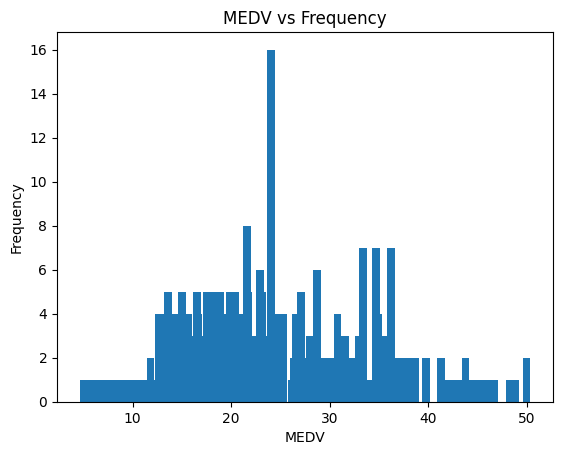

Train set size:  (354, 13)
Validation set size:  (76, 13)
Test set size:  (76, 13)
Train labels size:  (354, 1)
Validation labels size:  (76, 1)
Test labels size:  (76, 1)


In [20]:
print(house_data.describe())

plt.bar(labels_house.unique(), labels_house.value_counts())
plt.xlabel('MEDV')
plt.ylabel('Frequency')
plt.title('MEDV vs Frequency')
plt.show()

house_data = house_data.drop(columns=['MEDV'])

house_data = house_data.values
labels_house = labels_house.values


imputer = SimpleImputer(strategy='mean')
house_data = imputer.fit_transform(house_data)

scaler = StandardScaler()
house_data = scaler.fit_transform(house_data)

scaler = MinMaxScaler()
house_data = scaler.fit_transform(house_data)


X_train, X_temp, Y_train, Y_temp = train_test_split(house_data, labels_house, test_size=0.3, random_state=42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print('Train set size: ', X_train.shape)
print('Validation set size: ', X_valid.shape)
print('Test set size: ', X_test.shape)

Y_train = Y_train.reshape(-1, 1)
Y_valid = Y_valid.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

print('Train labels size: ', Y_train.shape)
print('Validation labels size: ', Y_valid.shape)
print('Test labels size: ', Y_test.shape)

### 3.2

MLP Regression

In [24]:
from sklearn.metrics import mean_squared_error, r2_score

class MlpRegressor:
    def __init__(self, input_size, output_size, num_layers, learning_rate, epochs, neurons_per_layer, activation_function, optimizer, num_samples):
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_hidden_layers = num_layers
        self.epochs = epochs
        self.batch_size = None
        self.neurons_per_layer = neurons_per_layer
        self.activation_function = activation_function
        self.optimizer = optimizer 
        self.num_samples = num_samples

        self.initialize_parameters()

    def initialize_parameters(self):
        if self.optimizer == 'sgd':
            self.batch_size = 1
        elif self.optimizer == 'mini-batch':
            self.batch_size = 10
        else:
            self.batch_size = self.num_samples

        self.weights = []
        self.biases = []

        # Input layer
        self.weights.append(np.random.randn(self.input_size, self.neurons_per_layer))
        self.biases.append(np.zeros((1, self.neurons_per_layer)))

        # Hidden layers
        for i in range(1, self.num_hidden_layers):
            self.weights.append(np.random.randn(self.neurons_per_layer, self.neurons_per_layer))
            self.biases.append(np.zeros((1, self.neurons_per_layer)))

        # Output layer
        self.weights.append(np.random.randn(self.neurons_per_layer, self.output_size))
        self.biases.append(np.zeros((1, self.output_size)))

    def forward_propagation(self, x):
        self.activations = []
        self.z_values = []

        a = x
        self.activations.append(a)

        for i in range(self.num_hidden_layers):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            self.z_values.append(z)

            if self.activation_function == 'sigmoid':
                a = sigmoid(z)
            elif self.activation_function == 'relu':
                a = relu(z)
            else:
                a = tanh(z)

            self.activations.append(a)

        # Output layer
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        a = z
        self.z_values.append(z)
        self.activations.append(a)

        return a

    def backward_propagation(self, x, y, output):
        m = x.shape[0]
        delta = output - y

        self.delta_weights = [0] * (self.num_hidden_layers + 1)
        self.delta_biases = [0] * (self.num_hidden_layers + 1)

        self.delta_weights[-1] = 1/m * np.dot(self.activations[-2].T, delta)
        self.delta_biases[-1] = 1/m * np.sum(delta, axis=0, keepdims=True)

        for i in range(self.num_hidden_layers - 1, 0, -1):
            if self.activation_function == 'sigmoid':
                delta = np.dot(delta, self.weights[i + 1].T) * sigmoid_derivative(self.z_values[i])
            elif self.activation_function == 'relu':
                delta = np.dot(delta, self.weights[i + 1].T) * relu_derivative(self.z_values[i])
            else:
                delta = np.dot(delta, self.weights[i + 1].T) * tanh_derivative(self.z_values[i])
        
            self.delta_weights[i] = 1/m * np.dot(self.activations[i].T, delta)
            self.delta_biases[i] = 1/m * np.sum(delta, axis=0, keepdims=True)

        if self.activation_function == 'sigmoid':
            delta = np.dot(delta, self.weights[1].T) * sigmoid_derivative(self.z_values[0])
        elif self.activation_function == 'relu':
            delta = np.dot(delta, self.weights[1].T) * relu_derivative(self.z_values[0])
        else:
            delta = np.dot(delta, self.weights[1].T) * tanh_derivative(self.z_values[0])
        
        self.delta_weights[0] = 1/m * np.dot(x.T, delta)
        self.delta_biases[0] = 1/m * np.sum(delta, axis=0, keepdims=True)

    def gradient_descent(self):
        for i in range(self.num_hidden_layers + 1):
            self.weights[i] -= self.learning_rate * self.delta_weights[i]
            self.biases[i] -= self.learning_rate * np.squeeze(self.delta_biases[i])

    def loss(self, y_true, y_pred):
        return 0.5 * np.mean((y_true - y_pred)**2)

    def train(self, X, y, x_valid, y_valid):
        for epoch in range(self.epochs):
            for i in range(0, X.shape[0], self.batch_size):
                x_batch = X[i:i + self.batch_size]
                y_batch = y[i:i + self.batch_size]

                output = self.forward_propagation(x_batch)
                self.backward_propagation(x_batch, y_batch, output)
                self.gradient_descent()

            loss = self.loss(y, self.forward_propagation(X))
            val_loss, y_true, y_pred = self.predict(x_valid, y_valid)

            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch + 1}, loss = {loss}, val_loss = {val_loss}')

            if epoch == self.epochs - 1:
                mse = mean_squared_error(y_true, y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_true, y_pred)

                print("MSE: ", mse)
                print("RMSE: ", rmse)
                print("R2 Score: ", r2)

                return val_loss, mse, rmse, r2

    def predict(self, X, y):
        y_pred = self.forward_propagation(X)
        loss = self.loss(y, y_pred)

        return loss, y, y_pred
    
    def test(self, X, y):
        y_pred = self.forward_propagation(X)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y, y_pred)

        print("MSE: ", mse)
        print("RMSE: ", rmse)
        print("R2 Score: ", r2)

Train

In [29]:
scores3_1 = {}

def train():
    config_defaults = {
        'learning_rate': 0.01,
        'epochs': 1000,
        'optimizer': 'mbgd',    
        'neurons_per_layer': 32,
        'number_of_layers': 1,
        'activation_function': 'sigmoid',
    }

    wandb.init(project="Task 3", entity="siyaputtagunta", config=config_defaults)
    config = wandb.config

    model = MlpRegressor(X_train.shape[1], Y_train.shape[1], num_layers=config.number_of_layers, learning_rate=config.learning_rate, epochs=config.epochs, neurons_per_layer=config.neurons_per_layer, activation_function=config.activation_function, optimizer=config.optimizer, num_samples=X_train.shape[0])
    val_loss, mse, rmse, r2 = model.train(X_train, Y_train, X_valid, Y_valid)
    scores3_1[(config.activation_function, config.optimizer)] = (val_loss, mse, rmse, r2)

    wandb.log({'val_loss': val_loss})

### 3.3

In [30]:
sweep_config = {
    'method': 'grid',
    'name': 'hyperparameter-tuning',
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'
    },
    'parameters': {
        'optimizer': {
            'values': ['sgd', 'bgd', 'mbgd']
        },
        'activation_function': {
            'values': ['sigmoid', 'relu', 'tanh']
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="Task3", entity="siyaputtagunta")
wandb.agent(sweep_id, train)

Create sweep with ID: ioo4obnv
Sweep URL: https://wandb.ai/siyaputtagunta/Task3/sweeps/ioo4obnv


wandb: Agent Starting Run: fh85bsgu with config:
wandb: 	activation_function: sigmoid
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.401545178874464, val_loss = 3.642706319029487
Epoch 200, loss = 3.5220807480348855, val_loss = 3.054615085937585
Epoch 300, loss = 3.019095168321461, val_loss = 3.1576044878648695
Epoch 400, loss = 2.5938232384806135, val_loss = 3.1711498404676317
Epoch 500, loss = 2.3631432128627896, val_loss = 3.3000466138333877
Epoch 600, loss = 2.281423734500632, val_loss = 3.4821302159331036
Epoch 700, loss = 2.1942094216714287, val_loss = 3.690712922344779
Epoch 800, loss = 2.079498532150166, val_loss = 3.954421380024264
Epoch 900, loss = 1.9440199869311263, val_loss = 4.160150424755393
Epoch 1000, loss = 1.8118255054954804, val_loss = 4.318476901150629
MSE:  8.636953802301258
RMSE:  2.938869476907959
R2 Score:  0.875494345520955


val_loss,▁
val_loss,4.31848


wandb: Agent Starting Run: kllngctl with config:
wandb: 	activation_function: sigmoid
wandb: 	optimizer: bgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 29.761871914216307, val_loss = 22.281831869613296
Epoch 200, loss = 22.988587551166585, val_loss = 16.47534932500688
Epoch 300, loss = 18.863363523705868, val_loss = 12.965490966257214
Epoch 400, loss = 16.14444925363712, val_loss = 10.749252796920189
Epoch 500, loss = 14.347910428566784, val_loss = 9.344230567219023
Epoch 600, loss = 13.105864543200074, val_loss = 8.394897066797466
Epoch 700, loss = 12.212090049709781, val_loss = 7.704673160511974
Epoch 800, loss = 11.548984328653182, val_loss = 7.175359464161637
Epoch 900, loss = 11.042849730734257, val_loss = 6.7613609313512315
Epoch 1000, loss = 10.644833741127506, val_loss = 6.435067673746438
MSE:  12.870135347492877
RMSE:  3.587497086757406
R2 Score:  0.8144710899985892


val_loss,▁
val_loss,6.43507


wandb: Agent Starting Run: 73btk6if with config:
wandb: 	activation_function: sigmoid
wandb: 	optimizer: mbgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 30.901900530466445, val_loss = 23.375516582025288
Epoch 200, loss = 24.797127216485173, val_loss = 18.05104184730084
Epoch 300, loss = 21.0017391834538, val_loss = 14.971334379473197
Epoch 400, loss = 17.92648370129548, val_loss = 12.589006751182206
Epoch 500, loss = 15.596533815506634, val_loss = 10.79670776531552
Epoch 600, loss = 14.062351704326018, val_loss = 9.597674089623077
Epoch 700, loss = 13.010429687613176, val_loss = 8.742902899127307
Epoch 800, loss = 12.23414639652411, val_loss = 8.083417595796782
Epoch 900, loss = 11.636217441174136, val_loss = 7.55647891051952
Epoch 1000, loss = 11.16349095146987, val_loss = 7.129168750416371
MSE:  14.258337500832742
RMSE:  3.7760213851132702
R2 Score:  0.7944595186035046


val_loss,▁
val_loss,7.12917


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: av8l1ulo with config:
wandb: 	activation_function: relu
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 8.518362753863327, val_loss = 4.30449010277919
Epoch 200, loss = 6.3231837559177455, val_loss = 4.1241838470484975
Epoch 300, loss = 5.644172795808458, val_loss = 4.169524806348058
Epoch 400, loss = 5.3443115888755175, val_loss = 3.819025464973559
Epoch 500, loss = 5.328777693990031, val_loss = 3.79810038641541
Epoch 600, loss = 4.416333877694275, val_loss = 4.09473654416319
Epoch 700, loss = 4.173008243958148, val_loss = 4.160485934164114
Epoch 800, loss = 4.284578829706868, val_loss = 4.308418316800531
Epoch 900, loss = 4.6106357755631855, val_loss = 4.1758915892721475
Epoch 1000, loss = 4.851514297848996, val_loss = 4.464995104983756
MSE:  8.929990209967512
RMSE:  2.9883089214416088
R2 Score:  0.8712700911648701


val_loss,▁
val_loss,4.465


wandb: Agent Starting Run: s3yw4apx with config:
wandb: 	activation_function: relu
wandb: 	optimizer: bgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 15.061639565286304, val_loss = 11.185744273017772
Epoch 200, loss = 11.631985815089887, val_loss = 8.30571096683123
Epoch 300, loss = 10.161120209137001, val_loss = 6.939127322071499
Epoch 400, loss = 9.285802604154004, val_loss = 6.249531900182633
Epoch 500, loss = 8.603684679983322, val_loss = 5.749667004259396
Epoch 600, loss = 8.076411921767338, val_loss = 5.350016859474684
Epoch 700, loss = 7.626611445287222, val_loss = 5.042858077841972
Epoch 800, loss = 7.205973382878722, val_loss = 4.929173079254467
Epoch 900, loss = 6.892657650907952, val_loss = 4.9191953110805775
Epoch 1000, loss = 6.784275702842403, val_loss = 5.042814822104056
MSE:  10.085629644208112
RMSE:  3.1757880351509784
R2 Score:  0.8546110181403528


val_loss,▁
val_loss,5.04281


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ga37ip8 with config:
wandb: 	activation_function: relu
wandb: 	optimizer: mbgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 12.785540295453476, val_loss = 9.229596589331408
Epoch 200, loss = 9.593961988024125, val_loss = 6.520550395688525
Epoch 300, loss = 8.650006864029613, val_loss = 5.703090507198231
Epoch 400, loss = 8.116922675942563, val_loss = 5.404815758759064
Epoch 500, loss = 7.714735998062183, val_loss = 5.252224766036239
Epoch 600, loss = 7.456866290929806, val_loss = 5.258879802429785
Epoch 700, loss = 7.924143243311273, val_loss = 6.071356535015792
Epoch 800, loss = 7.405140058897818, val_loss = 5.70036177369756
Epoch 900, loss = 7.291565557726402, val_loss = 5.77610467403811
Epoch 1000, loss = 7.04931735517391, val_loss = 5.658741167632913
MSE:  11.317482335265826
RMSE:  3.364146598361288
R2 Score:  0.836853296027604


val_loss,▁
val_loss,5.65874


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zyb68gtd with config:
wandb: 	activation_function: tanh
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.191224106041962, val_loss = 4.666200455221976
Epoch 200, loss = 5.028802232790935, val_loss = 6.576868921295708
Epoch 300, loss = 3.2513708448016723, val_loss = 5.91261797022461
Epoch 400, loss = 3.3885613900594813, val_loss = 7.982481439263797
Epoch 500, loss = 3.5429967268958724, val_loss = 8.839642442708168
Epoch 600, loss = 3.300567104585252, val_loss = 9.510903315867555
Epoch 700, loss = 3.1878219062758038, val_loss = 9.801926861038146
Epoch 800, loss = 3.3418960378237084, val_loss = 9.656537053781253
Epoch 900, loss = 3.9613974813866295, val_loss = 8.807781532345183
Epoch 1000, loss = 3.186769193923073, val_loss = 9.972185875775644
MSE:  19.944371751551287
RMSE:  4.465912197026637
R2 Score:  0.7124927242937618


val_loss,▁
val_loss,9.97219


wandb: Agent Starting Run: 09iafdmm with config:
wandb: 	activation_function: tanh
wandb: 	optimizer: bgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 18.301939246276124, val_loss = 12.74956479300085
Epoch 200, loss = 12.181114241563746, val_loss = 7.789475593484158
Epoch 300, loss = 9.964216484489706, val_loss = 6.077860694397266
Epoch 400, loss = 8.768687005718757, val_loss = 5.361771197100994
Epoch 500, loss = 8.038476700093462, val_loss = 5.057430826731648
Epoch 600, loss = 7.537048701525004, val_loss = 4.894040183436468
Epoch 700, loss = 7.162620651303239, val_loss = 4.800252156452309
Epoch 800, loss = 6.86650417897176, val_loss = 4.742319298138978
Epoch 900, loss = 6.622159644833579, val_loss = 4.700846760186517
Epoch 1000, loss = 6.41353693691744, val_loss = 4.667088074453936
MSE:  9.334176148907872
RMSE:  3.0551883982674246
R2 Score:  0.8654435652842305


val_loss,▁
val_loss,4.66709


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dcipsfqs with config:
wandb: 	activation_function: tanh
wandb: 	optimizer: mbgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 16.165649852705368, val_loss = 12.024997252878986
Epoch 200, loss = 11.63245868145184, val_loss = 7.589624175766126
Epoch 300, loss = 9.918397481434022, val_loss = 6.59856881594495
Epoch 400, loss = 8.939481360058608, val_loss = 6.171333190088188
Epoch 500, loss = 8.325773626900334, val_loss = 5.924933511350177
Epoch 600, loss = 7.903839008032087, val_loss = 5.753992264495409
Epoch 700, loss = 7.588929520047268, val_loss = 5.624616482816087
Epoch 800, loss = 7.337276049153054, val_loss = 5.522500373705606
Epoch 900, loss = 7.124859559623651, val_loss = 5.43929131676151
Epoch 1000, loss = 6.937828018410502, val_loss = 5.368928350212453
MSE:  10.737856700424906
RMSE:  3.2768669030683726
R2 Score:  0.8452088656729427


val_loss,▁
val_loss,5.36893


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [35]:
def train():
    config_defaults = {
        'learning_rate': 0.01,
        'epochs': 1000,
        'optimizer': 'sgd',    
        'neurons_per_layer': 32,
        'number_of_layers': 1,
        'activation_function': 'sigmoid',
    }

    wandb.init(project="Task 3", entity="siyaputtagunta", config=config_defaults)
    config = wandb.config

    model = MlpRegressor(X_train.shape[1], Y_train.shape[1], num_layers=config.number_of_layers, learning_rate=config.learning_rate, epochs=config.epochs, neurons_per_layer=config.neurons_per_layer, activation_function=config.activation_function, optimizer=config.optimizer, num_samples=X_train.shape[0])
    val_loss, mse, rmse, r2 = model.train(X_train, Y_train, X_valid, Y_valid)

    wandb.log({'val_loss': val_loss})

In [32]:
sweep_config = {
    'method': 'grid',
    'name': 'hyperparameter-tuning',
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.01, 0.1]
        },
        'epochs': {
            'values': [1000, 2000, 3000]
        },
        'neurons_per_layer': {
            'values': [10, 32, 64]
        },
        'number_of_layers': {
            'values': [1, 2, 3]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project="Task3", entity="siyaputtagunta")
wandb.agent(sweep_id, train)

Create sweep with ID: c7464ly2
Sweep URL: https://wandb.ai/siyaputtagunta/Task3/sweeps/c7464ly2


wandb: Agent Starting Run: wiuy73se with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 7.675190102334947, val_loss = 4.530840059444683
Epoch 200, loss = 6.579013481131531, val_loss = 4.49947952249708
Epoch 300, loss = 5.743785589172656, val_loss = 4.247720457158632
Epoch 400, loss = 5.019110116105744, val_loss = 3.938756664680084
Epoch 500, loss = 4.539113048116383, val_loss = 3.687755476912853
Epoch 600, loss = 4.219974405064178, val_loss = 3.5415916560773755
Epoch 700, loss = 3.975231178953561, val_loss = 3.442386391464433
Epoch 800, loss = 3.766411518529844, val_loss = 3.357724548353563
Epoch 900, loss = 3.5613281721223617, val_loss = 3.2841601967393808
Epoch 1000, loss = 3.3673801657952387, val_loss = 3.307709348991315
MSE:  6.61541869798263
RMSE:  2.5720456251751505
R2 Score:  0.9046357021817366


val_loss,▁
val_loss,3.30771


wandb: Agent Starting Run: 6rrepwf7 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 6.389837944681368, val_loss = 4.1995055357110855
Epoch 200, loss = 5.118520282094795, val_loss = 3.580666932605744
Epoch 300, loss = 3.7391035004184077, val_loss = 3.1723983929753516
Epoch 400, loss = 3.3986581639968736, val_loss = 3.071928396482388
Epoch 500, loss = 3.2431304720086986, val_loss = 3.038846204272565
Epoch 600, loss = 3.1345489139553444, val_loss = 3.0384151374220734
Epoch 700, loss = 3.0302131337452636, val_loss = 3.0426814389401993
Epoch 800, loss = 2.9210133059379024, val_loss = 3.045572180623704
Epoch 900, loss = 2.802058365980337, val_loss = 3.051516743718736
Epoch 1000, loss = 2.6818175066149768, val_loss = 3.068360255619384
MSE:  6.136720511238768
RMSE:  2.4772405033098357
R2 Score:  0.911536356324705


val_loss,▁
val_loss,3.06836


wandb: Agent Starting Run: fj5qet22 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 6.367254758655032, val_loss = 4.690225363470177
Epoch 200, loss = 3.7895506865063724, val_loss = 3.424892689556796
Epoch 300, loss = 3.3721989959645704, val_loss = 3.3935235507105994
Epoch 400, loss = 3.1853528967016023, val_loss = 3.369006540199614
Epoch 500, loss = 3.079434472009167, val_loss = 3.29168995683827
Epoch 600, loss = 2.9801216168569566, val_loss = 3.179033446772544
Epoch 700, loss = 2.8573551844111758, val_loss = 3.1012904512200987
Epoch 800, loss = 2.718537696408875, val_loss = 3.094972785579852
Epoch 900, loss = 2.5866869756141306, val_loss = 3.1172058509473954
Epoch 1000, loss = 2.474325501199542, val_loss = 3.1382189568727803
MSE:  6.276437913745561
RMSE:  2.505282002838315
R2 Score:  0.9095222658201818


val_loss,▁
val_loss,3.13822


wandb: Agent Starting Run: qb4rjm8d with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 7.929167434894041, val_loss = 4.374363558250269
Epoch 200, loss = 6.164886652174656, val_loss = 3.8898055610007667
Epoch 300, loss = 5.14756975812581, val_loss = 3.467970692668328
Epoch 400, loss = 4.409531455187407, val_loss = 3.1329145284544793
Epoch 500, loss = 3.867567762539202, val_loss = 2.9362458055723426
Epoch 600, loss = 3.4807952990991757, val_loss = 2.821591870308086
Epoch 700, loss = 3.207781597945641, val_loss = 2.781368408460306
Epoch 800, loss = 3.006371501075658, val_loss = 2.7520153346156104
Epoch 900, loss = 2.8388182412759853, val_loss = 2.7106754638020845
Epoch 1000, loss = 2.6920479836948625, val_loss = 2.66207807577741
MSE:  5.32415615155482
RMSE:  2.3074133031502657
R2 Score:  0.92324984463604


val_loss,▁
val_loss,2.66208


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4gog0ilq with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 6.398457003232675, val_loss = 4.882857877407723
Epoch 200, loss = 4.326373377979284, val_loss = 3.346931310137818
Epoch 300, loss = 3.169463303988431, val_loss = 2.6333522558438758
Epoch 400, loss = 2.6977111728074483, val_loss = 2.5232399742997003
Epoch 500, loss = 2.452479256066713, val_loss = 2.5150650433601376
Epoch 600, loss = 2.287704578583144, val_loss = 2.51651403398005
Epoch 700, loss = 2.1582149101861785, val_loss = 2.5167315492217113
Epoch 800, loss = 2.0473715949275384, val_loss = 2.5199547566128557
Epoch 900, loss = 1.949264484676172, val_loss = 2.534049978846627
Epoch 1000, loss = 1.8610007511437234, val_loss = 2.5629712220749723
MSE:  5.125942444149945
RMSE:  2.264054426057365
R2 Score:  0.9261071862326323


val_loss,▁
val_loss,2.56297


wandb: Agent Starting Run: fmzw7906 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.153004507123068, val_loss = 3.996073939717305
Epoch 200, loss = 3.2887225890948764, val_loss = 3.1490905351324536
Epoch 300, loss = 2.8127195012572543, val_loss = 3.0062672288964913
Epoch 400, loss = 2.4573702304553864, val_loss = 2.844429634663672
Epoch 500, loss = 2.1713612942249916, val_loss = 2.684297097425271
Epoch 600, loss = 1.9186834854415016, val_loss = 2.5876307881465936
Epoch 700, loss = 1.6954259368203068, val_loss = 2.580218132545035
Epoch 800, loss = 1.5238903756795643, val_loss = 2.65070339526476
Epoch 900, loss = 1.3925970766402371, val_loss = 2.7008906520091758
Epoch 1000, loss = 1.2769338203537355, val_loss = 2.7157096835028285
MSE:  5.431419367005657
RMSE:  2.3305405739882876
R2 Score:  0.9217035961383724


val_loss,▁
val_loss,2.71571


wandb: Agent Starting Run: v13gld7f with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 7.771966453962265, val_loss = 4.411489862410132
Epoch 200, loss = 6.005601931552735, val_loss = 3.839168888030553
Epoch 300, loss = 4.865137620979871, val_loss = 3.572459200938315
Epoch 400, loss = 4.216859389717553, val_loss = 3.3422516650132192
Epoch 500, loss = 3.821417736571723, val_loss = 3.2138435068040407
Epoch 600, loss = 3.5342029397274968, val_loss = 3.1551659814828734
Epoch 700, loss = 3.299289533486672, val_loss = 3.12626688507178
Epoch 800, loss = 3.103152773755146, val_loss = 3.105894242271015
Epoch 900, loss = 2.9391493576738963, val_loss = 3.0861739176576157
Epoch 1000, loss = 2.7978085715585532, val_loss = 3.0638656567522324
MSE:  6.127731313504465
RMSE:  2.4754254813070955
R2 Score:  0.9116659397371869


val_loss,▁
val_loss,3.06387


wandb: Agent Starting Run: j5yxy9qo with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.947692506628775, val_loss = 3.772505666781633
Epoch 200, loss = 3.803162979038863, val_loss = 2.8690626502835177
Epoch 300, loss = 2.9274243029584226, val_loss = 2.496980597543997
Epoch 400, loss = 2.5020445010411234, val_loss = 2.385743836061394
Epoch 500, loss = 2.223228788760355, val_loss = 2.3933556174123876
Epoch 600, loss = 2.0131935583481977, val_loss = 2.4380234031608876
Epoch 700, loss = 1.8313315976664581, val_loss = 2.473906700374254
Epoch 800, loss = 1.6593969718835178, val_loss = 2.54383255051609
Epoch 900, loss = 1.514707699199481, val_loss = 2.682237448087614
Epoch 1000, loss = 1.3956186166843074, val_loss = 2.8785154230204633
MSE:  5.7570308460409265
RMSE:  2.399381346522667
R2 Score:  0.9170097571725585


val_loss,▁
val_loss,2.87852


wandb: Agent Starting Run: y36yb0mz with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 4.105524611144971, val_loss = 3.0097658422533042
Epoch 200, loss = 2.9788456218940653, val_loss = 2.532351582568001
Epoch 300, loss = 2.3967198952342526, val_loss = 2.3090646480779022
Epoch 400, loss = 1.9862850106865957, val_loss = 2.3537623587970598
Epoch 500, loss = 1.7082343490485714, val_loss = 2.5327968351036523
Epoch 600, loss = 1.5003653653042193, val_loss = 2.666649712861131
Epoch 700, loss = 1.374148644814005, val_loss = 2.776903372620221
Epoch 800, loss = 1.327730373488326, val_loss = 2.9320326380641104
Epoch 900, loss = 1.3126082056084738, val_loss = 3.0830777307809325
Epoch 1000, loss = 1.2571750237256412, val_loss = 3.205778490212646
MSE:  6.411556980425292
RMSE:  2.5321052467117737
R2 Score:  0.9075744624378046


val_loss,▁
val_loss,3.20578


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fzkn7ajt with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.68162343288581, val_loss = 4.741273705856242
Epoch 200, loss = 4.798834585362034, val_loss = 3.5912462013628015
Epoch 300, loss = 4.297447422282097, val_loss = 3.3246038783970833
Epoch 400, loss = 4.045400517443921, val_loss = 3.6915484771066382
Epoch 500, loss = 3.702928646407592, val_loss = 3.8927123463550393
Epoch 600, loss = 3.473650037906021, val_loss = 4.047802784647029
Epoch 700, loss = 3.1633186980689665, val_loss = 4.151709388611906
Epoch 800, loss = 2.9803180563278424, val_loss = 4.26971183175757
Epoch 900, loss = 2.9128837138842085, val_loss = 4.354318218111407
Epoch 1000, loss = 2.8814554608741063, val_loss = 4.401500325485308
MSE:  8.803000650970615
RMSE:  2.96698511134967
R2 Score:  0.8731007039615601


val_loss,▁
val_loss,4.4015


wandb: Agent Starting Run: j4ks2mxw with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.92666956874268, val_loss = 3.335063361556603
Epoch 200, loss = 2.9545993595900057, val_loss = 3.065323106400808
Epoch 300, loss = 2.5805821630609573, val_loss = 3.6159387352169867
Epoch 400, loss = 2.62786408933552, val_loss = 4.095628815846911
Epoch 500, loss = 2.5948840156120956, val_loss = 4.492698555139088
Epoch 600, loss = 2.5515866380670547, val_loss = 4.7466187769663195
Epoch 700, loss = 2.278927129682686, val_loss = 4.6774486018046195
Epoch 800, loss = 1.9877259206046483, val_loss = 4.673183884481148
Epoch 900, loss = 1.8075305165385036, val_loss = 4.720341278919712
Epoch 1000, loss = 1.661356044081902, val_loss = 4.806825689551558
MSE:  9.613651379103116
RMSE:  3.100588876181929
R2 Score:  0.8614148015276304


val_loss,▁
val_loss,4.80683


wandb: Agent Starting Run: kapcckt7 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 4.49703631752576, val_loss = 2.9940993722928284
Epoch 200, loss = 3.2029961584345443, val_loss = 3.360459021615883
Epoch 300, loss = 2.8965911852899313, val_loss = 3.5282251630463306
Epoch 400, loss = 2.838178234270409, val_loss = 4.096509876673888
Epoch 500, loss = 2.2702997598681405, val_loss = 3.973300991780602
Epoch 600, loss = 2.3663845227769293, val_loss = 4.574880862014228
Epoch 700, loss = 1.6133867420671626, val_loss = 4.628474334746483
Epoch 800, loss = 1.5648559669977502, val_loss = 4.5507219189183905
Epoch 900, loss = 1.512810711010317, val_loss = 5.069079634461475
Epoch 1000, loss = 1.5105670160975788, val_loss = 4.812071322837068
MSE:  9.624142645674135
RMSE:  3.102280233259745
R2 Score:  0.8612635651032338


val_loss,▁
val_loss,4.81207


wandb: Agent Starting Run: 25zaztdc with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.227334138947033, val_loss = 3.825493980724416
Epoch 200, loss = 3.2867670661930313, val_loss = 2.547304853164825
Epoch 300, loss = 2.8477771152494973, val_loss = 2.5790883863114105
Epoch 400, loss = 2.63201193520558, val_loss = 2.8564883212959087
Epoch 500, loss = 2.4689786141342593, val_loss = 3.12178570721816
Epoch 600, loss = 2.271123970502187, val_loss = 3.3212892716321387
Epoch 700, loss = 2.0625301356686734, val_loss = 3.4454437191854113
Epoch 800, loss = 1.8911057879766002, val_loss = 3.5435785882832294
Epoch 900, loss = 1.768037871963994, val_loss = 3.653241901146573
Epoch 1000, loss = 1.6762291243248322, val_loss = 3.7746855670106063
MSE:  7.549371134021213
RMSE:  2.74761189654238
R2 Score:  0.8911723490177659


val_loss,▁
val_loss,3.77469


wandb: Agent Starting Run: vjrgn7lz with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.3784530783809457, val_loss = 3.3234136858771777
Epoch 200, loss = 2.516192278400246, val_loss = 3.2274573956801422
Epoch 300, loss = 2.1081951698663985, val_loss = 3.4974744602459875
Epoch 400, loss = 1.819855848894293, val_loss = 3.98895665199817
Epoch 500, loss = 1.9069931125136974, val_loss = 4.585277525416044
Epoch 600, loss = 1.8220186081243837, val_loss = 5.1113810179948835
Epoch 700, loss = 1.7550664425861708, val_loss = 5.176514580169361
Epoch 800, loss = 1.5032361965552052, val_loss = 4.8343533917592945
Epoch 900, loss = 1.3086130712803854, val_loss = 4.665128434125673
Epoch 1000, loss = 1.1137548569677158, val_loss = 4.62141801446749
MSE:  9.24283602893498
RMSE:  3.040203287435723
R2 Score:  0.8667602750499339


val_loss,▁
val_loss,4.62142


wandb: Agent Starting Run: 8pxs487j with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.4756668384839493, val_loss = 4.190608658434198
Epoch 200, loss = 2.50295227124418, val_loss = 4.281919299951971
Epoch 300, loss = 2.3177666320635804, val_loss = 4.202491668800585
Epoch 400, loss = 1.6172571719215618, val_loss = 4.522069203899111
Epoch 500, loss = 1.6092671212246132, val_loss = 4.398711328024468
Epoch 600, loss = 0.9728227109324248, val_loss = 4.79678023800931
Epoch 700, loss = 0.625632575387689, val_loss = 4.938488474013992
Epoch 800, loss = 0.4581264486724096, val_loss = 4.758082352556001
Epoch 900, loss = 0.3481071615880261, val_loss = 4.686411784940905
Epoch 1000, loss = 0.29449061237622237, val_loss = 4.462005831879138
MSE:  8.924011663758275
RMSE:  2.987308431307065
R2 Score:  0.8713562746533606


val_loss,▁
val_loss,4.46201


wandb: Agent Starting Run: nn3xadu0 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 4.874376264736752, val_loss = 3.4459878841568465
Epoch 200, loss = 3.682028674137768, val_loss = 3.0268451131369662
Epoch 300, loss = 3.2368794529858276, val_loss = 2.907022707459487
Epoch 400, loss = 2.9047991406062397, val_loss = 2.8970376878918316
Epoch 500, loss = 2.621821655566739, val_loss = 2.9565399408616715
Epoch 600, loss = 2.364433699359511, val_loss = 3.0172969216080587
Epoch 700, loss = 2.203439042222506, val_loss = 3.1254060829787678
Epoch 800, loss = 2.1146656619206183, val_loss = 3.299987021738762
Epoch 900, loss = 2.0729498402408426, val_loss = 3.5291164472662646
Epoch 1000, loss = 2.049142911256669, val_loss = 3.7857215473221655
MSE:  7.571443094644331
RMSE:  2.7516255367771847
R2 Score:  0.8908541715716523


val_loss,▁
val_loss,3.78572


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ft22gexz with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.1550353110275355, val_loss = 3.5162243815045846
Epoch 200, loss = 2.053236836608619, val_loss = 3.480084613180502
Epoch 300, loss = 1.6949487352114425, val_loss = 4.014133504656926
Epoch 400, loss = 1.4051927400370856, val_loss = 4.5809657355703095
Epoch 500, loss = 1.2934883205400618, val_loss = 5.336830083133481
Epoch 600, loss = 1.0777940254237648, val_loss = 5.6960858073526985
Epoch 700, loss = 0.9920744547295047, val_loss = 6.053032557218299
Epoch 800, loss = 1.5407132091244353, val_loss = 6.814211766231577
Epoch 900, loss = 0.7842038035113608, val_loss = 5.4623371741861275
Epoch 1000, loss = 0.6766586120806067, val_loss = 5.790069936228191
MSE:  11.580139872456382
RMSE:  3.4029604570809195
R2 Score:  0.833066967037046


val_loss,▁
val_loss,5.79007


wandb: Agent Starting Run: zhih99x6 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.1315441878224073, val_loss = 2.600459069762668
Epoch 200, loss = 2.7533303829610327, val_loss = 2.211390472830491
Epoch 300, loss = 2.2581129442613674, val_loss = 2.9657675671272328
Epoch 400, loss = 1.0434424197172356, val_loss = 3.420251195017446
Epoch 500, loss = 0.8499231236816187, val_loss = 3.5781150499355534
Epoch 600, loss = 0.38732224560298895, val_loss = 4.130468950041626
Epoch 700, loss = 0.39293620511488453, val_loss = 4.197305465198215
Epoch 800, loss = 0.40519070283383934, val_loss = 4.286281093577095
Epoch 900, loss = 0.33148106287153706, val_loss = 3.9838044421333754
Epoch 1000, loss = 0.32948263633990615, val_loss = 4.159791985087383
MSE:  8.319583970174765
RMSE:  2.884368903274123
R2 Score:  0.8800693773626542


val_loss,▁
val_loss,4.15979


wandb: Agent Starting Run: r3pwclm5 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 24.640979104451528, val_loss = 12.273468657075481
Epoch 200, loss = 17.690379889492686, val_loss = 9.58014069656838
Epoch 300, loss = 13.7677446854934, val_loss = 7.415781180597172
Epoch 400, loss = 11.023745619027325, val_loss = 8.95124766400578
Epoch 500, loss = 12.550111079267435, val_loss = 6.409432637361843
Epoch 600, loss = 10.30684212869577, val_loss = 5.809917566779899
Epoch 700, loss = 24.512411598460073, val_loss = 16.35056032693638
Epoch 800, loss = 11.526947867730197, val_loss = 6.230743580240354
Epoch 900, loss = 10.646262305341102, val_loss = 5.768357330102145
Epoch 1000, loss = 11.38220951313523, val_loss = 5.7810422016936
MSE:  11.5620844033872
RMSE:  3.4003065160933947
R2 Score:  0.8333272449133483


val_loss,▁
val_loss,5.78104


wandb: Agent Starting Run: ltve5hk9 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 56.19015280858306, val_loss = 41.30086812925373
Epoch 200, loss = 54.93158720066651, val_loss = 40.38478221711559
Epoch 300, loss = 53.55011518069873, val_loss = 40.384858811757304
Epoch 400, loss = 53.541279125424076, val_loss = 40.38475560932581
Epoch 500, loss = 53.540904745606966, val_loss = 40.38468772125947
Epoch 600, loss = 54.93162499817688, val_loss = 40.38472418369616
Epoch 700, loss = 54.931680780268415, val_loss = 40.3847659955925
Epoch 800, loss = 54.9316752170079, val_loss = 40.38476280099638
Epoch 900, loss = 54.93165141377206, val_loss = 40.384749093683546
Epoch 1000, loss = 54.931712523694664, val_loss = 40.384789093994875
MSE:  80.76957818798975
RMSE:  8.987189671303803
R2 Score:  -0.16433055270165275


val_loss,▁
val_loss,40.38479


wandb: Agent Starting Run: tg62rbpl with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 53.29507660565089, val_loss = 39.2242419508914
Epoch 200, loss = 53.2950541090413, val_loss = 39.2242224295186
Epoch 300, loss = 53.2948087162875, val_loss = 39.22400521794179
Epoch 400, loss = 53.29506435329746, val_loss = 39.22423189086978
Epoch 500, loss = 53.29506238875901, val_loss = 39.22423017362244
Epoch 600, loss = 53.29506090401176, val_loss = 39.22422886586591
Epoch 700, loss = 53.29505967939961, val_loss = 39.224227776928046
Epoch 800, loss = 53.29505859092908, val_loss = 39.2242267984917
Epoch 900, loss = 53.29505755580585, val_loss = 39.22422585727678
Epoch 1000, loss = 53.295056506615154, val_loss = 39.22422489239191
MSE:  78.44844978478382
RMSE:  8.857112948629695
R2 Score:  -0.1308704210874192


val_loss,▁
val_loss,39.22422


wandb: Agent Starting Run: ih6fwvhp with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 9.240015510352022, val_loss = 6.070936230713483
Epoch 200, loss = 10.754123288845838, val_loss = 9.045219327846608
Epoch 300, loss = 11.52856523663744, val_loss = 11.067750519116885
Epoch 400, loss = 11.76012704473216, val_loss = 11.160979289820673
Epoch 500, loss = 12.310167054301086, val_loss = 13.101845070338202
Epoch 600, loss = 9.590988144933581, val_loss = 10.623285496354136
Epoch 700, loss = 8.638089156094308, val_loss = 11.765377740168981
Epoch 800, loss = 9.605899577009547, val_loss = 12.182490132344872
Epoch 900, loss = 9.337191066002854, val_loss = 11.263143031021656
Epoch 1000, loss = 9.116224451003262, val_loss = 10.639926169470066
MSE:  21.27985233894013
RMSE:  4.613009033043414
R2 Score:  0.6932411584775124


val_loss,▁
val_loss,10.63993


wandb: Agent Starting Run: usl5g5r6 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 44.009231684306556, val_loss = 35.14543884381385
Epoch 200, loss = 44.009344703985676, val_loss = 35.14485758385566
Epoch 300, loss = 45.51967079558205, val_loss = 34.789451719452664
Epoch 400, loss = 45.52193668943792, val_loss = 34.790979866311105
Epoch 500, loss = 45.521899795823266, val_loss = 34.79077517413168
Epoch 600, loss = 44.0093470423261, val_loss = 35.14658002038342
Epoch 700, loss = 45.522103178138906, val_loss = 34.792436762936916
Epoch 800, loss = 45.52210265544352, val_loss = 34.79243555150486
Epoch 900, loss = 45.5221019555601, val_loss = 34.79243406412378
Epoch 1000, loss = 45.52210096307428, val_loss = 34.79243216119636
MSE:  69.58486432239272
RMSE:  8.341754271278477
R2 Score:  -0.0030977671765095582


val_loss,▁
val_loss,34.79243


wandb: Agent Starting Run: dst9og9w with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 51.098353430260275, val_loss = 37.73786151236951
Epoch 200, loss = 51.09853954818796, val_loss = 37.73805287166399
Epoch 300, loss = 51.098467603410086, val_loss = 37.73797890057208
Epoch 400, loss = 51.09847687744886, val_loss = 37.73798581323629
Epoch 500, loss = 51.09846343802017, val_loss = 37.7379761334851
Epoch 600, loss = 51.098489656647544, val_loss = 37.737997444271215
Epoch 700, loss = 53.698026928957844, val_loss = 39.50634708647704
Epoch 800, loss = 53.69799707646757, val_loss = 39.506317908831186
Epoch 900, loss = 53.697956104900705, val_loss = 39.50627529781464
Epoch 1000, loss = 53.698011084599756, val_loss = 39.50632818961361
MSE:  79.01265637922722
RMSE:  8.888906365758794
R2 Score:  -0.13900371818620116


val_loss,▁
val_loss,39.50633


wandb: Agent Starting Run: rj8goix9 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 11.46359627538978, val_loss = 11.734306130676044
Epoch 200, loss = 16.980703944532703, val_loss = 17.095015544006124
Epoch 300, loss = 9.956487696531026, val_loss = 9.834965589567446
Epoch 400, loss = 8.866817203377819, val_loss = 6.511928519768611
Epoch 500, loss = 10.407679181377267, val_loss = 10.183655269637626
Epoch 600, loss = 10.6114183650017, val_loss = 9.584409610233221
Epoch 700, loss = 8.88218401253262, val_loss = 8.362266010503012
Epoch 800, loss = 9.43046060394095, val_loss = 8.188383205477894
Epoch 900, loss = 9.866520481243398, val_loss = 7.428276102724654
Epoch 1000, loss = 11.930250591238947, val_loss = 10.239765533473792
MSE:  20.479531066947583
RMSE:  4.525431589025248
R2 Score:  0.7047781570587002


val_loss,▁
val_loss,10.23977


wandb: Agent Starting Run: 7pe2mbe2 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 56.65166148856191, val_loss = 41.64123345272079
Epoch 200, loss = 56.651923799545145, val_loss = 41.64147570912059
Epoch 300, loss = 56.65192139584749, val_loss = 41.64147571801787
Epoch 400, loss = 56.651922023498955, val_loss = 41.641475976994855
Epoch 500, loss = 56.65192600096881, val_loss = 41.641480517249946
Epoch 600, loss = 56.65191633368625, val_loss = 41.64147212679777
Epoch 700, loss = 56.65189155997789, val_loss = 41.641450716761454
Epoch 800, loss = 56.651912057372904, val_loss = 41.641468217347644
Epoch 900, loss = 56.65191672329314, val_loss = 41.64147110384669
Epoch 1000, loss = 56.65185078870166, val_loss = 41.64141397383931
MSE:  83.28282794767863
RMSE:  9.12594257858763
R2 Score:  -0.20056020187680446


val_loss,▁
val_loss,41.64141


wandb: Agent Starting Run: 829kdjx4 with config:
wandb: 	epochs: 1000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 56.652041474055785, val_loss = 41.64156646297205
Epoch 200, loss = 55.604711170256856, val_loss = 40.87240307174791
Epoch 300, loss = 53.697909605922526, val_loss = 39.506229063538484
Epoch 400, loss = 53.69814334791619, val_loss = 39.506442794439764
Epoch 500, loss = 51.09848748643821, val_loss = 37.73799560528363
Epoch 600, loss = 51.098450198378494, val_loss = 37.737966264436885
Epoch 700, loss = 51.09846866454915, val_loss = 37.737981808633386
Epoch 800, loss = 51.09826740870308, val_loss = 37.73777900768628
Epoch 900, loss = 51.09236132649879, val_loss = 37.733504722708346
Epoch 1000, loss = 51.096486646141464, val_loss = 37.735609532025414
MSE:  75.47121906405083
RMSE:  8.687417283868136
R2 Score:  -0.08795227333476885


val_loss,▁
val_loss,37.73561


wandb: Agent Starting Run: z7eyxpak with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 8.127267962368169, val_loss = 4.50152407699623
Epoch 200, loss = 6.664817256018891, val_loss = 4.3801366220887825
Epoch 300, loss = 6.004992574889448, val_loss = 4.220353473170448
Epoch 400, loss = 5.381689250053602, val_loss = 4.045223491541462
Epoch 500, loss = 4.890700769083374, val_loss = 3.782268707875852
Epoch 600, loss = 4.586533986984213, val_loss = 3.6788975154875616
Epoch 700, loss = 4.35913112826076, val_loss = 3.7386888329326906
Epoch 800, loss = 4.1600216567612565, val_loss = 3.918782417816458
Epoch 900, loss = 3.9916851314493758, val_loss = 4.127033289947171
Epoch 1000, loss = 3.8523449274964796, val_loss = 4.295598967377206
Epoch 1100, loss = 3.725544297927664, val_loss = 4.438656803002331
Epoch 1200, loss = 3.5909330768145504, val_loss = 4.544235322377724
Epoch 1300, loss = 3.453544865001247, val_loss = 4.557434073315909
Epoch 1400, loss = 3.2990075911422645, val_loss = 4.499809386324082
Epoch 1500, loss = 3.1342553992860642, val_loss = 4.4086689368329

val_loss,▁
val_loss,3.85014


wandb: Agent Starting Run: f4baydei with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 6.5022599943614905, val_loss = 5.387087036245919
Epoch 200, loss = 5.129138606776875, val_loss = 4.398456502340894
Epoch 300, loss = 4.126392831562104, val_loss = 3.7485001035878973
Epoch 400, loss = 3.5047537156428095, val_loss = 3.4014965903977203
Epoch 500, loss = 3.124193218530838, val_loss = 3.212683030977284
Epoch 600, loss = 2.86191330898579, val_loss = 3.0917731188884883
Epoch 700, loss = 2.6689775160915112, val_loss = 3.042944678255412
Epoch 800, loss = 2.517761812372041, val_loss = 3.031559037582604
Epoch 900, loss = 2.393560377419606, val_loss = 3.027494095661321
Epoch 1000, loss = 2.2916972949778724, val_loss = 3.032190752167793
Epoch 1100, loss = 2.2078424083010675, val_loss = 3.0453719079743053
Epoch 1200, loss = 2.1371911178094174, val_loss = 3.0644033529686463
Epoch 1300, loss = 2.0757231987980864, val_loss = 3.0930047683424657
Epoch 1400, loss = 2.020363048234651, val_loss = 3.1392009409417425
Epoch 1500, loss = 1.9691334114726151, val_loss = 3.208526

val_loss,▁
val_loss,3.69214


wandb: Agent Starting Run: ffobt70b with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.183973154560459, val_loss = 3.5058988801852315
Epoch 200, loss = 3.5971187567983987, val_loss = 2.797010764340255
Epoch 300, loss = 3.109852940948317, val_loss = 2.7418826027412
Epoch 400, loss = 2.8830340714717253, val_loss = 2.7896910953524867
Epoch 500, loss = 2.716245868154361, val_loss = 2.8320789502990276
Epoch 600, loss = 2.585875919409501, val_loss = 2.855287043618429
Epoch 700, loss = 2.479939188587702, val_loss = 2.876239232720451
Epoch 800, loss = 2.392716869737526, val_loss = 2.910654432108467
Epoch 900, loss = 2.3223393476361878, val_loss = 2.958869207055707
Epoch 1000, loss = 2.2664751890289945, val_loss = 3.0137528985613535
Epoch 1100, loss = 2.2206969383698203, val_loss = 3.0732343141540257
Epoch 1200, loss = 2.1808046083489536, val_loss = 3.1402909246415605
Epoch 1300, loss = 2.14384236833991, val_loss = 3.2166346827235777
Epoch 1400, loss = 2.1069297709543324, val_loss = 3.294966985188469
Epoch 1500, loss = 2.0638284662803885, val_loss = 3.35465734

val_loss,▁
val_loss,3.30681


wandb: Agent Starting Run: uo2iwxtv with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 7.426496760507169, val_loss = 4.768190146736427
Epoch 200, loss = 6.00185249503308, val_loss = 4.23285857640311
Epoch 300, loss = 5.077299731303502, val_loss = 3.8122771245624683
Epoch 400, loss = 4.427480927339294, val_loss = 3.391366300979739
Epoch 500, loss = 3.972365787800094, val_loss = 3.083463433681905
Epoch 600, loss = 3.6374322745564367, val_loss = 2.9090522700862174
Epoch 700, loss = 3.389828262763037, val_loss = 2.809345239515014
Epoch 800, loss = 3.2004460448660876, val_loss = 2.742689171027439
Epoch 900, loss = 3.0511398904004956, val_loss = 2.684682167846055
Epoch 1000, loss = 2.9290947879191886, val_loss = 2.63061537473617
Epoch 1100, loss = 2.8258165277783154, val_loss = 2.5836926984062067
Epoch 1200, loss = 2.7354708606686087, val_loss = 2.5466674766695423
Epoch 1300, loss = 2.654004530245152, val_loss = 2.519961135322035
Epoch 1400, loss = 2.578815128105964, val_loss = 2.5025869620930465
Epoch 1500, loss = 2.5084991199015074, val_loss = 2.49324552214

val_loss,▁
val_loss,2.53793


wandb: Agent Starting Run: 20wim4ow with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 6.506914834708242, val_loss = 4.784853466253356
Epoch 200, loss = 4.746589768597804, val_loss = 3.459769323040193
Epoch 300, loss = 3.4260796754260143, val_loss = 2.748069411697886
Epoch 400, loss = 2.877853728097504, val_loss = 2.588771654269516
Epoch 500, loss = 2.591885745165694, val_loss = 2.584476229365229
Epoch 600, loss = 2.3757655279183525, val_loss = 2.6367753967589556
Epoch 700, loss = 2.1952482668572917, val_loss = 2.7328506813364832
Epoch 800, loss = 2.039529045551506, val_loss = 2.8365475047700173
Epoch 900, loss = 1.9026107657880718, val_loss = 2.9299325450237172
Epoch 1000, loss = 1.7825537362493744, val_loss = 3.031661989422466
Epoch 1100, loss = 1.673684042428108, val_loss = 3.1629188860437414
Epoch 1200, loss = 1.576388989036866, val_loss = 3.3047493569987414
Epoch 1300, loss = 1.4915613672715133, val_loss = 3.4405990814537697
Epoch 1400, loss = 1.416948746136176, val_loss = 3.56793845874278
Epoch 1500, loss = 1.3510243433223121, val_loss = 3.6848887

val_loss,▁
val_loss,4.15772


wandb: Agent Starting Run: iufib6hu with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.251666765399837, val_loss = 4.19140886270916
Epoch 200, loss = 3.3518737023749177, val_loss = 3.2975880182326507
Epoch 300, loss = 2.788424571697005, val_loss = 2.9722550217942043
Epoch 400, loss = 2.4547955667373533, val_loss = 2.7754579834037183
Epoch 500, loss = 2.221347990504013, val_loss = 2.673897289931245
Epoch 600, loss = 2.0324627787583163, val_loss = 2.606305109233074
Epoch 700, loss = 1.8696431942841831, val_loss = 2.5754830667320237
Epoch 800, loss = 1.7241265203087084, val_loss = 2.5961544345524756
Epoch 900, loss = 1.5883315114338268, val_loss = 2.6605372604881916
Epoch 1000, loss = 1.464311160901506, val_loss = 2.755642416701926
Epoch 1100, loss = 1.3595195943889544, val_loss = 2.8709486177656505
Epoch 1200, loss = 1.2719366757362218, val_loss = 2.987350952343132
Epoch 1300, loss = 1.1895714210197206, val_loss = 3.0946976922183023
Epoch 1400, loss = 1.1050216811937392, val_loss = 3.193147621427474
Epoch 1500, loss = 1.0195749702450423, val_loss = 3.31

val_loss,▁
val_loss,4.02334


wandb: Agent Starting Run: ho5lmfh8 with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 7.157174293046375, val_loss = 4.363711891100243
Epoch 200, loss = 5.4878590761966075, val_loss = 3.7365406386356685
Epoch 300, loss = 4.53696998384078, val_loss = 3.28906028267876
Epoch 400, loss = 3.974715714157973, val_loss = 2.9301384247649267
Epoch 500, loss = 3.5924725967728985, val_loss = 2.6941767905645393
Epoch 600, loss = 3.306547600835694, val_loss = 2.5744935101183866
Epoch 700, loss = 3.0851722977589993, val_loss = 2.5216058548200575
Epoch 800, loss = 2.9055824872781817, val_loss = 2.4962500011869113
Epoch 900, loss = 2.752647114797626, val_loss = 2.482458094910715
Epoch 1000, loss = 2.618724430214065, val_loss = 2.4724587001495384
Epoch 1100, loss = 2.4997812318655446, val_loss = 2.463633476313808
Epoch 1200, loss = 2.3937602114703167, val_loss = 2.456684311198269
Epoch 1300, loss = 2.3004194330794525, val_loss = 2.451558034505671
Epoch 1400, loss = 2.2190841844653417, val_loss = 2.4489664663922546
Epoch 1500, loss = 2.147890750545935, val_loss = 2.451700

val_loss,▁
val_loss,2.55012


wandb: Agent Starting Run: 7z2yuoro with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.064858908075716, val_loss = 3.7574625876669097
Epoch 200, loss = 3.4604265318856418, val_loss = 2.983967093525743
Epoch 300, loss = 2.8262835707692924, val_loss = 2.7825787350399747
Epoch 400, loss = 2.4620530020493683, val_loss = 2.6254151115173183
Epoch 500, loss = 2.203535507831283, val_loss = 2.526257902343028
Epoch 600, loss = 1.996892030904812, val_loss = 2.520915922050534
Epoch 700, loss = 1.829919411499479, val_loss = 2.5483018555052404
Epoch 800, loss = 1.689741547852432, val_loss = 2.575980129915056
Epoch 900, loss = 1.5634744641600156, val_loss = 2.611819271646529
Epoch 1000, loss = 1.446588685755408, val_loss = 2.656266171271646
Epoch 1100, loss = 1.3379230225691872, val_loss = 2.704572298478363
Epoch 1200, loss = 1.238879896013993, val_loss = 2.755790513256288
Epoch 1300, loss = 1.150207945632749, val_loss = 2.810814216561931
Epoch 1400, loss = 1.070430527399928, val_loss = 2.870240802624076
Epoch 1500, loss = 0.9977419717359384, val_loss = 2.9353506594

val_loss,▁
val_loss,3.27481


wandb: Agent Starting Run: 12j7hy4m with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.7094892249907763, val_loss = 3.5243069941815586
Epoch 200, loss = 2.7923724844439337, val_loss = 3.0405012539068563
Epoch 300, loss = 2.181504881298876, val_loss = 2.9532085692045906
Epoch 400, loss = 1.7226039034047096, val_loss = 3.0613708073732426
Epoch 500, loss = 1.3667306896908606, val_loss = 3.1520069480211794
Epoch 600, loss = 1.1190188988524046, val_loss = 3.1103345061208927
Epoch 700, loss = 0.9619381263800014, val_loss = 3.1292901825056707
Epoch 800, loss = 0.867881852578514, val_loss = 3.215437500212932
Epoch 900, loss = 0.8133800411225665, val_loss = 3.3839411893550135
Epoch 1000, loss = 0.7877031726504096, val_loss = 3.6121625751144806
Epoch 1100, loss = 0.7719480531795297, val_loss = 3.7971112816786756
Epoch 1200, loss = 0.7495409985844698, val_loss = 3.9268823283691745
Epoch 1300, loss = 0.7191995855120971, val_loss = 4.0243019733808465
Epoch 1400, loss = 0.6826551756312783, val_loss = 4.096485399076201
Epoch 1500, loss = 0.6423624786295171, val_loss

val_loss,▁
val_loss,4.49906


wandb: Agent Starting Run: 19bsrx0w with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 7.488688640737995, val_loss = 5.7339963567369026
Epoch 200, loss = 4.676859093562586, val_loss = 5.1364997361418645
Epoch 300, loss = 3.9591988105186324, val_loss = 4.748329090928363
Epoch 400, loss = 3.729784018311012, val_loss = 4.7758698814736995
Epoch 500, loss = 3.5509489893254393, val_loss = 4.635952415267812
Epoch 600, loss = 3.4612954402410385, val_loss = 4.498381867447627
Epoch 700, loss = 3.162628714262903, val_loss = 4.534319027536048
Epoch 800, loss = 2.9178748401344237, val_loss = 5.248940402470433
Epoch 900, loss = 2.8293291409198678, val_loss = 5.7217119420082705
Epoch 1000, loss = 2.743597319265492, val_loss = 6.086944330185645
Epoch 1100, loss = 2.6589653426168955, val_loss = 6.422527044033471
Epoch 1200, loss = 2.5889905566355327, val_loss = 6.711889214055425
Epoch 1300, loss = 2.5299884850900347, val_loss = 6.9708426335129845
Epoch 1400, loss = 2.477231058781387, val_loss = 7.290251400317046
Epoch 1500, loss = 2.424878962682366, val_loss = 7.7149053

val_loss,▁
val_loss,8.96126


wandb: Agent Starting Run: bbk5qzkh with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.306536498029977, val_loss = 3.351180867598587
Epoch 200, loss = 4.493845968449111, val_loss = 3.640657959813164
Epoch 300, loss = 3.0843468515097294, val_loss = 3.841145354709572
Epoch 400, loss = 2.8776043248472374, val_loss = 3.694751265665406
Epoch 500, loss = 2.8402355815834537, val_loss = 3.9109856602110975
Epoch 600, loss = 2.4519860669382787, val_loss = 4.276140786222575
Epoch 700, loss = 2.108304512179293, val_loss = 4.723515283143396
Epoch 800, loss = 2.0422152545994336, val_loss = 4.968584327505442
Epoch 900, loss = 1.964689248660159, val_loss = 5.216367146827614
Epoch 1000, loss = 1.995415908611753, val_loss = 5.299601669547609
Epoch 1100, loss = 1.952388057609064, val_loss = 5.390665289764574
Epoch 1200, loss = 1.9107394678957537, val_loss = 5.688660979400745
Epoch 1300, loss = 1.7826612511912796, val_loss = 5.78331716389806
Epoch 1400, loss = 1.6384515025939952, val_loss = 5.461766748449303
Epoch 1500, loss = 1.6689992263296527, val_loss = 5.84634321109

val_loss,▁
val_loss,5.90668


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tfnd7tj0 with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 4.816898568813491, val_loss = 3.7521623614402615
Epoch 200, loss = 4.784761207736635, val_loss = 4.604656386181823
Epoch 300, loss = 3.5189259140052123, val_loss = 4.124546885957403
Epoch 400, loss = 3.2118690981131297, val_loss = 4.435992375539544
Epoch 500, loss = 2.75467928849473, val_loss = 4.738954983825158
Epoch 600, loss = 2.3876155485887947, val_loss = 4.269271955734964
Epoch 700, loss = 2.7561061885286877, val_loss = 6.852454936063747
Epoch 800, loss = 1.9803609525516999, val_loss = 4.1057572357924785
Epoch 900, loss = 1.7907359218157095, val_loss = 3.981677994575859
Epoch 1000, loss = 4.8192973979798355, val_loss = 4.653844491837226
Epoch 1100, loss = 4.6758765519449765, val_loss = 4.686160680847651
Epoch 1200, loss = 3.948292580062417, val_loss = 4.8193448155795675
Epoch 1300, loss = 3.7973034625603743, val_loss = 4.63105993024241
Epoch 1400, loss = 3.8255917624536306, val_loss = 4.542154598492419
Epoch 1500, loss = 3.1842838064602415, val_loss = 4.37170805

val_loss,▁
val_loss,6.59504


wandb: Agent Starting Run: f9mx4nun with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.533634219561597, val_loss = 4.157389425455554
Epoch 200, loss = 3.587160015539489, val_loss = 3.335028266717901
Epoch 300, loss = 2.982321668078441, val_loss = 3.5171848970081916
Epoch 400, loss = 2.682640578938575, val_loss = 3.7625157669403
Epoch 500, loss = 2.4317622394195064, val_loss = 4.026152347439288
Epoch 600, loss = 2.21467472275979, val_loss = 4.368524484086716
Epoch 700, loss = 2.0171317916737257, val_loss = 4.826442443740418
Epoch 800, loss = 1.8844498306602326, val_loss = 5.223648268064695
Epoch 900, loss = 1.7872692543439457, val_loss = 5.452755852201908
Epoch 1000, loss = 1.7167577894878316, val_loss = 5.566358105958182
Epoch 1100, loss = 1.6678610717257847, val_loss = 5.615244357360877
Epoch 1200, loss = 1.6348289982267494, val_loss = 5.650152398176105
Epoch 1300, loss = 1.6115466708589992, val_loss = 5.706267476094077
Epoch 1400, loss = 1.5942806468887114, val_loss = 5.8062930971546765
Epoch 1500, loss = 1.5814249047662563, val_loss = 5.96075674365

val_loss,▁
val_loss,7.09873


wandb: Agent Starting Run: x2b0i4xe with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.881881365874805, val_loss = 4.647260334795317
Epoch 200, loss = 2.7856149590915, val_loss = 3.6924833636171863
Epoch 300, loss = 2.4494486010057988, val_loss = 4.019129273185551
Epoch 400, loss = 1.8471151943812505, val_loss = 4.7212217191586605
Epoch 500, loss = 1.720507529632299, val_loss = 5.301166390859727
Epoch 600, loss = 1.7864920650887965, val_loss = 6.2011892621891525
Epoch 700, loss = 1.8080974386433093, val_loss = 6.652376334233028
Epoch 800, loss = 1.788265783913271, val_loss = 6.73709964217668
Epoch 900, loss = 1.6335677198807383, val_loss = 7.036173601305716
Epoch 1000, loss = 1.4108897547707555, val_loss = 7.117983012102603
Epoch 1100, loss = 1.2259224845900085, val_loss = 6.615742342627335
Epoch 1200, loss = 1.0968139902639626, val_loss = 6.40544616974181
Epoch 1300, loss = 1.0437912724393383, val_loss = 6.34682065797995
Epoch 1400, loss = 0.7692705915706677, val_loss = 6.2381723887499225
Epoch 1500, loss = 0.6620341197583307, val_loss = 6.5843406279

val_loss,▁
val_loss,7.187


wandb: Agent Starting Run: brs4hapg with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.329143778984807, val_loss = 3.107593013961529
Epoch 200, loss = 2.870570388186554, val_loss = 3.908314244861553
Epoch 300, loss = 2.3787442804103582, val_loss = 4.079973444734649
Epoch 400, loss = 1.8906635937800933, val_loss = 4.340011989986699
Epoch 500, loss = 1.134392321202573, val_loss = 4.05056591890655
Epoch 600, loss = 0.898858703511397, val_loss = 4.833214628757074
Epoch 700, loss = 0.815875049760284, val_loss = 4.788404204101041
Epoch 800, loss = 0.5409883324199023, val_loss = 5.4143348229828545
Epoch 900, loss = 0.42189980483295975, val_loss = 4.962371558926756
Epoch 1000, loss = 0.4133483312093564, val_loss = 5.287265982800943
Epoch 1100, loss = 0.3845105470232417, val_loss = 5.6320554707639365
Epoch 1200, loss = 0.3168337744172879, val_loss = 5.266979624166796
Epoch 1300, loss = 0.17743483051870573, val_loss = 5.890206543721785
Epoch 1400, loss = 0.13008592761506516, val_loss = 6.204399225850182
Epoch 1500, loss = 0.09008959609665931, val_loss = 6.21431

val_loss,▁
val_loss,6.40803


wandb: Agent Starting Run: 4jpc1cud with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.232125378768569, val_loss = 3.7248525015735847
Epoch 200, loss = 3.487168808955409, val_loss = 2.874613640782803
Epoch 300, loss = 2.839678319152749, val_loss = 2.7270808301067238
Epoch 400, loss = 2.461886843490999, val_loss = 2.824958954438945
Epoch 500, loss = 2.2796930375492983, val_loss = 2.9853386390932997
Epoch 600, loss = 2.1776681167883756, val_loss = 3.1152610178758247
Epoch 700, loss = 2.101168143710659, val_loss = 3.2636281786144137
Epoch 800, loss = 2.0155265907201785, val_loss = 3.403629069014518
Epoch 900, loss = 1.9080334185587249, val_loss = 3.5345294387110666
Epoch 1000, loss = 1.7906040338089646, val_loss = 3.68416842939965
Epoch 1100, loss = 1.6784321368175712, val_loss = 3.8518267048580728
Epoch 1200, loss = 1.5810703835760413, val_loss = 4.013757321211635
Epoch 1300, loss = 1.5021447886331984, val_loss = 4.1523399070108455
Epoch 1400, loss = 1.440219359067252, val_loss = 4.265190229087242
Epoch 1500, loss = 1.3902770724899514, val_loss = 4.3538

val_loss,▁
val_loss,4.53207


wandb: Agent Starting Run: 6qoesbim with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.564581200824046, val_loss = 4.1563642297759475
Epoch 200, loss = 2.336789954726916, val_loss = 3.698157395921156
Epoch 300, loss = 2.150286815916806, val_loss = 3.4225192149321546
Epoch 400, loss = 1.904185131979499, val_loss = 3.2009629668859736
Epoch 500, loss = 1.5567634734330082, val_loss = 3.7994274900540357
Epoch 600, loss = 1.246629562913693, val_loss = 4.415721999326074
Epoch 700, loss = 1.1023385122527067, val_loss = 5.001547606332292
Epoch 800, loss = 0.7811948525229959, val_loss = 4.989735145019314
Epoch 900, loss = 0.6464135811851459, val_loss = 5.251443905095662
Epoch 1000, loss = 0.6369919299909307, val_loss = 5.493935820316097
Epoch 1100, loss = 0.6474039560485907, val_loss = 5.412617273115407
Epoch 1200, loss = 0.5581715247546235, val_loss = 5.358626886167275
Epoch 1300, loss = 0.27864996716401486, val_loss = 5.2140352159910135
Epoch 1400, loss = 0.1725200037855052, val_loss = 5.049429492322087
Epoch 1500, loss = 0.1429771990538758, val_loss = 5.0208

val_loss,▁
val_loss,4.82452


wandb: Agent Starting Run: qzb12y4f with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.222356260254365, val_loss = 3.8917619566566786
Epoch 200, loss = 2.806505788241, val_loss = 3.8626581175046204
Epoch 300, loss = 2.3771682007783297, val_loss = 4.160000449559481
Epoch 400, loss = 1.638918711467519, val_loss = 4.11415848154996
Epoch 500, loss = 1.4254681774496256, val_loss = 4.953423072843001
Epoch 600, loss = 1.0869069487732623, val_loss = 5.56006303974273
Epoch 700, loss = 0.4506002073409704, val_loss = 4.837581951792945
Epoch 800, loss = 0.28361889973157284, val_loss = 5.06140846820194
Epoch 900, loss = 0.31033586896696974, val_loss = 5.039868860264036
Epoch 1000, loss = 0.3132221017403897, val_loss = 5.060249028584613
Epoch 1100, loss = 0.35017181660706764, val_loss = 5.1901020791875405
Epoch 1200, loss = 0.35314034316986415, val_loss = 5.153783506342418
Epoch 1300, loss = 0.31758229641239355, val_loss = 5.4365469275949145
Epoch 1400, loss = 0.3394324294570643, val_loss = 5.558142111314077
Epoch 1500, loss = 0.3642306596200545, val_loss = 5.67048

val_loss,▁
val_loss,6.33359


wandb: Agent Starting Run: se86e09x with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 16.08303925907256, val_loss = 8.063491591978307
Epoch 200, loss = 10.575565786689214, val_loss = 6.107090299591117
Epoch 300, loss = 8.667458505278994, val_loss = 6.694017283237149
Epoch 400, loss = 8.359591444962973, val_loss = 8.19325675572259
Epoch 500, loss = 8.204639986989426, val_loss = 7.3137617784688285
Epoch 600, loss = 8.162665891528263, val_loss = 9.184896050867374
Epoch 700, loss = 8.148381198741722, val_loss = 8.947200978516932
Epoch 800, loss = 8.225922741502053, val_loss = 9.390571480644697
Epoch 900, loss = 7.884767973377243, val_loss = 7.089905912003399
Epoch 1000, loss = 7.764105899630047, val_loss = 7.555021137260048
Epoch 1100, loss = 7.650268185128587, val_loss = 7.151148977964044
Epoch 1200, loss = 7.620401227718595, val_loss = 7.079017654219103
Epoch 1300, loss = 8.248919343016638, val_loss = 8.814452226745646
Epoch 1400, loss = 7.652681852753122, val_loss = 6.850526357446802
Epoch 1500, loss = 7.701112947010925, val_loss = 6.531196943048273
Epo

val_loss,▁
val_loss,5.5922


wandb: Agent Starting Run: 976v64wh with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 56.65191983121704, val_loss = 41.64147470662624
Epoch 200, loss = 56.65191937993769, val_loss = 41.64147395102106
Epoch 300, loss = 56.65191668971272, val_loss = 41.64146479653778
Epoch 400, loss = 56.820178604948346, val_loss = 41.766136778406604
Epoch 500, loss = 56.82011519851896, val_loss = 41.76608477548452
Epoch 600, loss = 56.82008213684004, val_loss = 41.76605742210061
Epoch 700, loss = 56.82004440490991, val_loss = 41.76602593190493
Epoch 800, loss = 56.81995400073395, val_loss = 41.76595003510368
Epoch 900, loss = 56.82006382854366, val_loss = 41.766045169869365
Epoch 1000, loss = 56.82008976542272, val_loss = 41.76606434248887
Epoch 1100, loss = 56.82008945522153, val_loss = 41.76606410298383
Epoch 1200, loss = 56.82008917913228, val_loss = 41.76606389006499
Epoch 1300, loss = 56.82008893111209, val_loss = 41.76606369903798
Epoch 1400, loss = 56.82008870633484, val_loss = 41.76606352616266
Epoch 1500, loss = 56.82008850085448, val_loss = 41.76606336839121
E

val_loss,▁
val_loss,41.76606


wandb: Agent Starting Run: 5etr15kd with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 54.931708896476565, val_loss = 40.384788575201256
Epoch 200, loss = 54.93169635265424, val_loss = 40.38477622541973
Epoch 300, loss = 54.931694103752626, val_loss = 40.38477392291176
Epoch 400, loss = 54.931693080551334, val_loss = 40.38477286742259
Epoch 500, loss = 54.93169247520329, val_loss = 40.38477224095713
Epoch 600, loss = 54.93169206487287, val_loss = 40.38477181586239
Epoch 700, loss = 54.93169176146196, val_loss = 40.384771501758074
Epoch 800, loss = 54.93169152265563, val_loss = 40.38477125512644
Epoch 900, loss = 54.93169132538848, val_loss = 40.38477105221979
Epoch 1000, loss = 54.93169115587809, val_loss = 40.3847708788552
Epoch 1100, loss = 54.93169100526455, val_loss = 40.38477072594194
Epoch 1200, loss = 54.93169086747916, val_loss = 40.38477058729359
Epoch 1300, loss = 54.93169073810709, val_loss = 40.38477045846162
Epoch 1400, loss = 54.93169061373191, val_loss = 40.384770336066595
Epoch 1500, loss = 54.93169049152816, val_loss = 40.38477021738689

val_loss,▁
val_loss,40.38477


wandb: Agent Starting Run: yg6zj4qj with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 20.4229659533595, val_loss = 11.73575181868645
Epoch 200, loss = 17.761601159237976, val_loss = 9.348567432745183
Epoch 300, loss = 15.807147889401486, val_loss = 10.537846506259593
Epoch 400, loss = 15.959255876162295, val_loss = 14.945527266659667
Epoch 500, loss = 15.141997516572234, val_loss = 12.264546098288523
Epoch 600, loss = 8.232922853879675, val_loss = 7.63994532749259
Epoch 700, loss = 8.509085768000393, val_loss = 8.161563326600575
Epoch 800, loss = 7.903199267954725, val_loss = 9.01316099236805
Epoch 900, loss = 7.426329838892415, val_loss = 7.888987117996798
Epoch 1000, loss = 8.75021713580241, val_loss = 7.375112490330012
Epoch 1100, loss = 7.659524708551132, val_loss = 7.958484354232385
Epoch 1200, loss = 7.4249614715919146, val_loss = 7.89561138675774
Epoch 1300, loss = 8.635005514357152, val_loss = 7.7671411286022645
Epoch 1400, loss = 7.409681922634928, val_loss = 8.782429227115085
Epoch 1500, loss = 8.242627799321495, val_loss = 7.652350976993207


val_loss,▁
val_loss,9.10479


wandb: Agent Starting Run: ex3zduly with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 53.67552196202324, val_loss = 39.48972811404695
Epoch 200, loss = 53.69799885809069, val_loss = 39.50632155165298
Epoch 300, loss = 53.697989044504226, val_loss = 39.506313197059676
Epoch 400, loss = 53.69798011588728, val_loss = 39.50630598327929
Epoch 500, loss = 53.69796682728941, val_loss = 39.506294966770504
Epoch 600, loss = 55.604265946338465, val_loss = 40.87234164793588
Epoch 700, loss = 55.604740083332146, val_loss = 40.87242423549868
Epoch 800, loss = 55.604711439635146, val_loss = 40.872397878132695
Epoch 900, loss = 55.60434574305017, val_loss = 40.8720616669581
Epoch 1000, loss = 53.697966665063326, val_loss = 39.50630403995753
Epoch 1100, loss = 53.697907405042024, val_loss = 39.50625325891645
Epoch 1200, loss = 53.69783446505658, val_loss = 39.506181517863716
Epoch 1300, loss = 53.6979743581672, val_loss = 39.50631272641761
Epoch 1400, loss = 53.6979677776324, val_loss = 39.506311505141646
Epoch 1500, loss = 53.69795288965259, val_loss = 39.50630852903

val_loss,▁
val_loss,40.87237


wandb: Agent Starting Run: f822ya95 with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 56.190276014157845, val_loss = 41.30097306498204
Epoch 200, loss = 56.19019341986712, val_loss = 41.30090711930298
Epoch 300, loss = 56.19009295430997, val_loss = 41.30081256236743
Epoch 400, loss = 56.18997234358854, val_loss = 41.30070954259943
Epoch 500, loss = 56.18905349444803, val_loss = 41.29994523938431
Epoch 600, loss = 56.65177999633417, val_loss = 41.64136107165989
Epoch 700, loss = 56.651874178949654, val_loss = 41.64143764298558
Epoch 800, loss = 56.82008707281231, val_loss = 41.766062512606204
Epoch 900, loss = 56.820086754765754, val_loss = 41.76606224069062
Epoch 1000, loss = 56.82008647473797, val_loss = 41.76606200272056
Epoch 1100, loss = 56.82008621201714, val_loss = 41.766061781681834
Epoch 1200, loss = 56.820085938123455, val_loss = 41.76606155505261
Epoch 1300, loss = 56.82008558636928, val_loss = 41.766061271584384
Epoch 1400, loss = 56.82008483992433, val_loss = 41.76606069062777
Epoch 1500, loss = 56.19024852052386, val_loss = 41.300885373552

val_loss,▁
val_loss,41.30094


wandb: Agent Starting Run: 6nsxlqae with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 10.809174633868155, val_loss = 5.156215982349516
Epoch 200, loss = 9.969637434878035, val_loss = 4.708555342904945
Epoch 300, loss = 11.0310530918835, val_loss = 6.365256581654285
Epoch 400, loss = 22.46153419346309, val_loss = 15.679311500834581
Epoch 500, loss = 17.763935679356884, val_loss = 13.267506542961668
Epoch 600, loss = 20.877082848080565, val_loss = 16.379099105223872
Epoch 700, loss = 16.538643741011068, val_loss = 12.566531919462257
Epoch 800, loss = 32.366310577505054, val_loss = 31.022985121348686
Epoch 900, loss = 13.728601175956301, val_loss = 12.021694984512644
Epoch 1000, loss = 12.576394185548521, val_loss = 11.408333321608888
Epoch 1100, loss = 14.107087315626371, val_loss = 15.61873039008822
Epoch 1200, loss = 40.01658854709611, val_loss = 43.40446707747124
Epoch 1300, loss = 10.791846775366452, val_loss = 13.999371435253567
Epoch 1400, loss = 11.127781537761638, val_loss = 14.06679261082854
Epoch 1500, loss = 6.699004980912352, val_loss = 9.318

val_loss,▁
val_loss,9.58275


wandb: Agent Starting Run: 7xsksqh5 with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 48.17414806370731, val_loss = 35.95964124387907
Epoch 200, loss = 48.17202560233742, val_loss = 35.95788943676073
Epoch 300, loss = 45.522105495258046, val_loss = 34.79245438976127
Epoch 400, loss = 45.52209626928977, val_loss = 34.79243872903133
Epoch 500, loss = 45.52210785309734, val_loss = 34.792456376379725
Epoch 600, loss = 45.52210941879072, val_loss = 34.79240292003039
Epoch 700, loss = 48.173246608212054, val_loss = 35.9588139619333
Epoch 800, loss = 48.17405829567878, val_loss = 35.95955531422488
Epoch 900, loss = 48.17407772044444, val_loss = 35.95957238263458
Epoch 1000, loss = 48.17407450674868, val_loss = 35.95956949858274
Epoch 1100, loss = 48.17407112945923, val_loss = 35.95956640385742
Epoch 1200, loss = 48.174063712686326, val_loss = 35.95955955228497
Epoch 1300, loss = 51.0984657728891, val_loss = 37.73798046807754
Epoch 1400, loss = 51.09846445241409, val_loss = 37.73797827939958
Epoch 1500, loss = 53.69079442271368, val_loss = 39.501409250029525
E

val_loss,▁
val_loss,35.95956


wandb: Agent Starting Run: va22d1wv with config:
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 56.651933331309486, val_loss = 41.64148566854058
Epoch 200, loss = 56.65172881266353, val_loss = 41.64129775222011
Epoch 300, loss = 56.65284140566858, val_loss = 41.64237954626156
Epoch 400, loss = 56.65198100392369, val_loss = 41.64153559581837
Epoch 500, loss = 56.651884693747284, val_loss = 41.64144338053609
Epoch 600, loss = 56.652011360772846, val_loss = 41.641537446212226
Epoch 700, loss = 56.820069594475186, val_loss = 41.76604204629109
Epoch 800, loss = 56.65188961380614, val_loss = 41.64145016962259
Epoch 900, loss = 56.65182935950741, val_loss = 41.64139450396604
Epoch 1000, loss = 56.8041701513843, val_loss = 41.752985484199996
Epoch 1100, loss = 56.190368474953274, val_loss = 41.30105415560783
Epoch 1200, loss = 56.18992171892124, val_loss = 41.3006864668786
Epoch 1300, loss = 56.65184604740947, val_loss = 41.64141718250875
Epoch 1400, loss = 56.81999696359576, val_loss = 41.765988000059764
Epoch 1500, loss = 56.1895631033399, val_loss = 41.30011019656293

val_loss,▁
val_loss,41.30096


wandb: Agent Starting Run: igo8n12h with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 7.493470920030755, val_loss = 4.625799574440284
Epoch 200, loss = 6.170319261213743, val_loss = 4.510301677757921
Epoch 300, loss = 5.137818913539189, val_loss = 4.138407753699912
Epoch 400, loss = 4.5703402016473955, val_loss = 3.950154462729356
Epoch 500, loss = 4.18850032115005, val_loss = 3.873630598172288
Epoch 600, loss = 3.8770141112482444, val_loss = 3.8467602732167636
Epoch 700, loss = 3.6339724959914728, val_loss = 3.8293730796946672
Epoch 800, loss = 3.4519292180147754, val_loss = 3.7897905898925637
Epoch 900, loss = 3.3131701008080023, val_loss = 3.7343612862160405
Epoch 1000, loss = 3.203019162436868, val_loss = 3.6767367560544684
Epoch 1100, loss = 3.1127701640213608, val_loss = 3.621493281508242
Epoch 1200, loss = 3.037329036356087, val_loss = 3.5674846216384197
Epoch 1300, loss = 2.9731414805718113, val_loss = 3.512772803955355
Epoch 1400, loss = 2.9171513121421535, val_loss = 3.4567945570002943
Epoch 1500, loss = 2.8667470219843323, val_loss = 3.39999

val_loss,▁
val_loss,2.62188


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ejgub8my with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 6.76231058784443, val_loss = 5.474946726840284
Epoch 200, loss = 4.7560238842484335, val_loss = 4.10637845925472
Epoch 300, loss = 3.6033539271777086, val_loss = 3.5317057706058024
Epoch 400, loss = 3.10007027725424, val_loss = 3.2544410274269295
Epoch 500, loss = 2.8808757689464213, val_loss = 3.2460485108456574
Epoch 600, loss = 2.733252632385482, val_loss = 3.3112850989224762
Epoch 700, loss = 2.6097465557480253, val_loss = 3.367242448857143
Epoch 800, loss = 2.4979001944343198, val_loss = 3.415621057858127
Epoch 900, loss = 2.3989649204689782, val_loss = 3.4665136899034628
Epoch 1000, loss = 2.3146491116906387, val_loss = 3.5265381388733545
Epoch 1100, loss = 2.243761066119692, val_loss = 3.6031640258014357
Epoch 1200, loss = 2.184883062306158, val_loss = 3.7055571750593814
Epoch 1300, loss = 2.1335400728185294, val_loss = 3.8240817743505855
Epoch 1400, loss = 2.084510008476106, val_loss = 3.9274259392944253
Epoch 1500, loss = 2.037768475610332, val_loss = 3.99694

val_loss,▁
val_loss,4.44342


wandb: Agent Starting Run: yo8kcz4o with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 7.751988390864259, val_loss = 5.196945314221463
Epoch 200, loss = 4.830771602065818, val_loss = 2.9925050725016185
Epoch 300, loss = 4.333838379056231, val_loss = 2.825661522705715
Epoch 400, loss = 3.8406569722578405, val_loss = 2.8247591969801333
Epoch 500, loss = 3.4148242340973347, val_loss = 2.8958843194370703
Epoch 600, loss = 3.1693712347296388, val_loss = 2.955214676056095
Epoch 700, loss = 2.9757271259214937, val_loss = 2.8667084487420342
Epoch 800, loss = 2.796175082095938, val_loss = 2.8167803091793457
Epoch 900, loss = 2.6535859985915677, val_loss = 2.863826056228772
Epoch 1000, loss = 2.545370299274293, val_loss = 2.87873165548749
Epoch 1100, loss = 2.455027064354988, val_loss = 2.8495882517607414
Epoch 1200, loss = 2.3715093575841437, val_loss = 2.795654352881308
Epoch 1300, loss = 2.2999113638999145, val_loss = 2.7502886245886766
Epoch 1400, loss = 2.237845027210933, val_loss = 2.7218975545901674
Epoch 1500, loss = 2.1798845133901747, val_loss = 2.70440

val_loss,▁
val_loss,3.48166


wandb: Agent Starting Run: 9tlsb3s4 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 7.617562871648934, val_loss = 5.140731940207066
Epoch 200, loss = 6.277228968094323, val_loss = 4.6858608511432935
Epoch 300, loss = 5.312181418755564, val_loss = 4.04669680877274
Epoch 400, loss = 4.576271252899941, val_loss = 3.474861127697402
Epoch 500, loss = 4.09314448516688, val_loss = 3.1002881744916007
Epoch 600, loss = 3.705427636518562, val_loss = 2.8252899000784146
Epoch 700, loss = 3.3391968456036802, val_loss = 2.6717424996045795
Epoch 800, loss = 3.0470923889606563, val_loss = 2.60660713372317
Epoch 900, loss = 2.827811384346048, val_loss = 2.569801478414169
Epoch 1000, loss = 2.65987663612223, val_loss = 2.5569190404447864
Epoch 1100, loss = 2.5270060072312845, val_loss = 2.5663735911176198
Epoch 1200, loss = 2.4178255903638193, val_loss = 2.5935586234272954
Epoch 1300, loss = 2.3240991447943182, val_loss = 2.635459865526896
Epoch 1400, loss = 2.240465686174379, val_loss = 2.6907476849380805
Epoch 1500, loss = 2.164020912087752, val_loss = 2.75571871671

val_loss,▁
val_loss,2.77528


wandb: Agent Starting Run: mmmmqehd with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 6.4853835530214585, val_loss = 4.51920423784835
Epoch 200, loss = 4.65542559913544, val_loss = 3.438629490217108
Epoch 300, loss = 3.548889367188228, val_loss = 2.8566279081070864
Epoch 400, loss = 3.0011429579089044, val_loss = 2.6407773734887847
Epoch 500, loss = 2.6500189027052468, val_loss = 2.5537554272173786
Epoch 600, loss = 2.410495375286766, val_loss = 2.5228106769292182
Epoch 700, loss = 2.218446530118422, val_loss = 2.5406962707389913
Epoch 800, loss = 2.0534964762230254, val_loss = 2.603743320758867
Epoch 900, loss = 1.9092212734571397, val_loss = 2.6912173126966357
Epoch 1000, loss = 1.780636877864897, val_loss = 2.7791561602543324
Epoch 1100, loss = 1.664807767136555, val_loss = 2.864358503999452
Epoch 1200, loss = 1.5590105281651232, val_loss = 2.9529766249634437
Epoch 1300, loss = 1.4640999476646865, val_loss = 3.0434063768032935
Epoch 1400, loss = 1.3820040981343806, val_loss = 3.1330004845720034
Epoch 1500, loss = 1.3114823131239974, val_loss = 3.221

val_loss,▁
val_loss,4.00493


wandb: Agent Starting Run: si7yzoo4 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 6.039216668423749, val_loss = 4.734970043154173
Epoch 200, loss = 3.8379849628834286, val_loss = 3.220415506357582
Epoch 300, loss = 2.8830268335991613, val_loss = 3.1173987757680663
Epoch 400, loss = 2.4502985532205437, val_loss = 3.0237968400708684
Epoch 500, loss = 2.116895266496024, val_loss = 2.8663438883854346
Epoch 600, loss = 1.8612616896771612, val_loss = 2.7921790172167635
Epoch 700, loss = 1.645052043829839, val_loss = 2.800983759491126
Epoch 800, loss = 1.453398764115036, val_loss = 2.857336165582292
Epoch 900, loss = 1.2948516686024638, val_loss = 2.8974796033285064
Epoch 1000, loss = 1.1693856048991995, val_loss = 2.90448750463238
Epoch 1100, loss = 1.0699451204631953, val_loss = 2.907520064400154
Epoch 1200, loss = 0.9832704091640203, val_loss = 2.9310119521654494
Epoch 1300, loss = 0.9000994740537347, val_loss = 2.9610127501789054
Epoch 1400, loss = 0.822976844901583, val_loss = 2.999134242506706
Epoch 1500, loss = 0.7579305389954474, val_loss = 3.0703

val_loss,▁
val_loss,4.95234


wandb: Agent Starting Run: 77kyk4si with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 7.747996422752859, val_loss = 4.774024041701087
Epoch 200, loss = 5.914569704249564, val_loss = 4.043876450339249
Epoch 300, loss = 4.901158864691743, val_loss = 3.5866387576205723
Epoch 400, loss = 4.286939097887793, val_loss = 3.267066333776338
Epoch 500, loss = 3.82584799586799, val_loss = 3.0631868243138616
Epoch 600, loss = 3.466251248166808, val_loss = 2.869541844120473
Epoch 700, loss = 3.1787033256753854, val_loss = 2.7160543620551594
Epoch 800, loss = 2.9483716682064314, val_loss = 2.6060942690883766
Epoch 900, loss = 2.763857899439482, val_loss = 2.5364648567372017
Epoch 1000, loss = 2.6140565886902754, val_loss = 2.4982318131804844
Epoch 1100, loss = 2.489526492099091, val_loss = 2.4803834790753725
Epoch 1200, loss = 2.382565761670867, val_loss = 2.4746041708549393
Epoch 1300, loss = 2.2881105652773064, val_loss = 2.4757014859348994
Epoch 1400, loss = 2.2036371351825417, val_loss = 2.4816240829127656
Epoch 1500, loss = 2.1279020304849254, val_loss = 2.49262

val_loss,▁
val_loss,2.76956


wandb: Agent Starting Run: qxjvplv2 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.5976406234005704, val_loss = 3.730672686980167
Epoch 200, loss = 4.029900896700075, val_loss = 2.850515542363297
Epoch 300, loss = 3.0209617186417574, val_loss = 2.4139085689407236
Epoch 400, loss = 2.5838623753887453, val_loss = 2.343000864140021
Epoch 500, loss = 2.3170740796026035, val_loss = 2.3765475372297447
Epoch 600, loss = 2.0969947289084376, val_loss = 2.4247344263665576
Epoch 700, loss = 1.896271403725716, val_loss = 2.4884837298574447
Epoch 800, loss = 1.7258220253057643, val_loss = 2.5751500511217658
Epoch 900, loss = 1.5812579483179492, val_loss = 2.680095421277565
Epoch 1000, loss = 1.4548279368886499, val_loss = 2.7974326141745642
Epoch 1100, loss = 1.3479245899734518, val_loss = 2.916825283572591
Epoch 1200, loss = 1.2604001703643564, val_loss = 3.037024139037519
Epoch 1300, loss = 1.1877642309642842, val_loss = 3.156147263344923
Epoch 1400, loss = 1.1268177739218466, val_loss = 3.2689519738586923
Epoch 1500, loss = 1.0754098475382432, val_loss = 3.

val_loss,▁
val_loss,4.28631


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lfol08qa with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 4.350604745728106, val_loss = 3.4649850861856577
Epoch 200, loss = 2.945998906459836, val_loss = 2.8693663114485335
Epoch 300, loss = 2.478799441857923, val_loss = 2.8843149474502505
Epoch 400, loss = 2.200699241084849, val_loss = 2.863672579776671
Epoch 500, loss = 1.971946350002929, val_loss = 2.872657319826918
Epoch 600, loss = 1.7728705172117432, val_loss = 3.001175487962542
Epoch 700, loss = 1.5345078168501565, val_loss = 3.055232534436997
Epoch 800, loss = 1.3062122497778212, val_loss = 3.0651817686722493
Epoch 900, loss = 1.1298644384288126, val_loss = 3.108469116817329
Epoch 1000, loss = 0.9957589704488883, val_loss = 3.1739312755937994
Epoch 1100, loss = 0.8838257388061411, val_loss = 3.2228325956995985
Epoch 1200, loss = 0.7901950756930661, val_loss = 3.2570570582187575
Epoch 1300, loss = 0.7122105214926551, val_loss = 3.306398680241266
Epoch 1400, loss = 0.6448020476548005, val_loss = 3.380719706975081
Epoch 1500, loss = 0.584437613037512, val_loss = 3.4769

val_loss,▁
val_loss,5.82872


wandb: Agent Starting Run: lv0k202e with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.3853378490178185, val_loss = 4.0275431629043625
Epoch 200, loss = 4.369325369565018, val_loss = 3.8205368822476875
Epoch 300, loss = 4.1384340179429335, val_loss = 3.8999369691274577
Epoch 400, loss = 3.8747150686392025, val_loss = 3.781663653698623
Epoch 500, loss = 3.509310068108062, val_loss = 3.6381230714451513
Epoch 600, loss = 3.3979213963206116, val_loss = 3.800315530612438
Epoch 700, loss = 3.243385714788481, val_loss = 3.981733102806796
Epoch 800, loss = 3.140118984134977, val_loss = 4.239678391515288
Epoch 900, loss = 3.043329681072067, val_loss = 4.48441374637092
Epoch 1000, loss = 2.9379602341699367, val_loss = 4.7676694595640035
Epoch 1100, loss = 2.836260170376709, val_loss = 5.03291016650634
Epoch 1200, loss = 2.764536829031921, val_loss = 5.272088164025374
Epoch 1300, loss = 2.7129459072129554, val_loss = 5.480994661293927
Epoch 1400, loss = 2.6655164478100293, val_loss = 5.685105718739447
Epoch 1500, loss = 2.610448226782163, val_loss = 5.9001637169

val_loss,▁
val_loss,7.6648


wandb: Agent Starting Run: ki1yr3qz with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 4.9796304274643495, val_loss = 3.131641413262766
Epoch 200, loss = 3.801651157865688, val_loss = 3.4934799260435923
Epoch 300, loss = 3.089581148351851, val_loss = 3.189511411747861
Epoch 400, loss = 2.609832290789617, val_loss = 3.282835427445542
Epoch 500, loss = 2.1747838956760623, val_loss = 3.3337920611217893
Epoch 600, loss = 1.9702046175493089, val_loss = 3.599526916871806
Epoch 700, loss = 1.9232280531764279, val_loss = 3.6392604574910896
Epoch 800, loss = 1.906920694629645, val_loss = 3.8107080427814117
Epoch 900, loss = 1.9576237007894766, val_loss = 4.233877340595192
Epoch 1000, loss = 1.8095226045003698, val_loss = 4.240892891160724
Epoch 1100, loss = 1.7409484976572434, val_loss = 4.290398163783893
Epoch 1200, loss = 1.7156636650424701, val_loss = 4.505886151502063
Epoch 1300, loss = 2.376627704235125, val_loss = 4.1306644492276074
Epoch 1400, loss = 1.7447031972982037, val_loss = 4.148255698032634
Epoch 1500, loss = 1.6473485686559435, val_loss = 4.23562

val_loss,▁
val_loss,4.67015


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x67y0i7f with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 4.854514806899966, val_loss = 3.0469244998305776
Epoch 200, loss = 3.8269784074788813, val_loss = 3.28014018131009
Epoch 300, loss = 3.7300168847146944, val_loss = 3.3088993965515847
Epoch 400, loss = 3.6842989351611632, val_loss = 3.073775142516767
Epoch 500, loss = 3.1040541870616343, val_loss = 3.2918693816252356
Epoch 600, loss = 8.269590176333494, val_loss = 4.42806930977683
Epoch 700, loss = 4.80071734066033, val_loss = 4.198628921521593
Epoch 800, loss = 3.1919764950334892, val_loss = 4.855069801637391
Epoch 900, loss = 2.6676276264480325, val_loss = 4.399722581601847
Epoch 1000, loss = 2.2778512841588716, val_loss = 4.369852768438285
Epoch 1100, loss = 6.555863507152301, val_loss = 6.2317571797071665
Epoch 1200, loss = 3.1239426938268475, val_loss = 3.5846931612926047
Epoch 1300, loss = 2.836922734233421, val_loss = 4.408327444517886
Epoch 1400, loss = 6.998244710435828, val_loss = 4.756207819267026
Epoch 1500, loss = 2.7276358673448615, val_loss = 4.229027084

val_loss,▁
val_loss,7.10258


wandb: Agent Starting Run: paps0x2v with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 5.21393631079281, val_loss = 3.600226690279595
Epoch 200, loss = 3.3803930648424516, val_loss = 2.592775788495065
Epoch 300, loss = 2.955641149361589, val_loss = 2.660795361853344
Epoch 400, loss = 2.7345603239687715, val_loss = 2.743945493826022
Epoch 500, loss = 2.596328790678122, val_loss = 2.88611351982824
Epoch 600, loss = 2.5167406838094717, val_loss = 3.0567843003289705
Epoch 700, loss = 2.4604770587495817, val_loss = 3.2316073771138063
Epoch 800, loss = 2.409236895284655, val_loss = 3.3788718868776515
Epoch 900, loss = 2.3661934946471317, val_loss = 3.4975677615647065
Epoch 1000, loss = 2.322491136952462, val_loss = 3.5947669271084117
Epoch 1100, loss = 2.2703328254760633, val_loss = 3.6731033365299735
Epoch 1200, loss = 2.2147768637507177, val_loss = 3.7375031919816744
Epoch 1300, loss = 2.1647187457055903, val_loss = 3.79841756368217
Epoch 1400, loss = 2.117167902651455, val_loss = 3.868615763839814
Epoch 1500, loss = 2.0642935917338736, val_loss = 3.9601748

val_loss,▁
val_loss,5.42821


wandb: Agent Starting Run: d8i8paoh with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.301224104059999, val_loss = 3.377487745506938
Epoch 200, loss = 2.490704749943267, val_loss = 3.543894302427614
Epoch 300, loss = 2.046299422908728, val_loss = 3.6062209247561072
Epoch 400, loss = 2.076572431654166, val_loss = 3.516224766026491
Epoch 500, loss = 1.9780651318552671, val_loss = 3.2540116769811562
Epoch 600, loss = 1.8531966783301923, val_loss = 3.162822823583463
Epoch 700, loss = 1.4974917547513067, val_loss = 3.436827060483613
Epoch 800, loss = 1.2223799670071556, val_loss = 4.033404943339306
Epoch 900, loss = 0.9581120118103778, val_loss = 4.158774224358791
Epoch 1000, loss = 0.7572793901751094, val_loss = 4.091639539008841
Epoch 1100, loss = 0.6210960577186722, val_loss = 4.080375278172778
Epoch 1200, loss = 0.5492329887813093, val_loss = 4.180192574378891
Epoch 1300, loss = 0.49866053669274557, val_loss = 4.403049894747674
Epoch 1400, loss = 0.43695292387383994, val_loss = 4.889432588945359
Epoch 1500, loss = 0.35753981376704536, val_loss = 4.5469

val_loss,▁
val_loss,5.1424


wandb: Agent Starting Run: zlo8huqw with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.726959754843683, val_loss = 3.8241673415446926
Epoch 200, loss = 2.849074239827263, val_loss = 3.9696144210776247
Epoch 300, loss = 2.486436450931379, val_loss = 3.6825531821822737
Epoch 400, loss = 1.394723800797026, val_loss = 3.507309947366
Epoch 500, loss = 1.0518471946328196, val_loss = 3.709518729745275
Epoch 600, loss = 1.2738039398639072, val_loss = 4.56275487554381
Epoch 700, loss = 1.7523048177782867, val_loss = 5.0256394321672735
Epoch 800, loss = 0.6187569797222295, val_loss = 4.2938995281169925
Epoch 900, loss = 0.47964065239747006, val_loss = 4.810715930674284
Epoch 1000, loss = 0.5983996300451951, val_loss = 5.096233422709235
Epoch 1100, loss = 0.6608554430755522, val_loss = 4.929908152382179
Epoch 1200, loss = 0.35757058107547796, val_loss = 3.9769960367862573
Epoch 1300, loss = 0.17322005200794094, val_loss = 4.302857327606027
Epoch 1400, loss = 0.08911459334742843, val_loss = 4.570461508306632
Epoch 1500, loss = 0.08480559593491824, val_loss = 4.84

val_loss,▁
val_loss,5.15491


wandb: Agent Starting Run: xxrzkd3x with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 6.132324209199544, val_loss = 4.405749055500501
Epoch 200, loss = 3.575223928037957, val_loss = 3.480136061984899
Epoch 300, loss = 2.856145412519591, val_loss = 3.1491500522464997
Epoch 400, loss = 2.4200020924282897, val_loss = 2.9649371136662963
Epoch 500, loss = 2.0917993289226877, val_loss = 2.927481097574747
Epoch 600, loss = 1.834397410212378, val_loss = 2.9487023798200993
Epoch 700, loss = 1.6488049267189975, val_loss = 3.0275928980929057
Epoch 800, loss = 1.5189978771025696, val_loss = 3.1768223810172627
Epoch 900, loss = 1.4234235728337128, val_loss = 3.417147838405666
Epoch 1000, loss = 1.3497787791261566, val_loss = 3.6859874343204297
Epoch 1100, loss = 1.2952623088398356, val_loss = 3.8984692077899887
Epoch 1200, loss = 1.2599933275300625, val_loss = 4.097220982235215
Epoch 1300, loss = 1.2380624454570572, val_loss = 4.279728938466966
Epoch 1400, loss = 1.2239466948315931, val_loss = 4.44579009645347
Epoch 1500, loss = 1.211798769928973, val_loss = 4.5943

val_loss,▁
val_loss,6.65266


wandb: Agent Starting Run: 0r5ljeb2 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.8549664218018296, val_loss = 3.4259734165439943
Epoch 200, loss = 3.0488052817530384, val_loss = 4.288199601608802
Epoch 300, loss = 2.7778009505343775, val_loss = 3.962847918809951
Epoch 400, loss = 2.41578993220766, val_loss = 4.185225770473894
Epoch 500, loss = 1.7311163957717877, val_loss = 4.708198803863363
Epoch 600, loss = 1.5029746068380265, val_loss = 5.039317408985589
Epoch 700, loss = 1.3125064641218245, val_loss = 5.883395905417956
Epoch 800, loss = 1.2929048658056101, val_loss = 6.602273252542548
Epoch 900, loss = 1.3262981793549704, val_loss = 7.845897747950585
Epoch 1000, loss = 1.801655741592738, val_loss = 8.244254596002344
Epoch 1100, loss = 1.5354439028562268, val_loss = 7.854091437564827
Epoch 1200, loss = 0.7818848814890768, val_loss = 7.4036127961053575
Epoch 1300, loss = 0.5265266205610059, val_loss = 7.3581173039834376
Epoch 1400, loss = 0.3927985238412914, val_loss = 7.267344826493483
Epoch 1500, loss = 0.38407588829216055, val_loss = 7.0746

val_loss,▁
val_loss,5.72236


wandb: Agent Starting Run: niu4gdi5 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 3.681317101882104, val_loss = 4.270620560607175
Epoch 200, loss = 2.8225153400651037, val_loss = 3.676852716563644
Epoch 300, loss = 1.8195589582692668, val_loss = 4.1285758354427
Epoch 400, loss = 1.720125747258463, val_loss = 5.872631525823195
Epoch 500, loss = 1.1335932722701285, val_loss = 5.862216665602452
Epoch 600, loss = 0.5051342397813346, val_loss = 5.168123084284245
Epoch 700, loss = 0.5957769937237418, val_loss = 5.485574898406026
Epoch 800, loss = 0.5113799979541497, val_loss = 5.662505118100504
Epoch 900, loss = 0.5004448876814058, val_loss = 5.700571492095443
Epoch 1000, loss = 0.2164366820690066, val_loss = 5.720384748942891
Epoch 1100, loss = 0.11735873626204907, val_loss = 5.392253090484505
Epoch 1200, loss = 0.09037058241993944, val_loss = 5.406243432781012
Epoch 1300, loss = 0.09451760256784511, val_loss = 5.647406932943557
Epoch 1400, loss = 0.04211356177230239, val_loss = 5.545650903313772
Epoch 1500, loss = 0.033592485346866666, val_loss = 5.667

val_loss,▁
val_loss,5.96105


wandb: Agent Starting Run: fqu19nr9 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 11.002821989354986, val_loss = 8.388458431069544
Epoch 200, loss = 11.37948621427116, val_loss = 8.94776186799701
Epoch 300, loss = 12.483318593711063, val_loss = 9.25674855349752
Epoch 400, loss = 11.42198771857921, val_loss = 7.3131753453096335
Epoch 500, loss = 14.36246679297561, val_loss = 14.091417597660115
Epoch 600, loss = 13.909860754057089, val_loss = 11.838065088903566
Epoch 700, loss = 13.374975336397004, val_loss = 12.61678691125433
Epoch 800, loss = 16.607162020510234, val_loss = 16.44146982038432
Epoch 900, loss = 14.170668569011323, val_loss = 14.595270203534719
Epoch 1000, loss = 11.266341823748501, val_loss = 10.399580311716774
Epoch 1100, loss = 10.356264377346754, val_loss = 8.79545554588763
Epoch 1200, loss = 9.44541775351397, val_loss = 7.968609610648984
Epoch 1300, loss = 8.764386194329548, val_loss = 7.963366890780647
Epoch 1400, loss = 9.56037955373823, val_loss = 9.336479013780513
Epoch 1500, loss = 9.298789743772355, val_loss = 9.006452787953

val_loss,▁
val_loss,11.05251


wandb: Agent Starting Run: wwl19r8q with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 56.651897453630966, val_loss = 41.64145481157879
Epoch 200, loss = 56.65188912089758, val_loss = 41.64144615986758
Epoch 300, loss = 56.651815697578314, val_loss = 41.64137005762743
Epoch 400, loss = 56.819889060090695, val_loss = 41.76588844171436
Epoch 500, loss = 52.1056735417984, val_loss = 35.87909930517898
Epoch 600, loss = 52.10564035982751, val_loss = 35.87909969394602
Epoch 700, loss = 52.10560846313242, val_loss = 35.87908198857749
Epoch 800, loss = 52.10550774050556, val_loss = 35.87900603166734
Epoch 900, loss = 51.73798063302305, val_loss = 37.27924610097819
Epoch 1000, loss = 55.23458190918434, val_loss = 41.64146467946724
Epoch 1100, loss = 55.234581848544416, val_loss = 41.641464583030036
Epoch 1200, loss = 55.2345817821711, val_loss = 41.64146447753414
Epoch 1300, loss = 55.2345817092422, val_loss = 41.64146436163977
Epoch 1400, loss = 55.23458162873748, val_loss = 41.641464233729174
Epoch 1500, loss = 55.23458153941356, val_loss = 41.64146409183084
E

val_loss,▁
val_loss,41.64145


wandb: Agent Starting Run: wji31xh9 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 10
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 45.989559330811666, val_loss = 34.937027946442605
Epoch 200, loss = 45.988901088260825, val_loss = 34.93679589180763
Epoch 300, loss = 45.98870540044556, val_loss = 34.93672684948253
Epoch 400, loss = 45.988610667858666, val_loss = 34.93669340723221
Epoch 500, loss = 45.988554712107685, val_loss = 34.936673645079615
Epoch 600, loss = 45.98851775250023, val_loss = 34.936660587058256
Epoch 700, loss = 45.98849151373386, val_loss = 34.93665131383555
Epoch 800, loss = 45.988471919624814, val_loss = 34.93664438703432
Epoch 900, loss = 45.98845672869472, val_loss = 34.93663901550322
Epoch 1000, loss = 45.98844460604682, val_loss = 34.936634727973896
Epoch 1100, loss = 45.98843470700647, val_loss = 34.93663122618502
Epoch 1200, loss = 45.98842647096243, val_loss = 34.936628312144016
Epoch 1300, loss = 45.98841951119186, val_loss = 34.936625849247754
Epoch 1400, loss = 45.98841355227987, val_loss = 34.93662374019548
Epoch 1500, loss = 45.98840839275459, val_loss = 34.93662191

val_loss,▁
val_loss,34.93661


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qhyg6olc with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 22.930000072206877, val_loss = 18.753506324010655
Epoch 200, loss = 22.8753647846278, val_loss = 19.229359075799692
Epoch 300, loss = 10.796975374933318, val_loss = 10.803648954377465
Epoch 400, loss = 13.697860751806195, val_loss = 9.681897375353094
Epoch 500, loss = 9.345508942984802, val_loss = 8.786684187254396
Epoch 600, loss = 10.797909550819933, val_loss = 11.20780962704931
Epoch 700, loss = 10.05658063870687, val_loss = 10.139332874879628
Epoch 800, loss = 11.16545633691407, val_loss = 8.882657619549946
Epoch 900, loss = 9.193608239530874, val_loss = 11.308882756313986
Epoch 1000, loss = 9.040485955711414, val_loss = 13.564413157100295
Epoch 1100, loss = 8.739212570845126, val_loss = 12.61523972952929
Epoch 1200, loss = 12.032646385650873, val_loss = 10.362809159794026
Epoch 1300, loss = 10.214773516633016, val_loss = 11.3043362396718
Epoch 1400, loss = 8.00080995167125, val_loss = 10.770597999735159
Epoch 1500, loss = 7.49145630447959, val_loss = 11.076882169

val_loss,▁
val_loss,12.26823


wandb: Agent Starting Run: 9msr929w with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 45.51793125479737, val_loss = 34.792418645622
Epoch 200, loss = 45.52203835366254, val_loss = 34.77816386071595
Epoch 300, loss = 45.522073847766535, val_loss = 34.78218572581738
Epoch 400, loss = 45.52210388958658, val_loss = 34.7924575907809
Epoch 500, loss = 45.5221032232775, val_loss = 34.7924576623262
Epoch 600, loss = 45.52210222761917, val_loss = 34.79245774275117
Epoch 700, loss = 45.522100563683935, val_loss = 34.79245781903393
Epoch 800, loss = 45.5220971830633, val_loss = 34.792457813121686
Epoch 900, loss = 45.522086436640876, val_loss = 34.79245700927559
Epoch 1000, loss = 45.522103853235706, val_loss = 34.792454958030724
Epoch 1100, loss = 45.522103275987995, val_loss = 34.79245469789534
Epoch 1200, loss = 45.52210244741637, val_loss = 34.79245432140904
Epoch 1300, loss = 45.52210114899177, val_loss = 34.79245372625413
Epoch 1400, loss = 45.52209880361299, val_loss = 34.792452641024
Epoch 1500, loss = 45.52209322810965, val_loss = 34.792450032893996
Epoc

val_loss,▁
val_loss,35.95957


wandb: Agent Starting Run: z2qtb5pk with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 32
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 56.65190135200787, val_loss = 41.64145975644026
Epoch 200, loss = 56.65189895797844, val_loss = 41.64145740529565
Epoch 300, loss = 56.65207204369442, val_loss = 41.64136569368404
Epoch 400, loss = 55.604746750460635, val_loss = 40.87242323272689
Epoch 500, loss = 55.60474576721097, val_loss = 40.8724224741629
Epoch 600, loss = 55.60474465544743, val_loss = 40.87242161539676
Epoch 700, loss = 55.604743278016855, val_loss = 40.8724205522607
Epoch 800, loss = 55.60474139323083, val_loss = 40.87241910064699
Epoch 900, loss = 55.60473845905897, val_loss = 40.87241684741543
Epoch 1000, loss = 55.60473282305651, val_loss = 40.872412532164326
Epoch 1100, loss = 55.60471515868421, val_loss = 40.87239901546509
Epoch 1200, loss = 55.60267541563318, val_loss = 40.87080194710034
Epoch 1300, loss = 55.60472633540174, val_loss = 40.87240599468436
Epoch 1400, loss = 55.60468026426163, val_loss = 40.87236813688074
Epoch 1500, loss = 53.698096435849486, val_loss = 39.50638651263104
Ep

val_loss,▁
val_loss,39.50631


wandb: Agent Starting Run: ukv3y3k8 with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 59.38852123785085, val_loss = 38.196688603910026
Epoch 200, loss = 88.79425094221502, val_loss = 89.58093187237436
Epoch 300, loss = 93.18707742184438, val_loss = 95.84514618683096
Epoch 400, loss = 93.32669496020229, val_loss = 95.841321696967
Epoch 500, loss = 93.1775635859272, val_loss = 95.83704234644647
Epoch 600, loss = 93.27909637216464, val_loss = 97.13466712580066
Epoch 700, loss = 93.19204140318222, val_loss = 97.13314278722021
Epoch 800, loss = 93.21458201175695, val_loss = 97.14229246399353
Epoch 900, loss = 93.18624410265049, val_loss = 97.11178893209772
Epoch 1000, loss = 93.19100025275235, val_loss = 97.14485878274628
Epoch 1100, loss = 93.19198068219767, val_loss = 97.1432659962125
Epoch 1200, loss = 93.19204819243951, val_loss = 97.14129901454851
Epoch 1300, loss = 93.19208867310213, val_loss = 97.13893533716842
Epoch 1400, loss = 93.19211995420014, val_loss = 97.13605387891216
Epoch 1500, loss = 93.1921394446551, val_loss = 97.13247562019663
Epoch 16

val_loss,▁
val_loss,97.14877


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zliqi6it with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 56.81977524585298, val_loss = 41.765705771428
Epoch 200, loss = 56.82002848514772, val_loss = 41.766018469786935
Epoch 300, loss = 56.820040570164515, val_loss = 41.76605223445954
Epoch 400, loss = 56.651899389524125, val_loss = 41.64148269716799
Epoch 500, loss = 56.651688966338014, val_loss = 41.64146772054846
Epoch 600, loss = 56.65206747570386, val_loss = 41.64163017326638
Epoch 700, loss = 56.651769700239456, val_loss = 41.64135503672551
Epoch 800, loss = 56.6519009676551, val_loss = 41.6414560756486
Epoch 900, loss = 56.65150912489045, val_loss = 41.64112615513375
Epoch 1000, loss = 51.09841188015325, val_loss = 37.737922064618154
Epoch 1100, loss = 53.69809266050854, val_loss = 39.506414679950346
Epoch 1200, loss = 51.096522208420716, val_loss = 37.73604033453738
Epoch 1300, loss = 55.60454788346712, val_loss = 40.87228717437066
Epoch 1400, loss = 53.69790900772587, val_loss = 39.50625235702623
Epoch 1500, loss = 51.0984988925624, val_loss = 37.73800990339743
E

val_loss,▁
val_loss,35.95957


wandb: Agent Starting Run: fzl55ejm with config:
wandb: 	epochs: 3000
wandb: 	learning_rate: 0.1
wandb: 	neurons_per_layer: 64
wandb: 	number_of_layers: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 100, loss = 56.651794477672304, val_loss = 41.64135944551719
Epoch 200, loss = 56.6509155181859, val_loss = 41.64060926413968
Epoch 300, loss = 56.820094573180235, val_loss = 41.766068336166974
Epoch 400, loss = 56.81996362317244, val_loss = 41.76596049193768
Epoch 500, loss = 56.65167111669148, val_loss = 41.641272590861554
Epoch 600, loss = 56.651913821094205, val_loss = 41.64147249570459
Epoch 700, loss = 56.65189454490982, val_loss = 41.64145216281523
Epoch 800, loss = 55.6047914086962, val_loss = 40.87246116219183
Epoch 900, loss = 55.60477090336371, val_loss = 40.87244365931035
Epoch 1000, loss = 55.604726845051374, val_loss = 40.87240618982289
Epoch 1100, loss = 55.604762873205445, val_loss = 40.872436838792616
Epoch 1200, loss = 55.60474947846284, val_loss = 40.8724255718896
Epoch 1300, loss = 55.60464232036155, val_loss = 40.87233592839046
Epoch 1400, loss = 55.604746908205506, val_loss = 40.87242330471328
Epoch 1500, loss = 55.60473491685878, val_loss = 40.8724133359009

val_loss,▁
val_loss,40.87242


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Best Hyperparameters:
- Activation function: Sigmoid
- Optimizer: SGD
- Learning Rate: 0.001
- Epochs: 1000
- Neurons per layer: 32
- Number of layers: 1

### 3.4

Testing

In [39]:
model = MlpRegressor(X_train.shape[1], Y_train.shape[1], num_layers=1, learning_rate=0.001, epochs=2000, neurons_per_layer=32, activation_function='sigmoid', optimizer='sgd', num_samples=X_train.shape[0])
model.train(X_train, Y_train, X_valid, Y_valid)
print()
print("Scores on test data:")
model.test(X_test, Y_test)

Epoch 100, loss = 7.387596437054583, val_loss = 4.261381312631459
Epoch 200, loss = 5.916445433787859, val_loss = 3.9849568130530884
Epoch 300, loss = 4.99936838541238, val_loss = 3.6090290432334164
Epoch 400, loss = 4.38852487457704, val_loss = 3.2345899003010667
Epoch 500, loss = 3.9517916912455084, val_loss = 3.0085412734102914
Epoch 600, loss = 3.64453094230476, val_loss = 2.9197443018367766
Epoch 700, loss = 3.410208926235191, val_loss = 2.895536006510867
Epoch 800, loss = 3.216517421134513, val_loss = 2.8906323868987096
Epoch 900, loss = 3.0488081467527817, val_loss = 2.886428705259615
Epoch 1000, loss = 2.9000637305411274, val_loss = 2.8804262688311324
Epoch 1100, loss = 2.7680542690078753, val_loss = 2.8728020782808015
Epoch 1200, loss = 2.6519580967920153, val_loss = 2.85417938332097
Epoch 1300, loss = 2.549451437379816, val_loss = 2.8111495959821173
Epoch 1400, loss = 2.4588389202634673, val_loss = 2.7488445605110514
Epoch 1500, loss = 2.3784805071064246, val_loss = 2.6847285